## Multivariate Mantainance Prediction

In this notebook, I'm trying to predict Remaining Useful Life(RUL) based on [Predictive maintenance
Hackathon on NASA Turbofan data](https://www.kaggle.com/c/prehackathonsup/overview)

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('../input/prehackathonsup/train_data/train_data.csv')
test = pd.read_csv('../input/prehackathonsup/test_data/test_data.csv')

metacol = ['engine_no', 'time_in_cycles']

#dataset = pd.concat([train, test])

# Check Null data
null_rate = (dataset.isnull().sum()/dataset.shape[0]) * 100

null_col = []
threshold_ratio = 99.5#(%)
for i, x in enumerate(null_rate.index):
    if null_rate[i] > threshold_ratio:
        null_col.append(x)

# If Null Ratio is greater than threshold_ratio, drop the column from dataset
print(f'null columns are: {null_col}')
dataset = dataset.drop(columns=null_col)


# Get Engine No. List
engine_list = dataset['engine_no'].drop_duplicates().values

X = dataset.drop(columns=metacol).iloc[:,:-1]
y = dataset['RUL'].values

null columns are: ['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']


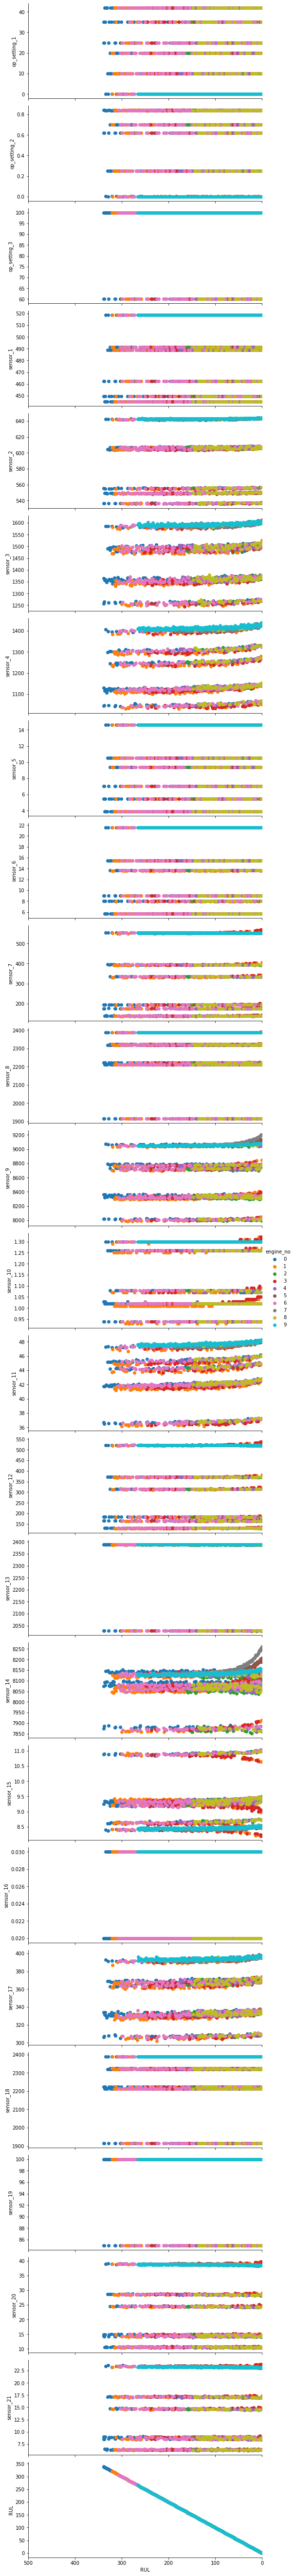

In [169]:
# use seaborn to visualize featuresto target (RUL)
explore = sns.PairGrid(data=dataset.query('engine_no < 10') ,
                 x_vars=['RUL'],
                 y_vars=dataset.drop(columns=metacol).columns,
                 hue="engine_no", height=3, aspect=2.5)
explore = explore.map(plt.scatter)
explore = explore.set(xlim=(500,0))
explore = explore.add_legend()


### Let's take a look at test_data.csv

## Data Visualization

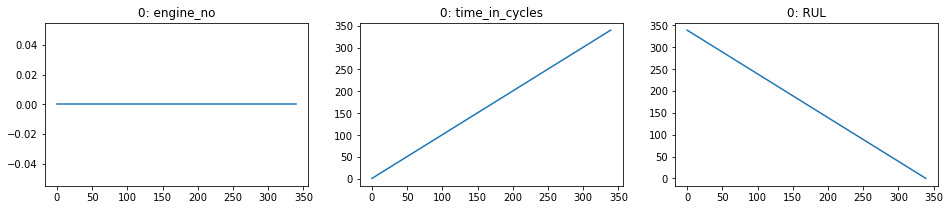

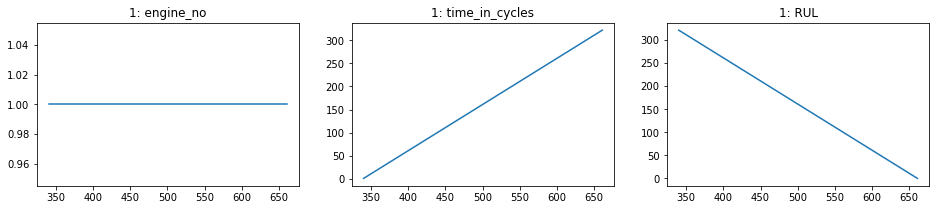

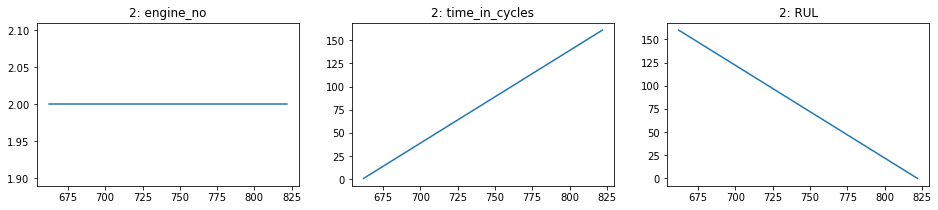

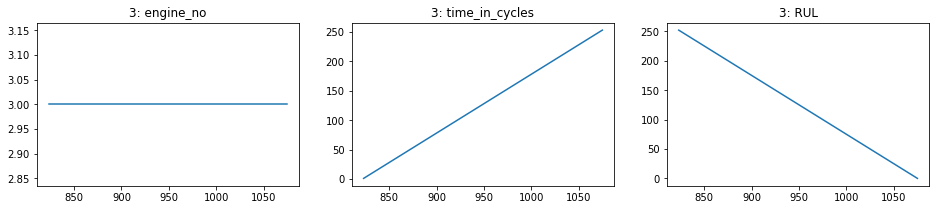

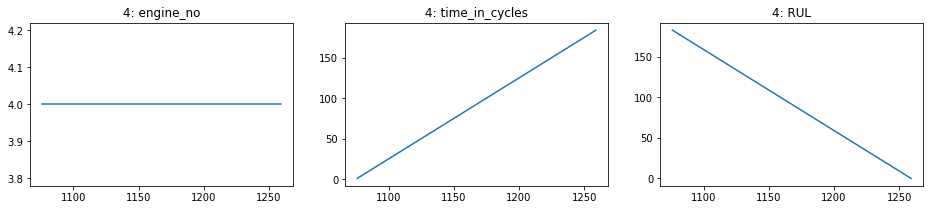

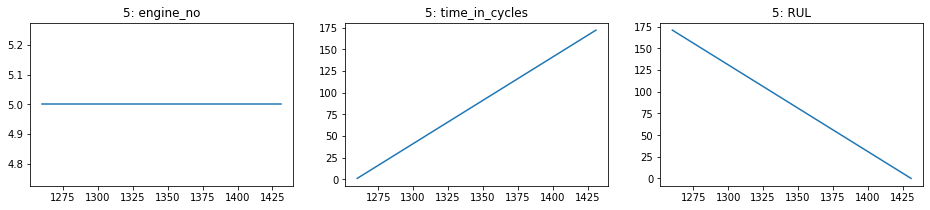

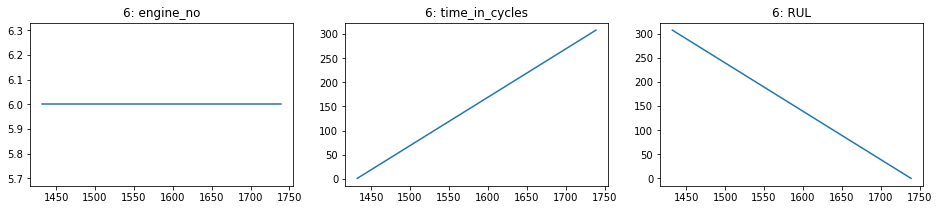

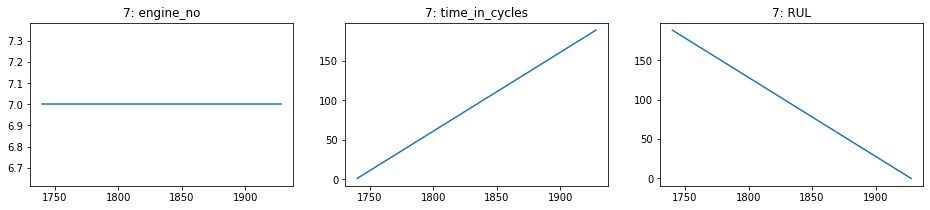

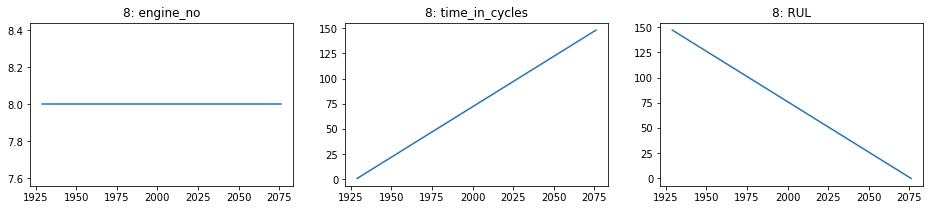

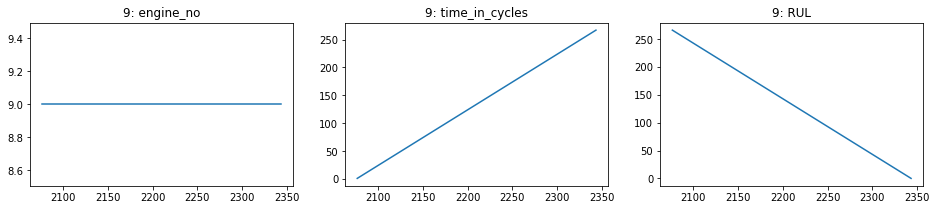

In [170]:
### Draw Histogram with all columns in dataset ###
#************************************************#
def visualize_hist(dataset):
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for i, x in enumerate(dataset):
        row = int(i//4)
        col = int(i%4)
        dataset[x].hist(bins=50, ax=ax[row, col])
        ax[row, col].set_title(x)
#************************************************#


### Draw Plot with three "plot_list" columns ###
#**********************************************#
def visualize_plot(dataset, engine_no):
    plot_list = ['engine_no', 'time_in_cycles', 'RUL']
    fig, ax = plt.subplots(ncols=len(plot_list), nrows=1, figsize=(16,3))
    for i, x in enumerate(plot_list):
        filtered_data = dataset.loc[dataset['engine_no'] == engine_no, :]
        filtered_data[x].plot(ax=ax[i])
        ax[i].set_title(f'{engine_no}: {x}')
#**********************************************#


for x in range(0,10):
#   visualize_hist(dataset.loc[dataset['engine_no'] == x, :])
    visualize_plot(dataset, x)

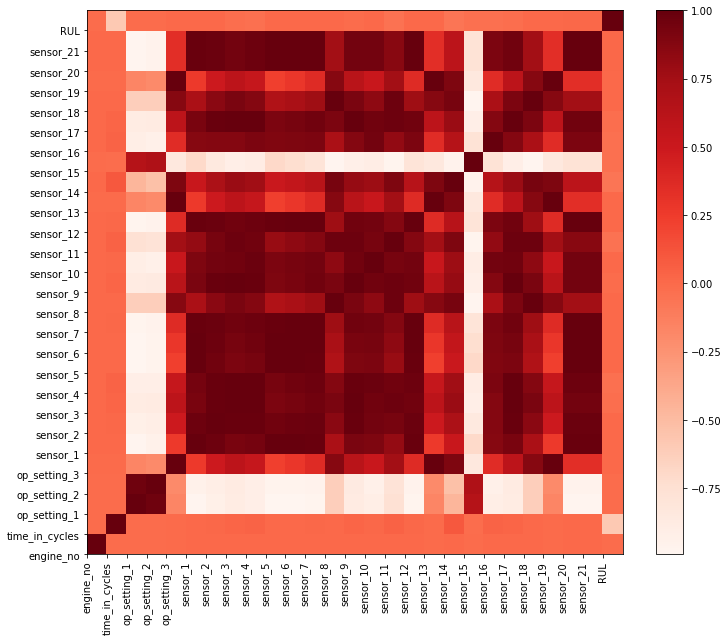

In [171]:
corr = dataset.corr()
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.pcolor(corr, cmap=plt.cm.Reds, vmax=1.0)
ax.set_xticks(np.arange(corr.shape[0]))
ax.set_yticks(np.arange(corr.shape[1]))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
fig.colorbar(heatmap, ax=ax)

In [175]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg = RandomForestRegressor(n_estimators = 200, max_depth = 15)
reg.fit(X, y)
y_pred = reg.predict(X)
print("complete")

importances = reg.feature_importances_
columns=['col', 'val']
pd_importances = pd.DataFrame(columns=columns)
for i, x in enumerate(X.columns):
    pd_importances.loc[i] = [x, importances[i]]

# Get the most important columns in top10    
important_col = pd_importances.sort_values(by='val', ascending=False).loc[:15, 'col']
print(important_col)

complete


AttributeError: 'RandomForestRegressor' object has no attribute 'feature_importances'

In [225]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as lgb

params = {
    'objective': 'mean_squared_error',
    'metric': 'rmse'
}

scaler = StandardScaler()
X = scaler.fit_transform(dataset.loc[:,important_col].values)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

trains = lgb.Dataset(X_tr, y_tr)
tests = lgb.Dataset(X_te, y_te)

model = lgb.train(params, trains, valid_sets=tests)
print(f'best params = {model.params}')
print(f'best score = {model.best_score}')
best_params = model.params

[I 2021-02-12 08:17:47,050] A new study created in memory with name: no-name-def9f14e-9cf6-424e-ad66-dd522d09b14f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.7504
[2]	valid_0's rmse: 76.223
[3]	valid_0's rmse: 73.0716
[4]	valid_0's rmse: 70.3099
[5]	valid_0's rmse: 67.9462
[6]	valid_0's rmse: 65.9483
[7]	valid_0's rmse: 64.1843
[8]	valid_0's rmse: 62.5764
[9]	valid_0's rmse: 61.2669
[10]	valid_0's rmse: 60.0976
[11]	valid_0's rmse: 59.0865
[12]	valid_0's rmse: 58.162
[13]	valid_0's rmse: 57.4104
[14]	valid_0's rmse: 56.7485
[15]	valid_0's rmse: 56.1969
[16]	valid_0's rmse: 55.6611
[17]	valid_0's rmse: 55.1667
[18]	valid_0's rmse: 54.7695
[19]	valid_0's rmse: 54.4377
[20]	valid_0's rmse: 54.0912
[21]	valid_0's rmse: 53.7762
[22]	valid_0's rmse: 53.5495
[23]	valid_0's rmse: 53.3

[322]	valid_0's rmse: 50.3735
[323]	valid_0's rmse: 50.3722
[324]	valid_0's rmse: 50.3732
[325]	valid_0's rmse: 50.3702
[326]	valid_0's rmse: 50.3715
[327]	valid_0's rmse: 50.37
[328]	valid_0's rmse: 50.3708
[329]	valid_0's rmse: 50.3696
[330]	valid_0's rmse: 50.37
[331]	valid_0's rmse: 50.369
[332]	valid_0's rmse: 50.3664
[333]	valid_0's rmse: 50.3674
[334]	valid_0's rmse: 50.3694
[335]	valid_0's rmse: 50.3662
[336]	valid_0's rmse: 50.3675
[337]	valid_0's rmse: 50.3683
[338]	valid_0's rmse: 50.3643
[339]	valid_0's rmse: 50.3656
[340]	valid_0's rmse: 50.3652
[341]	valid_0's rmse: 50.366
[342]	valid_0's rmse: 50.3642
[343]	valid_0's rmse: 50.3652
[344]	valid_0's rmse: 50.3651
[345]	valid_0's rmse: 50.3655
[346]	valid_0's rmse: 50.3635
[347]	valid_0's rmse: 50.3595
[348]	valid_0's rmse: 50.3599
[349]	valid_0's rmse: 50.3595
[350]	valid_0's rmse: 50.3596
[351]	valid_0's rmse: 50.3606
[352]	valid_0's rmse: 50.3597
[353]	valid_0's rmse: 50.3585
[354]	valid_0's rmse: 50.3543
[355]	valid_0's 

[624]	valid_0's rmse: 50.4156
[625]	valid_0's rmse: 50.416
[626]	valid_0's rmse: 50.4174
[627]	valid_0's rmse: 50.4165
[628]	valid_0's rmse: 50.4174
[629]	valid_0's rmse: 50.4191
[630]	valid_0's rmse: 50.4203
[631]	valid_0's rmse: 50.4219
[632]	valid_0's rmse: 50.4246
[633]	valid_0's rmse: 50.4252
[634]	valid_0's rmse: 50.4253
[635]	valid_0's rmse: 50.4212
[636]	valid_0's rmse: 50.4221
[637]	valid_0's rmse: 50.4221
[638]	valid_0's rmse: 50.4221
[639]	valid_0's rmse: 50.4222
[640]	valid_0's rmse: 50.422
[641]	valid_0's rmse: 50.4205
[642]	valid_0's rmse: 50.4204
[643]	valid_0's rmse: 50.4198
[644]	valid_0's rmse: 50.4219
[645]	valid_0's rmse: 50.4234
[646]	valid_0's rmse: 50.4242
[647]	valid_0's rmse: 50.4254
[648]	valid_0's rmse: 50.4249
[649]	valid_0's rmse: 50.4254
[650]	valid_0's rmse: 50.424
[651]	valid_0's rmse: 50.4226
[652]	valid_0's rmse: 50.4212
[653]	valid_0's rmse: 50.422
[654]	valid_0's rmse: 50.4213
[655]	valid_0's rmse: 50.4226
[656]	valid_0's rmse: 50.42
[657]	valid_0's 

[931]	valid_0's rmse: 50.4878
[932]	valid_0's rmse: 50.4875
[933]	valid_0's rmse: 50.4874
[934]	valid_0's rmse: 50.4886
[935]	valid_0's rmse: 50.4875
[936]	valid_0's rmse: 50.4876
[937]	valid_0's rmse: 50.4873
[938]	valid_0's rmse: 50.4866
[939]	valid_0's rmse: 50.4876
[940]	valid_0's rmse: 50.487
[941]	valid_0's rmse: 50.4875
[942]	valid_0's rmse: 50.4874
[943]	valid_0's rmse: 50.4867
[944]	valid_0's rmse: 50.4864
[945]	valid_0's rmse: 50.4865
[946]	valid_0's rmse: 50.4878
[947]	valid_0's rmse: 50.489
[948]	valid_0's rmse: 50.4898
[949]	valid_0's rmse: 50.4905
[950]	valid_0's rmse: 50.4919
[951]	valid_0's rmse: 50.4913
[952]	valid_0's rmse: 50.4914
[953]	valid_0's rmse: 50.4935
[954]	valid_0's rmse: 50.4953
[955]	valid_0's rmse: 50.4958
[956]	valid_0's rmse: 50.4956
[957]	valid_0's rmse: 50.4962
[958]	valid_0's rmse: 50.4966
[959]	valid_0's rmse: 50.4976
[960]	valid_0's rmse: 50.4976
[961]	valid_0's rmse: 50.498
[962]	valid_0's rmse: 50.4982
[963]	valid_0's rmse: 50.4983
[964]	valid_0

feature_fraction, val_score: 50.516729:  14%|#4        | 1/7 [00:04<00:24,  4.02s/it]

[993]	valid_0's rmse: 50.5233
[994]	valid_0's rmse: 50.521
[995]	valid_0's rmse: 50.5226
[996]	valid_0's rmse: 50.5216
[997]	valid_0's rmse: 50.5206
[998]	valid_0's rmse: 50.5183
[999]	valid_0's rmse: 50.518
[1000]	valid_0's rmse: 50.5167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.5325
[2]	valid_0's rmse: 75.9882
[3]	valid_0's rmse: 72.8802
[4]	valid_0's rmse: 70.1591
[5]	valid_0's rmse: 67.8618
[6]	valid_0's rmse: 65.8259
[7]	valid_0's rmse: 64.1013
[8]	valid_0's rmse: 62.6088
[9]	valid_0's rmse: 61.3413
[10]	valid_0's rmse: 60.2122
[11]	valid_0's rmse: 59.2282
[12]	valid_0's rmse: 58.3053
[13]	valid_0's rmse: 57.5565
[14]	valid_0's rmse: 56.9054
[15]	valid_0's r

[304]	valid_0's rmse: 50.4282
[305]	valid_0's rmse: 50.4296
[306]	valid_0's rmse: 50.432
[307]	valid_0's rmse: 50.4319
[308]	valid_0's rmse: 50.431
[309]	valid_0's rmse: 50.4335
[310]	valid_0's rmse: 50.4337
[311]	valid_0's rmse: 50.4343
[312]	valid_0's rmse: 50.4305
[313]	valid_0's rmse: 50.4297
[314]	valid_0's rmse: 50.4289
[315]	valid_0's rmse: 50.4292
[316]	valid_0's rmse: 50.429
[317]	valid_0's rmse: 50.4255
[318]	valid_0's rmse: 50.4239
[319]	valid_0's rmse: 50.4236
[320]	valid_0's rmse: 50.4237
[321]	valid_0's rmse: 50.4235
[322]	valid_0's rmse: 50.4239
[323]	valid_0's rmse: 50.4247
[324]	valid_0's rmse: 50.4267
[325]	valid_0's rmse: 50.43
[326]	valid_0's rmse: 50.427
[327]	valid_0's rmse: 50.4291
[328]	valid_0's rmse: 50.4289
[329]	valid_0's rmse: 50.4291
[330]	valid_0's rmse: 50.4299
[331]	valid_0's rmse: 50.4291
[332]	valid_0's rmse: 50.4246
[333]	valid_0's rmse: 50.4255
[334]	valid_0's rmse: 50.4264
[335]	valid_0's rmse: 50.4285
[336]	valid_0's rmse: 50.4266
[337]	valid_0's 

[584]	valid_0's rmse: 50.4806
[585]	valid_0's rmse: 50.4816
[586]	valid_0's rmse: 50.4814
[587]	valid_0's rmse: 50.4813
[588]	valid_0's rmse: 50.4819
[589]	valid_0's rmse: 50.4817
[590]	valid_0's rmse: 50.4802
[591]	valid_0's rmse: 50.481
[592]	valid_0's rmse: 50.4823
[593]	valid_0's rmse: 50.483
[594]	valid_0's rmse: 50.4832
[595]	valid_0's rmse: 50.4829
[596]	valid_0's rmse: 50.4843
[597]	valid_0's rmse: 50.483
[598]	valid_0's rmse: 50.4861
[599]	valid_0's rmse: 50.4852
[600]	valid_0's rmse: 50.4849
[601]	valid_0's rmse: 50.483
[602]	valid_0's rmse: 50.4823
[603]	valid_0's rmse: 50.4822
[604]	valid_0's rmse: 50.4818
[605]	valid_0's rmse: 50.483
[606]	valid_0's rmse: 50.4832
[607]	valid_0's rmse: 50.4828
[608]	valid_0's rmse: 50.4854
[609]	valid_0's rmse: 50.4879
[610]	valid_0's rmse: 50.4883
[611]	valid_0's rmse: 50.4882
[612]	valid_0's rmse: 50.4911
[613]	valid_0's rmse: 50.493
[614]	valid_0's rmse: 50.4937
[615]	valid_0's rmse: 50.4944
[616]	valid_0's rmse: 50.4946
[617]	valid_0's 

[858]	valid_0's rmse: 50.6026
[859]	valid_0's rmse: 50.6057
[860]	valid_0's rmse: 50.6058
[861]	valid_0's rmse: 50.6076
[862]	valid_0's rmse: 50.605
[863]	valid_0's rmse: 50.6045
[864]	valid_0's rmse: 50.6035
[865]	valid_0's rmse: 50.606
[866]	valid_0's rmse: 50.6088
[867]	valid_0's rmse: 50.6086
[868]	valid_0's rmse: 50.6083
[869]	valid_0's rmse: 50.6069
[870]	valid_0's rmse: 50.6073
[871]	valid_0's rmse: 50.6087
[872]	valid_0's rmse: 50.6084
[873]	valid_0's rmse: 50.6101
[874]	valid_0's rmse: 50.6122
[875]	valid_0's rmse: 50.6121
[876]	valid_0's rmse: 50.612
[877]	valid_0's rmse: 50.6111
[878]	valid_0's rmse: 50.6116
[879]	valid_0's rmse: 50.6114
[880]	valid_0's rmse: 50.6096
[881]	valid_0's rmse: 50.6094
[882]	valid_0's rmse: 50.6094
[883]	valid_0's rmse: 50.61
[884]	valid_0's rmse: 50.6102
[885]	valid_0's rmse: 50.6107
[886]	valid_0's rmse: 50.6093
[887]	valid_0's rmse: 50.611
[888]	valid_0's rmse: 50.6103
[889]	valid_0's rmse: 50.61
[890]	valid_0's rmse: 50.61
[891]	valid_0's rmse

feature_fraction, val_score: 50.516729:  29%|##8       | 2/7 [00:09<00:24,  4.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.5248
[2]	valid_0's rmse: 75.9755
[3]	valid_0's rmse: 72.8947
[4]	valid_0's rmse: 70.2541
[5]	valid_0's rmse: 67.9344
[6]	valid_0's rmse: 65.9519
[7]	valid_0's rmse: 64.2043
[8]	valid_0's rmse: 62.7106
[9]	valid_0's rmse: 61.4216
[10]	valid_0's rmse: 60.2915
[11]	valid_0's rmse: 59.3099
[12]	valid_0's rmse: 58.4282
[13]	valid_0's rmse: 57.6913
[14]	valid_0's rmse: 57.0096
[15]	valid_0's rmse: 56.4463
[16]	valid_0's rmse: 55.9415
[17]	valid_0's rmse: 55.4951
[18]	valid_0's rmse: 55.0846
[19]	valid_0's rmse: 54.719
[20]	valid_0's rmse: 54.4133
[21]	valid_0's rmse: 54.1039
[22]	valid_0's rmse: 53.8427
[23]	valid_0's rmse: 53.

[283]	valid_0's rmse: 50.4919
[284]	valid_0's rmse: 50.4909
[285]	valid_0's rmse: 50.4902
[286]	valid_0's rmse: 50.4863
[287]	valid_0's rmse: 50.4846
[288]	valid_0's rmse: 50.4835
[289]	valid_0's rmse: 50.4845
[290]	valid_0's rmse: 50.4862
[291]	valid_0's rmse: 50.4867
[292]	valid_0's rmse: 50.4864
[293]	valid_0's rmse: 50.4882
[294]	valid_0's rmse: 50.4881
[295]	valid_0's rmse: 50.4916
[296]	valid_0's rmse: 50.4943
[297]	valid_0's rmse: 50.4937
[298]	valid_0's rmse: 50.494
[299]	valid_0's rmse: 50.4935
[300]	valid_0's rmse: 50.4948
[301]	valid_0's rmse: 50.4979
[302]	valid_0's rmse: 50.4991
[303]	valid_0's rmse: 50.4963
[304]	valid_0's rmse: 50.4976
[305]	valid_0's rmse: 50.4984
[306]	valid_0's rmse: 50.4974
[307]	valid_0's rmse: 50.4965
[308]	valid_0's rmse: 50.4948
[309]	valid_0's rmse: 50.4933
[310]	valid_0's rmse: 50.4944
[311]	valid_0's rmse: 50.4952
[312]	valid_0's rmse: 50.4889
[313]	valid_0's rmse: 50.4894
[314]	valid_0's rmse: 50.4964
[315]	valid_0's rmse: 50.4986
[316]	valid

[594]	valid_0's rmse: 50.5415
[595]	valid_0's rmse: 50.5406
[596]	valid_0's rmse: 50.5396
[597]	valid_0's rmse: 50.5404
[598]	valid_0's rmse: 50.5386
[599]	valid_0's rmse: 50.5414
[600]	valid_0's rmse: 50.5419
[601]	valid_0's rmse: 50.5426
[602]	valid_0's rmse: 50.5421
[603]	valid_0's rmse: 50.5437
[604]	valid_0's rmse: 50.543
[605]	valid_0's rmse: 50.546
[606]	valid_0's rmse: 50.546
[607]	valid_0's rmse: 50.5462
[608]	valid_0's rmse: 50.548
[609]	valid_0's rmse: 50.5491
[610]	valid_0's rmse: 50.5485
[611]	valid_0's rmse: 50.5484
[612]	valid_0's rmse: 50.5487
[613]	valid_0's rmse: 50.5483
[614]	valid_0's rmse: 50.5492
[615]	valid_0's rmse: 50.5503
[616]	valid_0's rmse: 50.5512
[617]	valid_0's rmse: 50.5515
[618]	valid_0's rmse: 50.5521
[619]	valid_0's rmse: 50.5526
[620]	valid_0's rmse: 50.5507
[621]	valid_0's rmse: 50.5507
[622]	valid_0's rmse: 50.5472
[623]	valid_0's rmse: 50.5477
[624]	valid_0's rmse: 50.5486
[625]	valid_0's rmse: 50.5471
[626]	valid_0's rmse: 50.5472
[627]	valid_0'

[916]	valid_0's rmse: 50.6699
[917]	valid_0's rmse: 50.6692
[918]	valid_0's rmse: 50.668
[919]	valid_0's rmse: 50.6682
[920]	valid_0's rmse: 50.6698
[921]	valid_0's rmse: 50.6718
[922]	valid_0's rmse: 50.672
[923]	valid_0's rmse: 50.6727
[924]	valid_0's rmse: 50.6721
[925]	valid_0's rmse: 50.6733
[926]	valid_0's rmse: 50.6739
[927]	valid_0's rmse: 50.676
[928]	valid_0's rmse: 50.6756
[929]	valid_0's rmse: 50.6763
[930]	valid_0's rmse: 50.6785
[931]	valid_0's rmse: 50.6789
[932]	valid_0's rmse: 50.68
[933]	valid_0's rmse: 50.6782
[934]	valid_0's rmse: 50.6796
[935]	valid_0's rmse: 50.6802
[936]	valid_0's rmse: 50.6812
[937]	valid_0's rmse: 50.682
[938]	valid_0's rmse: 50.6877
[939]	valid_0's rmse: 50.6897
[940]	valid_0's rmse: 50.6905
[941]	valid_0's rmse: 50.6905
[942]	valid_0's rmse: 50.6919
[943]	valid_0's rmse: 50.6916
[944]	valid_0's rmse: 50.6917
[945]	valid_0's rmse: 50.6915
[946]	valid_0's rmse: 50.6921
[947]	valid_0's rmse: 50.6912
[948]	valid_0's rmse: 50.6913
[949]	valid_0's 

feature_fraction, val_score: 50.516729:  43%|####2     | 3/7 [00:14<00:18,  4.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.6521
[2]	valid_0's rmse: 76.3509
[3]	valid_0's rmse: 73.5049
[4]	valid_0's rmse: 71.078
[5]	valid_0's rmse: 68.7764
[6]	valid_0's rmse: 66.6546
[7]	valid_0's rmse: 64.6497
[8]	valid_0's rmse: 62.9803
[9]	valid_0's rmse: 61.5934
[10]	valid_0's rmse: 60.4186
[11]	valid_0's rmse: 59.2373
[12]	valid_0's rmse: 58.3266
[13]	valid_0's rmse: 57.4693
[14]	valid_0's rmse: 56.7663
[15]	valid_0's rmse: 56.1881
[16]	valid_0's rmse: 55.6987
[17]	valid_0's rmse: 55.2502
[18]	valid_0's rmse: 54.8022
[19]	valid_0's rmse: 54.4639
[20]	valid_0's rmse: 54.1298
[21]	valid_0's rmse: 53.8734
[22]	valid_0's rmse: 53.6182
[23]	valid_0's rmse: 53.

[269]	valid_0's rmse: 50.496
[270]	valid_0's rmse: 50.4949
[271]	valid_0's rmse: 50.4941
[272]	valid_0's rmse: 50.4947
[273]	valid_0's rmse: 50.4942
[274]	valid_0's rmse: 50.494
[275]	valid_0's rmse: 50.4944
[276]	valid_0's rmse: 50.4934
[277]	valid_0's rmse: 50.4924
[278]	valid_0's rmse: 50.4899
[279]	valid_0's rmse: 50.4872
[280]	valid_0's rmse: 50.487
[281]	valid_0's rmse: 50.4869
[282]	valid_0's rmse: 50.488
[283]	valid_0's rmse: 50.4872
[284]	valid_0's rmse: 50.4895
[285]	valid_0's rmse: 50.49
[286]	valid_0's rmse: 50.4903
[287]	valid_0's rmse: 50.4905
[288]	valid_0's rmse: 50.4844
[289]	valid_0's rmse: 50.4841
[290]	valid_0's rmse: 50.4841
[291]	valid_0's rmse: 50.4888
[292]	valid_0's rmse: 50.4879
[293]	valid_0's rmse: 50.4889
[294]	valid_0's rmse: 50.4875
[295]	valid_0's rmse: 50.4892
[296]	valid_0's rmse: 50.4881
[297]	valid_0's rmse: 50.4894
[298]	valid_0's rmse: 50.4858
[299]	valid_0's rmse: 50.4855
[300]	valid_0's rmse: 50.4851
[301]	valid_0's rmse: 50.4847
[302]	valid_0's 

[551]	valid_0's rmse: 50.4508
[552]	valid_0's rmse: 50.4494
[553]	valid_0's rmse: 50.4499
[554]	valid_0's rmse: 50.4495
[555]	valid_0's rmse: 50.4529
[556]	valid_0's rmse: 50.4537
[557]	valid_0's rmse: 50.4542
[558]	valid_0's rmse: 50.4539
[559]	valid_0's rmse: 50.4551
[560]	valid_0's rmse: 50.4556
[561]	valid_0's rmse: 50.4557
[562]	valid_0's rmse: 50.4554
[563]	valid_0's rmse: 50.4544
[564]	valid_0's rmse: 50.4544
[565]	valid_0's rmse: 50.4554
[566]	valid_0's rmse: 50.4558
[567]	valid_0's rmse: 50.4571
[568]	valid_0's rmse: 50.4578
[569]	valid_0's rmse: 50.4567
[570]	valid_0's rmse: 50.4572
[571]	valid_0's rmse: 50.4572
[572]	valid_0's rmse: 50.4571
[573]	valid_0's rmse: 50.4579
[574]	valid_0's rmse: 50.457
[575]	valid_0's rmse: 50.4562
[576]	valid_0's rmse: 50.4564
[577]	valid_0's rmse: 50.4559
[578]	valid_0's rmse: 50.4568
[579]	valid_0's rmse: 50.4575
[580]	valid_0's rmse: 50.4563
[581]	valid_0's rmse: 50.4575
[582]	valid_0's rmse: 50.4566
[583]	valid_0's rmse: 50.4565
[584]	valid

[891]	valid_0's rmse: 50.5266
[892]	valid_0's rmse: 50.5276
[893]	valid_0's rmse: 50.5269
[894]	valid_0's rmse: 50.5258
[895]	valid_0's rmse: 50.5272
[896]	valid_0's rmse: 50.5284
[897]	valid_0's rmse: 50.5281
[898]	valid_0's rmse: 50.5287
[899]	valid_0's rmse: 50.5306
[900]	valid_0's rmse: 50.53
[901]	valid_0's rmse: 50.531
[902]	valid_0's rmse: 50.5332
[903]	valid_0's rmse: 50.5344
[904]	valid_0's rmse: 50.536
[905]	valid_0's rmse: 50.5366
[906]	valid_0's rmse: 50.536
[907]	valid_0's rmse: 50.5346
[908]	valid_0's rmse: 50.5342
[909]	valid_0's rmse: 50.5327
[910]	valid_0's rmse: 50.533
[911]	valid_0's rmse: 50.5318
[912]	valid_0's rmse: 50.5335
[913]	valid_0's rmse: 50.5331
[914]	valid_0's rmse: 50.533
[915]	valid_0's rmse: 50.5311
[916]	valid_0's rmse: 50.5313
[917]	valid_0's rmse: 50.5312
[918]	valid_0's rmse: 50.5313
[919]	valid_0's rmse: 50.5302
[920]	valid_0's rmse: 50.5311
[921]	valid_0's rmse: 50.5329
[922]	valid_0's rmse: 50.5327
[923]	valid_0's rmse: 50.5355
[924]	valid_0's r

feature_fraction, val_score: 50.516729:  57%|#####7    | 4/7 [00:17<00:12,  4.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.8319
[2]	valid_0's rmse: 76.2825
[3]	valid_0's rmse: 73.146
[4]	valid_0's rmse: 70.3869
[5]	valid_0's rmse: 68.0629
[6]	valid_0's rmse: 66.0722
[7]	valid_0's rmse: 64.2909
[8]	valid_0's rmse: 62.7386
[9]	valid_0's rmse: 61.4336
[10]	valid_0's rmse: 60.2153
[11]	valid_0's rmse: 59.1947
[12]	valid_0's rmse: 58.3139
[13]	valid_0's rmse: 57.587
[14]	valid_0's rmse: 56.8546
[15]	valid_0's rmse: 56.2903
[16]	valid_0's rmse: 55.7878
[17]	valid_0's rmse: 55.3152
[18]	valid_0's rmse: 54.9187
[19]	valid_0's rmse: 54.5889
[20]	valid_0's rmse: 54.2254
[21]	valid_0's rmse

[291]	valid_0's rmse: 50.3487
[292]	valid_0's rmse: 50.3446
[293]	valid_0's rmse: 50.3451
[294]	valid_0's rmse: 50.3459
[295]	valid_0's rmse: 50.3486
[296]	valid_0's rmse: 50.352
[297]	valid_0's rmse: 50.3523
[298]	valid_0's rmse: 50.3523
[299]	valid_0's rmse: 50.3515
[300]	valid_0's rmse: 50.3507
[301]	valid_0's rmse: 50.3501
[302]	valid_0's rmse: 50.35
[303]	valid_0's rmse: 50.3492
[304]	valid_0's rmse: 50.3485
[305]	valid_0's rmse: 50.3457
[306]	valid_0's rmse: 50.3433
[307]	valid_0's rmse: 50.3375
[308]	valid_0's rmse: 50.3365
[309]	valid_0's rmse: 50.3366
[310]	valid_0's rmse: 50.3363
[311]	valid_0's rmse: 50.3359
[312]	valid_0's rmse: 50.3336
[313]	valid_0's rmse: 50.3309
[314]	valid_0's rmse: 50.3322
[315]	valid_0's rmse: 50.3337
[316]	valid_0's rmse: 50.3296
[317]	valid_0's rmse: 50.3298
[318]	valid_0's rmse: 50.3278
[319]	valid_0's rmse: 50.3288
[320]	valid_0's rmse: 50.3278
[321]	valid_0's rmse: 50.3273
[322]	valid_0's rmse: 50.3262
[323]	valid_0's rmse: 50.327
[324]	valid_0'

[601]	valid_0's rmse: 50.3723
[602]	valid_0's rmse: 50.374
[603]	valid_0's rmse: 50.3746
[604]	valid_0's rmse: 50.3753
[605]	valid_0's rmse: 50.3762
[606]	valid_0's rmse: 50.3761
[607]	valid_0's rmse: 50.377
[608]	valid_0's rmse: 50.3767
[609]	valid_0's rmse: 50.3768
[610]	valid_0's rmse: 50.3788
[611]	valid_0's rmse: 50.3798
[612]	valid_0's rmse: 50.3815
[613]	valid_0's rmse: 50.3832
[614]	valid_0's rmse: 50.3835
[615]	valid_0's rmse: 50.3836
[616]	valid_0's rmse: 50.3828
[617]	valid_0's rmse: 50.3814
[618]	valid_0's rmse: 50.3827
[619]	valid_0's rmse: 50.3825
[620]	valid_0's rmse: 50.3828
[621]	valid_0's rmse: 50.383
[622]	valid_0's rmse: 50.3841
[623]	valid_0's rmse: 50.3847
[624]	valid_0's rmse: 50.3859
[625]	valid_0's rmse: 50.3857
[626]	valid_0's rmse: 50.3848
[627]	valid_0's rmse: 50.3838
[628]	valid_0's rmse: 50.3841
[629]	valid_0's rmse: 50.3853
[630]	valid_0's rmse: 50.3866
[631]	valid_0's rmse: 50.3863
[632]	valid_0's rmse: 50.3861
[633]	valid_0's rmse: 50.3864
[634]	valid_0

[892]	valid_0's rmse: 50.4843
[893]	valid_0's rmse: 50.4848
[894]	valid_0's rmse: 50.4865
[895]	valid_0's rmse: 50.4879
[896]	valid_0's rmse: 50.489
[897]	valid_0's rmse: 50.4894
[898]	valid_0's rmse: 50.4896
[899]	valid_0's rmse: 50.4904
[900]	valid_0's rmse: 50.4904
[901]	valid_0's rmse: 50.4894
[902]	valid_0's rmse: 50.4901
[903]	valid_0's rmse: 50.4907
[904]	valid_0's rmse: 50.4908
[905]	valid_0's rmse: 50.4923
[906]	valid_0's rmse: 50.4927
[907]	valid_0's rmse: 50.4922
[908]	valid_0's rmse: 50.4913
[909]	valid_0's rmse: 50.4922
[910]	valid_0's rmse: 50.4921
[911]	valid_0's rmse: 50.492
[912]	valid_0's rmse: 50.4938
[913]	valid_0's rmse: 50.4937
[914]	valid_0's rmse: 50.4921
[915]	valid_0's rmse: 50.4923
[916]	valid_0's rmse: 50.4928
[917]	valid_0's rmse: 50.4922
[918]	valid_0's rmse: 50.4921
[919]	valid_0's rmse: 50.4919
[920]	valid_0's rmse: 50.4919
[921]	valid_0's rmse: 50.4909
[922]	valid_0's rmse: 50.4909
[923]	valid_0's rmse: 50.4911
[924]	valid_0's rmse: 50.4908
[925]	valid_

feature_fraction, val_score: 50.508595:  71%|#######1  | 5/7 [00:22<00:09,  4.60s/it]

[992]	valid_0's rmse: 50.506
[993]	valid_0's rmse: 50.5058
[994]	valid_0's rmse: 50.5076
[995]	valid_0's rmse: 50.5088
[996]	valid_0's rmse: 50.5091
[997]	valid_0's rmse: 50.5089
[998]	valid_0's rmse: 50.508
[999]	valid_0's rmse: 50.5083
[1000]	valid_0's rmse: 50.5086


[I 2021-02-12 08:18:09,895] Trial 4 finished with value: 50.5085951700814 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 50.5085951700814.
feature_fraction, val_score: 50.508595:  71%|#######1  | 5/7 [00:22<00:09,  4.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.725
[2]	valid_0's rmse: 76.1733
[3]	valid_0's rmse: 73.0216
[4]	valid_0's rmse: 70.2912
[5]	valid_0's rmse: 67.9227
[6]	valid_0's rmse: 65.8366
[7]	valid_0's rmse: 64.0427
[8]	valid_0's rmse: 62.5306
[9]	valid_0's rmse: 61.23
[10]	valid_0's rmse: 60.1326
[11]	valid_0's rmse: 59.1568
[12]	valid_0's rmse: 58.2606
[13]	valid_0's rmse: 57.4989
[14]	valid_0's rmse: 56.7999
[15]	valid_0's rmse: 56.2042
[16]	valid_0's rmse: 55.6557
[17]	valid_0's rmse: 55.225
[18]	valid_0's rmse: 54.8284
[19]	valid_0's rmse: 54.4895
[20]	valid_0's rmse: 54.1985
[21]	valid_0's rmse: 53.9271
[22]	valid_0's rmse: 53.6845
[23]	valid_0's rmse: 53.484

[284]	valid_0's rmse: 50.4479
[285]	valid_0's rmse: 50.4475
[286]	valid_0's rmse: 50.4478
[287]	valid_0's rmse: 50.4457
[288]	valid_0's rmse: 50.4413
[289]	valid_0's rmse: 50.4416
[290]	valid_0's rmse: 50.4399
[291]	valid_0's rmse: 50.4387
[292]	valid_0's rmse: 50.4391
[293]	valid_0's rmse: 50.4369
[294]	valid_0's rmse: 50.4373
[295]	valid_0's rmse: 50.438
[296]	valid_0's rmse: 50.4384
[297]	valid_0's rmse: 50.4389
[298]	valid_0's rmse: 50.4387
[299]	valid_0's rmse: 50.4384
[300]	valid_0's rmse: 50.4372
[301]	valid_0's rmse: 50.4358
[302]	valid_0's rmse: 50.4352
[303]	valid_0's rmse: 50.4361
[304]	valid_0's rmse: 50.4308
[305]	valid_0's rmse: 50.4306
[306]	valid_0's rmse: 50.4296
[307]	valid_0's rmse: 50.4295
[308]	valid_0's rmse: 50.4292
[309]	valid_0's rmse: 50.4336
[310]	valid_0's rmse: 50.4334
[311]	valid_0's rmse: 50.433
[312]	valid_0's rmse: 50.4358
[313]	valid_0's rmse: 50.4354
[314]	valid_0's rmse: 50.437
[315]	valid_0's rmse: 50.4385
[316]	valid_0's rmse: 50.4375
[317]	valid_0

[577]	valid_0's rmse: 50.4665
[578]	valid_0's rmse: 50.4662
[579]	valid_0's rmse: 50.4662
[580]	valid_0's rmse: 50.4637
[581]	valid_0's rmse: 50.4638
[582]	valid_0's rmse: 50.4629
[583]	valid_0's rmse: 50.4622
[584]	valid_0's rmse: 50.462
[585]	valid_0's rmse: 50.4612
[586]	valid_0's rmse: 50.4631
[587]	valid_0's rmse: 50.4643
[588]	valid_0's rmse: 50.4653
[589]	valid_0's rmse: 50.4662
[590]	valid_0's rmse: 50.4676
[591]	valid_0's rmse: 50.469
[592]	valid_0's rmse: 50.4686
[593]	valid_0's rmse: 50.4674
[594]	valid_0's rmse: 50.4669
[595]	valid_0's rmse: 50.4667
[596]	valid_0's rmse: 50.4651
[597]	valid_0's rmse: 50.4656
[598]	valid_0's rmse: 50.4654
[599]	valid_0's rmse: 50.4658
[600]	valid_0's rmse: 50.4672
[601]	valid_0's rmse: 50.4672
[602]	valid_0's rmse: 50.4719
[603]	valid_0's rmse: 50.4709
[604]	valid_0's rmse: 50.4734
[605]	valid_0's rmse: 50.4747
[606]	valid_0's rmse: 50.4748
[607]	valid_0's rmse: 50.4758
[608]	valid_0's rmse: 50.476
[609]	valid_0's rmse: 50.4765
[610]	valid_0

[874]	valid_0's rmse: 50.5792
[875]	valid_0's rmse: 50.5802
[876]	valid_0's rmse: 50.5792
[877]	valid_0's rmse: 50.5795
[878]	valid_0's rmse: 50.5799
[879]	valid_0's rmse: 50.5819
[880]	valid_0's rmse: 50.5837
[881]	valid_0's rmse: 50.5841
[882]	valid_0's rmse: 50.5835
[883]	valid_0's rmse: 50.5849
[884]	valid_0's rmse: 50.5854
[885]	valid_0's rmse: 50.5867
[886]	valid_0's rmse: 50.5886
[887]	valid_0's rmse: 50.5879
[888]	valid_0's rmse: 50.5876
[889]	valid_0's rmse: 50.589
[890]	valid_0's rmse: 50.5898
[891]	valid_0's rmse: 50.5894
[892]	valid_0's rmse: 50.5891
[893]	valid_0's rmse: 50.5912
[894]	valid_0's rmse: 50.5933
[895]	valid_0's rmse: 50.5923
[896]	valid_0's rmse: 50.5911
[897]	valid_0's rmse: 50.5906
[898]	valid_0's rmse: 50.5904
[899]	valid_0's rmse: 50.5891
[900]	valid_0's rmse: 50.5891
[901]	valid_0's rmse: 50.5892
[902]	valid_0's rmse: 50.5924
[903]	valid_0's rmse: 50.5929
[904]	valid_0's rmse: 50.5913
[905]	valid_0's rmse: 50.5918
[906]	valid_0's rmse: 50.5913
[907]	valid

feature_fraction, val_score: 50.508595:  86%|########5 | 6/7 [00:26<00:04,  4.40s/it]

[998]	valid_0's rmse: 50.6335
[999]	valid_0's rmse: 50.635
[1000]	valid_0's rmse: 50.6368
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.747
[2]	valid_0's rmse: 76.2186
[3]	valid_0's rmse: 73.0314
[4]	valid_0's rmse: 70.2672
[5]	valid_0's rmse: 67.9231
[6]	valid_0's rmse: 65.9275
[7]	valid_0's rmse: 64.139
[8]	valid_0's rmse: 62.6623
[9]	valid_0's rmse: 61.3068
[10]	valid_0's rmse: 60.1601
[11]	valid_0's rmse: 59.1984
[12]	valid_0's rmse: 58.2401
[13]	valid_0's rmse: 57.5025
[14]	valid_0's rmse: 56.8133
[15]	valid_0's rmse: 56.2688
[16]	valid_0's rmse: 55.7241
[17]	valid_0's rmse: 55.2224
[18]	valid_0's rmse: 54.8324
[19]	valid_0's rmse: 54.4816
[20]	valid_0's rmse: 5

[285]	valid_0's rmse: 50.4193
[286]	valid_0's rmse: 50.4227
[287]	valid_0's rmse: 50.4218
[288]	valid_0's rmse: 50.4231
[289]	valid_0's rmse: 50.4232
[290]	valid_0's rmse: 50.4165
[291]	valid_0's rmse: 50.4166
[292]	valid_0's rmse: 50.4182
[293]	valid_0's rmse: 50.4191
[294]	valid_0's rmse: 50.4206
[295]	valid_0's rmse: 50.4217
[296]	valid_0's rmse: 50.4209
[297]	valid_0's rmse: 50.4198
[298]	valid_0's rmse: 50.4163
[299]	valid_0's rmse: 50.4135
[300]	valid_0's rmse: 50.4135
[301]	valid_0's rmse: 50.4085
[302]	valid_0's rmse: 50.4083
[303]	valid_0's rmse: 50.4084
[304]	valid_0's rmse: 50.41
[305]	valid_0's rmse: 50.411
[306]	valid_0's rmse: 50.4106
[307]	valid_0's rmse: 50.409
[308]	valid_0's rmse: 50.4072
[309]	valid_0's rmse: 50.406
[310]	valid_0's rmse: 50.4075
[311]	valid_0's rmse: 50.4086
[312]	valid_0's rmse: 50.4086
[313]	valid_0's rmse: 50.4115
[314]	valid_0's rmse: 50.4105
[315]	valid_0's rmse: 50.4096
[316]	valid_0's rmse: 50.4072
[317]	valid_0's rmse: 50.407
[318]	valid_0's 

[597]	valid_0's rmse: 50.3957
[598]	valid_0's rmse: 50.3955
[599]	valid_0's rmse: 50.3964
[600]	valid_0's rmse: 50.3957
[601]	valid_0's rmse: 50.3976
[602]	valid_0's rmse: 50.3985
[603]	valid_0's rmse: 50.4001
[604]	valid_0's rmse: 50.4003
[605]	valid_0's rmse: 50.402
[606]	valid_0's rmse: 50.4008
[607]	valid_0's rmse: 50.4001
[608]	valid_0's rmse: 50.3987
[609]	valid_0's rmse: 50.3987
[610]	valid_0's rmse: 50.3981
[611]	valid_0's rmse: 50.3969
[612]	valid_0's rmse: 50.3985
[613]	valid_0's rmse: 50.3951
[614]	valid_0's rmse: 50.3953
[615]	valid_0's rmse: 50.3951
[616]	valid_0's rmse: 50.394
[617]	valid_0's rmse: 50.3941
[618]	valid_0's rmse: 50.3944
[619]	valid_0's rmse: 50.395
[620]	valid_0's rmse: 50.3935
[621]	valid_0's rmse: 50.3945
[622]	valid_0's rmse: 50.3972
[623]	valid_0's rmse: 50.3961
[624]	valid_0's rmse: 50.3947
[625]	valid_0's rmse: 50.3941
[626]	valid_0's rmse: 50.3947
[627]	valid_0's rmse: 50.3952
[628]	valid_0's rmse: 50.3961
[629]	valid_0's rmse: 50.3957
[630]	valid_0

[917]	valid_0's rmse: 50.4925
[918]	valid_0's rmse: 50.4928
[919]	valid_0's rmse: 50.4945
[920]	valid_0's rmse: 50.4948
[921]	valid_0's rmse: 50.4942
[922]	valid_0's rmse: 50.4925
[923]	valid_0's rmse: 50.492
[924]	valid_0's rmse: 50.4931
[925]	valid_0's rmse: 50.493
[926]	valid_0's rmse: 50.492
[927]	valid_0's rmse: 50.4922
[928]	valid_0's rmse: 50.493
[929]	valid_0's rmse: 50.4929
[930]	valid_0's rmse: 50.493
[931]	valid_0's rmse: 50.4929
[932]	valid_0's rmse: 50.4936
[933]	valid_0's rmse: 50.4933
[934]	valid_0's rmse: 50.4947
[935]	valid_0's rmse: 50.4955
[936]	valid_0's rmse: 50.4952
[937]	valid_0's rmse: 50.4954
[938]	valid_0's rmse: 50.4955
[939]	valid_0's rmse: 50.4962
[940]	valid_0's rmse: 50.4967
[941]	valid_0's rmse: 50.4972
[942]	valid_0's rmse: 50.4967
[943]	valid_0's rmse: 50.497
[944]	valid_0's rmse: 50.4969
[945]	valid_0's rmse: 50.497
[946]	valid_0's rmse: 50.4986
[947]	valid_0's rmse: 50.5012
[948]	valid_0's rmse: 50.5012
[949]	valid_0's rmse: 50.502
[950]	valid_0's rm

num_leaves, val_score: 50.508595:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.1239
[2]	valid_0's rmse: 75.1354
[3]	valid_0's rmse: 71.5866
[4]	valid_0's rmse: 68.5128
[5]	valid_0's rmse: 65.8552
[6]	valid_0's rmse: 63.7175
[7]	valid_0's rmse: 61.8446
[8]	valid_0's rmse: 60.211
[9]	valid_0's rmse: 58.8593
[10]	valid_0's rmse: 57.6733
[11]	valid_0's rmse: 56.6964
[12]	valid_0's rmse: 55.881
[13]	valid_0's rmse: 55.1838
[14]	valid_0's rmse: 54.3863
[15]	valid_0's rmse: 53.7494
[16]	valid_0's rmse: 53.3451
[17]	valid_0's rmse: 52.8551
[18]	valid_0's rmse: 52.4293
[19]	valid_0's rmse: 52.2019
[20]	valid_0's rmse: 51.8991
[21]	valid_0's rmse: 51.6388
[22]	valid_0's rmse: 51.5028
[23]	valid_0's rmse: 51.3

[269]	valid_0's rmse: 50.8266
[270]	valid_0's rmse: 50.8311
[271]	valid_0's rmse: 50.8311
[272]	valid_0's rmse: 50.8325
[273]	valid_0's rmse: 50.8341
[274]	valid_0's rmse: 50.8366
[275]	valid_0's rmse: 50.8374
[276]	valid_0's rmse: 50.8367
[277]	valid_0's rmse: 50.8399
[278]	valid_0's rmse: 50.841
[279]	valid_0's rmse: 50.8448
[280]	valid_0's rmse: 50.8455
[281]	valid_0's rmse: 50.8494
[282]	valid_0's rmse: 50.8545
[283]	valid_0's rmse: 50.8583
[284]	valid_0's rmse: 50.8609
[285]	valid_0's rmse: 50.8616
[286]	valid_0's rmse: 50.8624
[287]	valid_0's rmse: 50.8622
[288]	valid_0's rmse: 50.8654
[289]	valid_0's rmse: 50.866
[290]	valid_0's rmse: 50.8676
[291]	valid_0's rmse: 50.8716
[292]	valid_0's rmse: 50.8717
[293]	valid_0's rmse: 50.8737
[294]	valid_0's rmse: 50.8764
[295]	valid_0's rmse: 50.8774
[296]	valid_0's rmse: 50.8831
[297]	valid_0's rmse: 50.8873
[298]	valid_0's rmse: 50.8868
[299]	valid_0's rmse: 50.8892
[300]	valid_0's rmse: 50.8919
[301]	valid_0's rmse: 50.8961
[302]	valid_

[555]	valid_0's rmse: 51.46
[556]	valid_0's rmse: 51.4627
[557]	valid_0's rmse: 51.4623
[558]	valid_0's rmse: 51.4669
[559]	valid_0's rmse: 51.4647
[560]	valid_0's rmse: 51.4645
[561]	valid_0's rmse: 51.4617
[562]	valid_0's rmse: 51.4621
[563]	valid_0's rmse: 51.4636
[564]	valid_0's rmse: 51.4655
[565]	valid_0's rmse: 51.4655
[566]	valid_0's rmse: 51.468
[567]	valid_0's rmse: 51.4721
[568]	valid_0's rmse: 51.4763
[569]	valid_0's rmse: 51.4789
[570]	valid_0's rmse: 51.4822
[571]	valid_0's rmse: 51.4814
[572]	valid_0's rmse: 51.4815
[573]	valid_0's rmse: 51.482
[574]	valid_0's rmse: 51.484
[575]	valid_0's rmse: 51.4859
[576]	valid_0's rmse: 51.488
[577]	valid_0's rmse: 51.4865
[578]	valid_0's rmse: 51.4856
[579]	valid_0's rmse: 51.4862
[580]	valid_0's rmse: 51.4885
[581]	valid_0's rmse: 51.4894
[582]	valid_0's rmse: 51.4932
[583]	valid_0's rmse: 51.4963
[584]	valid_0's rmse: 51.497
[585]	valid_0's rmse: 51.4982
[586]	valid_0's rmse: 51.5022
[587]	valid_0's rmse: 51.4999
[588]	valid_0's r

[842]	valid_0's rmse: 51.9314
[843]	valid_0's rmse: 51.9357
[844]	valid_0's rmse: 51.9361
[845]	valid_0's rmse: 51.9365
[846]	valid_0's rmse: 51.938
[847]	valid_0's rmse: 51.9398
[848]	valid_0's rmse: 51.9428
[849]	valid_0's rmse: 51.9459
[850]	valid_0's rmse: 51.9486
[851]	valid_0's rmse: 51.9505
[852]	valid_0's rmse: 51.9531
[853]	valid_0's rmse: 51.9556
[854]	valid_0's rmse: 51.9583
[855]	valid_0's rmse: 51.9589
[856]	valid_0's rmse: 51.9618
[857]	valid_0's rmse: 51.9643
[858]	valid_0's rmse: 51.9652
[859]	valid_0's rmse: 51.9697
[860]	valid_0's rmse: 51.9714
[861]	valid_0's rmse: 51.9732
[862]	valid_0's rmse: 51.9752
[863]	valid_0's rmse: 51.9736
[864]	valid_0's rmse: 51.9761
[865]	valid_0's rmse: 51.9736
[866]	valid_0's rmse: 51.9774
[867]	valid_0's rmse: 51.9795
[868]	valid_0's rmse: 51.9809
[869]	valid_0's rmse: 51.9807
[870]	valid_0's rmse: 51.9822
[871]	valid_0's rmse: 51.9824
[872]	valid_0's rmse: 51.9852
[873]	valid_0's rmse: 51.9863
[874]	valid_0's rmse: 51.9881
[875]	valid

num_leaves, val_score: 50.508595:   5%|5         | 1/20 [00:11<03:33, 11.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.4012
[2]	valid_0's rmse: 75.5752
[3]	valid_0's rmse: 72.1705
[4]	valid_0's rmse: 69.2028
[5]	valid_0's rmse: 66.7228
[6]	valid_0's rmse: 64.6588
[7]	valid_0's rmse: 62.8168
[8]	valid_0's rmse: 61.2279
[9]	valid_0's rmse: 59.8882
[10]	valid_0's rmse: 58.6811
[11]	valid_0's rmse: 57.6842
[12]	valid_0's rmse: 56.8459
[13]	valid_0's rmse: 56.1227
[14]	valid_0's rmse: 55.3202
[15]	valid_0's rmse: 54.7124
[16]	valid_0's rmse: 54.2615
[17]	valid_0's rmse: 53.7789
[18]	valid_0's rmse: 53.3538
[19]	valid_0's rmse: 53.091
[20]	valid_0's rmse: 52.7652
[21]	valid_0's rmse: 52.4541
[22]	valid_0's rmse: 52.2816
[23]	valid_0's rmse: 52.

[289]	valid_0's rmse: 50.439
[290]	valid_0's rmse: 50.4384
[291]	valid_0's rmse: 50.4385
[292]	valid_0's rmse: 50.4385
[293]	valid_0's rmse: 50.4366
[294]	valid_0's rmse: 50.4373
[295]	valid_0's rmse: 50.4372
[296]	valid_0's rmse: 50.4424
[297]	valid_0's rmse: 50.4429
[298]	valid_0's rmse: 50.444
[299]	valid_0's rmse: 50.444
[300]	valid_0's rmse: 50.4445
[301]	valid_0's rmse: 50.4418
[302]	valid_0's rmse: 50.4432
[303]	valid_0's rmse: 50.4438
[304]	valid_0's rmse: 50.4434
[305]	valid_0's rmse: 50.4453
[306]	valid_0's rmse: 50.4447
[307]	valid_0's rmse: 50.4435
[308]	valid_0's rmse: 50.4435
[309]	valid_0's rmse: 50.4436
[310]	valid_0's rmse: 50.4449
[311]	valid_0's rmse: 50.4443
[312]	valid_0's rmse: 50.4431
[313]	valid_0's rmse: 50.4448
[314]	valid_0's rmse: 50.4461
[315]	valid_0's rmse: 50.4464
[316]	valid_0's rmse: 50.4455
[317]	valid_0's rmse: 50.4472
[318]	valid_0's rmse: 50.4496
[319]	valid_0's rmse: 50.4499
[320]	valid_0's rmse: 50.4491
[321]	valid_0's rmse: 50.4455
[322]	valid_0

[602]	valid_0's rmse: 50.6783
[603]	valid_0's rmse: 50.6809
[604]	valid_0's rmse: 50.6812
[605]	valid_0's rmse: 50.6823
[606]	valid_0's rmse: 50.6835
[607]	valid_0's rmse: 50.6842
[608]	valid_0's rmse: 50.6845
[609]	valid_0's rmse: 50.683
[610]	valid_0's rmse: 50.6829
[611]	valid_0's rmse: 50.6851
[612]	valid_0's rmse: 50.6868
[613]	valid_0's rmse: 50.6868
[614]	valid_0's rmse: 50.6904
[615]	valid_0's rmse: 50.6913
[616]	valid_0's rmse: 50.6936
[617]	valid_0's rmse: 50.6941
[618]	valid_0's rmse: 50.6954
[619]	valid_0's rmse: 50.697
[620]	valid_0's rmse: 50.6979
[621]	valid_0's rmse: 50.6991
[622]	valid_0's rmse: 50.699
[623]	valid_0's rmse: 50.7006
[624]	valid_0's rmse: 50.7043
[625]	valid_0's rmse: 50.7032
[626]	valid_0's rmse: 50.7049
[627]	valid_0's rmse: 50.707
[628]	valid_0's rmse: 50.71
[629]	valid_0's rmse: 50.7102
[630]	valid_0's rmse: 50.7112
[631]	valid_0's rmse: 50.7124
[632]	valid_0's rmse: 50.7126
[633]	valid_0's rmse: 50.7127
[634]	valid_0's rmse: 50.7132
[635]	valid_0's 

[902]	valid_0's rmse: 50.964
[903]	valid_0's rmse: 50.9641
[904]	valid_0's rmse: 50.9642
[905]	valid_0's rmse: 50.9669
[906]	valid_0's rmse: 50.9705
[907]	valid_0's rmse: 50.9721
[908]	valid_0's rmse: 50.9711
[909]	valid_0's rmse: 50.9746
[910]	valid_0's rmse: 50.9755
[911]	valid_0's rmse: 50.9773
[912]	valid_0's rmse: 50.9788
[913]	valid_0's rmse: 50.9801
[914]	valid_0's rmse: 50.9806
[915]	valid_0's rmse: 50.9815
[916]	valid_0's rmse: 50.9807
[917]	valid_0's rmse: 50.9812
[918]	valid_0's rmse: 50.9837
[919]	valid_0's rmse: 50.9845
[920]	valid_0's rmse: 50.9848
[921]	valid_0's rmse: 50.9874
[922]	valid_0's rmse: 50.9875
[923]	valid_0's rmse: 50.9904
[924]	valid_0's rmse: 50.9902
[925]	valid_0's rmse: 50.9896
[926]	valid_0's rmse: 50.992
[927]	valid_0's rmse: 50.9922
[928]	valid_0's rmse: 50.9932
[929]	valid_0's rmse: 50.9927
[930]	valid_0's rmse: 50.9926
[931]	valid_0's rmse: 50.9928
[932]	valid_0's rmse: 50.9929
[933]	valid_0's rmse: 50.9932
[934]	valid_0's rmse: 50.9931
[935]	valid_

num_leaves, val_score: 50.508595:  10%|#         | 2/20 [00:16<02:21,  7.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.692
[2]	valid_0's rmse: 76.0528
[3]	valid_0's rmse: 72.828
[4]	valid_0's rmse: 70.0011
[5]	valid_0's rmse: 67.6581
[6]	valid_0's rmse: 65.6408
[7]	valid_0's rmse: 63.8181
[8]	valid_0's rmse: 62.237
[9]	valid_0's rmse: 60.919
[10]	valid_0's rmse: 59.6859
[11]	valid_0's rmse: 58.6754
[12]	valid_0's rmse: 57.8063
[13]	valid_0's rmse: 57.0627
[14]	valid_0's rmse: 56.2853
[15]	valid_0's rmse: 55.6992
[16]	valid_0's rmse: 55.2001
[17]	valid_0's rmse: 54.7483
[18]	valid_0's rmse: 54.3629
[19]	valid_0's rmse: 54.0679
[20]	valid_0's rmse: 53.7269
[21]	valid_0's rmse: 53.4045
[22]	valid_0's rmse: 53.2175
[23]	valid_0's rmse: 53.031

[268]	valid_0's rmse: 50.3828
[269]	valid_0's rmse: 50.3787
[270]	valid_0's rmse: 50.3771
[271]	valid_0's rmse: 50.377
[272]	valid_0's rmse: 50.3772
[273]	valid_0's rmse: 50.3762
[274]	valid_0's rmse: 50.376
[275]	valid_0's rmse: 50.3775
[276]	valid_0's rmse: 50.3753
[277]	valid_0's rmse: 50.3761
[278]	valid_0's rmse: 50.3763
[279]	valid_0's rmse: 50.3801
[280]	valid_0's rmse: 50.3771
[281]	valid_0's rmse: 50.3761
[282]	valid_0's rmse: 50.3771
[283]	valid_0's rmse: 50.3742
[284]	valid_0's rmse: 50.3738
[285]	valid_0's rmse: 50.374
[286]	valid_0's rmse: 50.3735
[287]	valid_0's rmse: 50.3702
[288]	valid_0's rmse: 50.3703
[289]	valid_0's rmse: 50.3733
[290]	valid_0's rmse: 50.3744
[291]	valid_0's rmse: 50.3754
[292]	valid_0's rmse: 50.376
[293]	valid_0's rmse: 50.3741
[294]	valid_0's rmse: 50.379
[295]	valid_0's rmse: 50.3751
[296]	valid_0's rmse: 50.379
[297]	valid_0's rmse: 50.379
[298]	valid_0's rmse: 50.3798
[299]	valid_0's rmse: 50.3816
[300]	valid_0's rmse: 50.3828
[301]	valid_0's r

[573]	valid_0's rmse: 50.4681
[574]	valid_0's rmse: 50.4689
[575]	valid_0's rmse: 50.4694
[576]	valid_0's rmse: 50.4699
[577]	valid_0's rmse: 50.4736
[578]	valid_0's rmse: 50.4737
[579]	valid_0's rmse: 50.473
[580]	valid_0's rmse: 50.474
[581]	valid_0's rmse: 50.4757
[582]	valid_0's rmse: 50.476
[583]	valid_0's rmse: 50.4788
[584]	valid_0's rmse: 50.4785
[585]	valid_0's rmse: 50.4783
[586]	valid_0's rmse: 50.4776
[587]	valid_0's rmse: 50.4778
[588]	valid_0's rmse: 50.4779
[589]	valid_0's rmse: 50.4806
[590]	valid_0's rmse: 50.4794
[591]	valid_0's rmse: 50.4787
[592]	valid_0's rmse: 50.4783
[593]	valid_0's rmse: 50.4786
[594]	valid_0's rmse: 50.4783
[595]	valid_0's rmse: 50.4785
[596]	valid_0's rmse: 50.4788
[597]	valid_0's rmse: 50.4804
[598]	valid_0's rmse: 50.48
[599]	valid_0's rmse: 50.4805
[600]	valid_0's rmse: 50.4824
[601]	valid_0's rmse: 50.4819
[602]	valid_0's rmse: 50.482
[603]	valid_0's rmse: 50.4829
[604]	valid_0's rmse: 50.4837
[605]	valid_0's rmse: 50.4841
[606]	valid_0's 

[870]	valid_0's rmse: 50.616
[871]	valid_0's rmse: 50.6165
[872]	valid_0's rmse: 50.6157
[873]	valid_0's rmse: 50.6177
[874]	valid_0's rmse: 50.6184
[875]	valid_0's rmse: 50.617
[876]	valid_0's rmse: 50.6171
[877]	valid_0's rmse: 50.6193
[878]	valid_0's rmse: 50.6201
[879]	valid_0's rmse: 50.6209
[880]	valid_0's rmse: 50.6214
[881]	valid_0's rmse: 50.6216
[882]	valid_0's rmse: 50.6217
[883]	valid_0's rmse: 50.6217
[884]	valid_0's rmse: 50.6215
[885]	valid_0's rmse: 50.623
[886]	valid_0's rmse: 50.623
[887]	valid_0's rmse: 50.6227
[888]	valid_0's rmse: 50.6226
[889]	valid_0's rmse: 50.625
[890]	valid_0's rmse: 50.6259
[891]	valid_0's rmse: 50.6261
[892]	valid_0's rmse: 50.6268
[893]	valid_0's rmse: 50.6283
[894]	valid_0's rmse: 50.6292
[895]	valid_0's rmse: 50.6285
[896]	valid_0's rmse: 50.6291
[897]	valid_0's rmse: 50.6274
[898]	valid_0's rmse: 50.6294
[899]	valid_0's rmse: 50.628
[900]	valid_0's rmse: 50.6305
[901]	valid_0's rmse: 50.6293
[902]	valid_0's rmse: 50.6291
[903]	valid_0's 

num_leaves, val_score: 50.508595:  15%|#5        | 3/20 [00:21<01:45,  6.23s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.8319
[2]	valid_0's rmse: 76.2825
[3]	valid_0's rmse: 73.146
[4]	valid_0's rmse: 70.3869
[5]	valid_0's rmse: 68.0629
[6]	valid_0's rmse: 66.0722
[7]	valid_0's rmse: 64.2909
[8]	valid_0's rmse: 62.7386
[9]	valid_0's rmse: 61.4336
[10]	valid_0's rmse: 60.2153
[11]	valid_0's rmse: 59.1947
[12]	valid_0's rmse: 58.3139
[13]	valid_0's rmse: 57.587
[14]	valid_0's rmse: 56.8546
[15]	valid_0's rmse: 56.2903
[16]	valid_0's rmse: 55.7878
[17]	valid_0's rmse: 55.3152
[18]	valid_0's rmse: 54.9187
[19]	valid_0's rmse: 54.5889
[20]	valid_0's rmse: 54.2254
[21]	valid_0's rmse: 53.9189
[22]	valid_0's rmse: 53.7146
[23]	valid_0's rmse: 53.5

[292]	valid_0's rmse: 50.3446
[293]	valid_0's rmse: 50.3451
[294]	valid_0's rmse: 50.3459
[295]	valid_0's rmse: 50.3486
[296]	valid_0's rmse: 50.352
[297]	valid_0's rmse: 50.3523
[298]	valid_0's rmse: 50.3523
[299]	valid_0's rmse: 50.3515
[300]	valid_0's rmse: 50.3507
[301]	valid_0's rmse: 50.3501
[302]	valid_0's rmse: 50.35
[303]	valid_0's rmse: 50.3492
[304]	valid_0's rmse: 50.3485
[305]	valid_0's rmse: 50.3457
[306]	valid_0's rmse: 50.3433
[307]	valid_0's rmse: 50.3375
[308]	valid_0's rmse: 50.3365
[309]	valid_0's rmse: 50.3366
[310]	valid_0's rmse: 50.3363
[311]	valid_0's rmse: 50.3359
[312]	valid_0's rmse: 50.3336
[313]	valid_0's rmse: 50.3309
[314]	valid_0's rmse: 50.3322
[315]	valid_0's rmse: 50.3337
[316]	valid_0's rmse: 50.3296
[317]	valid_0's rmse: 50.3298
[318]	valid_0's rmse: 50.3278
[319]	valid_0's rmse: 50.3288
[320]	valid_0's rmse: 50.3278
[321]	valid_0's rmse: 50.3273
[322]	valid_0's rmse: 50.3262
[323]	valid_0's rmse: 50.327
[324]	valid_0's rmse: 50.3264
[325]	valid_0'

[618]	valid_0's rmse: 50.3827
[619]	valid_0's rmse: 50.3825
[620]	valid_0's rmse: 50.3828
[621]	valid_0's rmse: 50.383
[622]	valid_0's rmse: 50.3841
[623]	valid_0's rmse: 50.3847
[624]	valid_0's rmse: 50.3859
[625]	valid_0's rmse: 50.3857
[626]	valid_0's rmse: 50.3848
[627]	valid_0's rmse: 50.3838
[628]	valid_0's rmse: 50.3841
[629]	valid_0's rmse: 50.3853
[630]	valid_0's rmse: 50.3866
[631]	valid_0's rmse: 50.3863
[632]	valid_0's rmse: 50.3861
[633]	valid_0's rmse: 50.3864
[634]	valid_0's rmse: 50.3916
[635]	valid_0's rmse: 50.3913
[636]	valid_0's rmse: 50.3922
[637]	valid_0's rmse: 50.392
[638]	valid_0's rmse: 50.3919
[639]	valid_0's rmse: 50.3921
[640]	valid_0's rmse: 50.3934
[641]	valid_0's rmse: 50.3954
[642]	valid_0's rmse: 50.3968
[643]	valid_0's rmse: 50.3973
[644]	valid_0's rmse: 50.3995
[645]	valid_0's rmse: 50.4027
[646]	valid_0's rmse: 50.403
[647]	valid_0's rmse: 50.4028
[648]	valid_0's rmse: 50.4068
[649]	valid_0's rmse: 50.4066
[650]	valid_0's rmse: 50.407
[651]	valid_0'

[942]	valid_0's rmse: 50.4898
[943]	valid_0's rmse: 50.4889
[944]	valid_0's rmse: 50.4897
[945]	valid_0's rmse: 50.4911
[946]	valid_0's rmse: 50.4904
[947]	valid_0's rmse: 50.4905
[948]	valid_0's rmse: 50.4888
[949]	valid_0's rmse: 50.4903
[950]	valid_0's rmse: 50.491
[951]	valid_0's rmse: 50.4911
[952]	valid_0's rmse: 50.4909
[953]	valid_0's rmse: 50.4898
[954]	valid_0's rmse: 50.493
[955]	valid_0's rmse: 50.4951
[956]	valid_0's rmse: 50.495
[957]	valid_0's rmse: 50.4963
[958]	valid_0's rmse: 50.4955
[959]	valid_0's rmse: 50.4982
[960]	valid_0's rmse: 50.498
[961]	valid_0's rmse: 50.5001
[962]	valid_0's rmse: 50.4991
[963]	valid_0's rmse: 50.4997
[964]	valid_0's rmse: 50.4997
[965]	valid_0's rmse: 50.4981
[966]	valid_0's rmse: 50.4979
[967]	valid_0's rmse: 50.4973
[968]	valid_0's rmse: 50.4973
[969]	valid_0's rmse: 50.4974
[970]	valid_0's rmse: 50.4999
[971]	valid_0's rmse: 50.5001
[972]	valid_0's rmse: 50.5015
[973]	valid_0's rmse: 50.5013
[974]	valid_0's rmse: 50.5013
[975]	valid_0'

num_leaves, val_score: 50.508595:  20%|##        | 4/20 [00:24<01:24,  5.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.8828
[2]	valid_0's rmse: 76.3891
[3]	valid_0's rmse: 73.275
[4]	valid_0's rmse: 70.5693
[5]	valid_0's rmse: 68.2978
[6]	valid_0's rmse: 66.3276
[7]	valid_0's rmse: 64.5478
[8]	valid_0's rmse: 63.0207
[9]	valid_0's rmse: 61.7092
[10]	valid_0's rmse: 60.4756
[11]	valid_0's rmse: 59.4797
[12]	valid_0's rmse: 58.5969
[13]	valid_0's rmse: 57.8339
[14]	valid_0's rmse: 57.1192
[15]	valid_0's rmse: 56.5692
[16]	valid_0's rmse: 56.0596
[17]	valid_0's rmse: 55.5629
[18]	valid_0's rmse: 55.1649
[19]	valid_0's rmse: 54.8557
[20]	valid_0's rmse: 54.513
[21]	valid_0's rmse: 54.2109
[22]	valid_0's rmse: 53.9927
[23]	valid_0's rmse: 53.7

[284]	valid_0's rmse: 50.3917
[285]	valid_0's rmse: 50.3898
[286]	valid_0's rmse: 50.3885
[287]	valid_0's rmse: 50.3871
[288]	valid_0's rmse: 50.3851
[289]	valid_0's rmse: 50.3837
[290]	valid_0's rmse: 50.3845
[291]	valid_0's rmse: 50.3855
[292]	valid_0's rmse: 50.3838
[293]	valid_0's rmse: 50.3826
[294]	valid_0's rmse: 50.3857
[295]	valid_0's rmse: 50.384
[296]	valid_0's rmse: 50.3839
[297]	valid_0's rmse: 50.3853
[298]	valid_0's rmse: 50.3849
[299]	valid_0's rmse: 50.3865
[300]	valid_0's rmse: 50.3856
[301]	valid_0's rmse: 50.3916
[302]	valid_0's rmse: 50.3915
[303]	valid_0's rmse: 50.3908
[304]	valid_0's rmse: 50.3878
[305]	valid_0's rmse: 50.3879
[306]	valid_0's rmse: 50.3837
[307]	valid_0's rmse: 50.3856
[308]	valid_0's rmse: 50.3848
[309]	valid_0's rmse: 50.3836
[310]	valid_0's rmse: 50.3846
[311]	valid_0's rmse: 50.384
[312]	valid_0's rmse: 50.3832
[313]	valid_0's rmse: 50.3832
[314]	valid_0's rmse: 50.386
[315]	valid_0's rmse: 50.3874
[316]	valid_0's rmse: 50.3877
[317]	valid_0

[605]	valid_0's rmse: 50.3549
[606]	valid_0's rmse: 50.3537
[607]	valid_0's rmse: 50.3543
[608]	valid_0's rmse: 50.3551
[609]	valid_0's rmse: 50.356
[610]	valid_0's rmse: 50.3571
[611]	valid_0's rmse: 50.3588
[612]	valid_0's rmse: 50.3599
[613]	valid_0's rmse: 50.3595
[614]	valid_0's rmse: 50.3585
[615]	valid_0's rmse: 50.3596
[616]	valid_0's rmse: 50.3597
[617]	valid_0's rmse: 50.359
[618]	valid_0's rmse: 50.3582
[619]	valid_0's rmse: 50.3575
[620]	valid_0's rmse: 50.3577
[621]	valid_0's rmse: 50.3565
[622]	valid_0's rmse: 50.3573
[623]	valid_0's rmse: 50.3565
[624]	valid_0's rmse: 50.3565
[625]	valid_0's rmse: 50.3568
[626]	valid_0's rmse: 50.3571
[627]	valid_0's rmse: 50.356
[628]	valid_0's rmse: 50.3552
[629]	valid_0's rmse: 50.3561
[630]	valid_0's rmse: 50.357
[631]	valid_0's rmse: 50.3564
[632]	valid_0's rmse: 50.3565
[633]	valid_0's rmse: 50.3563
[634]	valid_0's rmse: 50.3556
[635]	valid_0's rmse: 50.3554
[636]	valid_0's rmse: 50.3552
[637]	valid_0's rmse: 50.3545
[638]	valid_0'

[890]	valid_0's rmse: 50.4251
[891]	valid_0's rmse: 50.4247
[892]	valid_0's rmse: 50.4247
[893]	valid_0's rmse: 50.4262
[894]	valid_0's rmse: 50.4259
[895]	valid_0's rmse: 50.4256
[896]	valid_0's rmse: 50.4254
[897]	valid_0's rmse: 50.4246
[898]	valid_0's rmse: 50.4238
[899]	valid_0's rmse: 50.4219
[900]	valid_0's rmse: 50.422
[901]	valid_0's rmse: 50.4225
[902]	valid_0's rmse: 50.4244
[903]	valid_0's rmse: 50.4242
[904]	valid_0's rmse: 50.4239
[905]	valid_0's rmse: 50.4238
[906]	valid_0's rmse: 50.4234
[907]	valid_0's rmse: 50.4248
[908]	valid_0's rmse: 50.4245
[909]	valid_0's rmse: 50.4254
[910]	valid_0's rmse: 50.4258
[911]	valid_0's rmse: 50.4258
[912]	valid_0's rmse: 50.4265
[913]	valid_0's rmse: 50.4267
[914]	valid_0's rmse: 50.4259
[915]	valid_0's rmse: 50.4255
[916]	valid_0's rmse: 50.4254
[917]	valid_0's rmse: 50.4269
[918]	valid_0's rmse: 50.4255
[919]	valid_0's rmse: 50.4271
[920]	valid_0's rmse: 50.4269
[921]	valid_0's rmse: 50.4281
[922]	valid_0's rmse: 50.4289
[923]	valid

num_leaves, val_score: 50.455308:  25%|##5       | 5/20 [00:28<01:10,  4.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.6729
[2]	valid_0's rmse: 76.0182
[3]	valid_0's rmse: 72.7742
[4]	valid_0's rmse: 69.9349
[5]	valid_0's rmse: 67.5905
[6]	valid_0's rmse: 65.5712
[7]	valid_0's rmse: 63.7461
[8]	valid_0's rmse: 62.1696
[9]	valid_0's rmse: 60.8531
[10]	valid_0's rmse: 59.6274
[11]	valid_0's rmse: 58.6342
[12]	valid_0's rmse: 57.7625
[13]	valid_0's rmse: 57.0305
[14]	valid_0's rmse: 56.2642
[15]	valid_0's rmse: 55.6633
[16]	valid_0's rmse: 55.1633
[17]	valid_0's rmse: 54.6943
[18]	valid_0's rmse: 54.3066
[19]	valid_0's rmse: 54.0161
[20]	valid_0's rmse: 53.6722
[21]	valid_0's rmse: 53.3543
[22]	valid_0's rmse: 53.1679
[23]	valid_0's rmse: 52

[272]	valid_0's rmse: 50.3377
[273]	valid_0's rmse: 50.3369
[274]	valid_0's rmse: 50.3388
[275]	valid_0's rmse: 50.34
[276]	valid_0's rmse: 50.3402
[277]	valid_0's rmse: 50.3392
[278]	valid_0's rmse: 50.3354
[279]	valid_0's rmse: 50.3354
[280]	valid_0's rmse: 50.3348
[281]	valid_0's rmse: 50.3375
[282]	valid_0's rmse: 50.3367
[283]	valid_0's rmse: 50.3377
[284]	valid_0's rmse: 50.3385
[285]	valid_0's rmse: 50.3409
[286]	valid_0's rmse: 50.3456
[287]	valid_0's rmse: 50.3437
[288]	valid_0's rmse: 50.3453
[289]	valid_0's rmse: 50.3469
[290]	valid_0's rmse: 50.3467
[291]	valid_0's rmse: 50.3471
[292]	valid_0's rmse: 50.3454
[293]	valid_0's rmse: 50.348
[294]	valid_0's rmse: 50.3493
[295]	valid_0's rmse: 50.3488
[296]	valid_0's rmse: 50.3507
[297]	valid_0's rmse: 50.3493
[298]	valid_0's rmse: 50.3502
[299]	valid_0's rmse: 50.3491
[300]	valid_0's rmse: 50.3509
[301]	valid_0's rmse: 50.3484
[302]	valid_0's rmse: 50.3502
[303]	valid_0's rmse: 50.3498
[304]	valid_0's rmse: 50.35
[305]	valid_0's

[549]	valid_0's rmse: 50.3978
[550]	valid_0's rmse: 50.3989
[551]	valid_0's rmse: 50.3991
[552]	valid_0's rmse: 50.3997
[553]	valid_0's rmse: 50.3983
[554]	valid_0's rmse: 50.397
[555]	valid_0's rmse: 50.3993
[556]	valid_0's rmse: 50.4007
[557]	valid_0's rmse: 50.4005
[558]	valid_0's rmse: 50.4006
[559]	valid_0's rmse: 50.4018
[560]	valid_0's rmse: 50.4017
[561]	valid_0's rmse: 50.4031
[562]	valid_0's rmse: 50.4041
[563]	valid_0's rmse: 50.4024
[564]	valid_0's rmse: 50.4023
[565]	valid_0's rmse: 50.4009
[566]	valid_0's rmse: 50.3984
[567]	valid_0's rmse: 50.398
[568]	valid_0's rmse: 50.3988
[569]	valid_0's rmse: 50.4033
[570]	valid_0's rmse: 50.401
[571]	valid_0's rmse: 50.4016
[572]	valid_0's rmse: 50.3988
[573]	valid_0's rmse: 50.3982
[574]	valid_0's rmse: 50.3988
[575]	valid_0's rmse: 50.3989
[576]	valid_0's rmse: 50.3972
[577]	valid_0's rmse: 50.3975
[578]	valid_0's rmse: 50.3959
[579]	valid_0's rmse: 50.3966
[580]	valid_0's rmse: 50.3977
[581]	valid_0's rmse: 50.3984
[582]	valid_0

[846]	valid_0's rmse: 50.5294
[847]	valid_0's rmse: 50.5308
[848]	valid_0's rmse: 50.5314
[849]	valid_0's rmse: 50.533
[850]	valid_0's rmse: 50.533
[851]	valid_0's rmse: 50.5331
[852]	valid_0's rmse: 50.5356
[853]	valid_0's rmse: 50.5365
[854]	valid_0's rmse: 50.5384
[855]	valid_0's rmse: 50.5386
[856]	valid_0's rmse: 50.541
[857]	valid_0's rmse: 50.5414
[858]	valid_0's rmse: 50.5412
[859]	valid_0's rmse: 50.5403
[860]	valid_0's rmse: 50.5409
[861]	valid_0's rmse: 50.5416
[862]	valid_0's rmse: 50.5439
[863]	valid_0's rmse: 50.5436
[864]	valid_0's rmse: 50.5437
[865]	valid_0's rmse: 50.5431
[866]	valid_0's rmse: 50.5425
[867]	valid_0's rmse: 50.542
[868]	valid_0's rmse: 50.5444
[869]	valid_0's rmse: 50.5446
[870]	valid_0's rmse: 50.545
[871]	valid_0's rmse: 50.5454
[872]	valid_0's rmse: 50.5454
[873]	valid_0's rmse: 50.5443
[874]	valid_0's rmse: 50.5466
[875]	valid_0's rmse: 50.5466
[876]	valid_0's rmse: 50.5465
[877]	valid_0's rmse: 50.5493
[878]	valid_0's rmse: 50.5503
[879]	valid_0's

num_leaves, val_score: 50.455308:  30%|###       | 6/20 [00:32<01:04,  4.57s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.2002
[2]	valid_0's rmse: 75.243
[3]	valid_0's rmse: 71.7286
[4]	valid_0's rmse: 68.67
[5]	valid_0's rmse: 66.0504
[6]	valid_0's rmse: 63.9327
[7]	valid_0's rmse: 62.0662
[8]	valid_0's rmse: 60.451
[9]	valid_0's rmse: 59.1
[10]	valid_0's rmse: 57.908
[11]	valid_0's rmse: 56.9242
[12]	valid_0's rmse: 56.0961
[13]	valid_0's rmse: 55.394
[14]	valid_0's rmse: 54.592
[15]	valid_0's rmse: 53.9622
[16]	valid_0's rmse: 53.5451
[17]	valid_0's rmse: 53.0567
[18]	valid_0's rmse: 52.64
[19]	valid_0's rmse: 52.406
[20]	valid_0's rmse: 52.0942
[21]	valid_0's rmse: 51.823
[22]	valid_0's rmse: 51.6772
[23]	valid_0's rmse: 51.5507
[24]	val

[279]	valid_0's rmse: 50.6922
[280]	valid_0's rmse: 50.6966
[281]	valid_0's rmse: 50.6965
[282]	valid_0's rmse: 50.6965
[283]	valid_0's rmse: 50.6965
[284]	valid_0's rmse: 50.6968
[285]	valid_0's rmse: 50.6994
[286]	valid_0's rmse: 50.7047
[287]	valid_0's rmse: 50.7057
[288]	valid_0's rmse: 50.7121
[289]	valid_0's rmse: 50.7147
[290]	valid_0's rmse: 50.718
[291]	valid_0's rmse: 50.72
[292]	valid_0's rmse: 50.7209
[293]	valid_0's rmse: 50.7248
[294]	valid_0's rmse: 50.7297
[295]	valid_0's rmse: 50.7303
[296]	valid_0's rmse: 50.7321
[297]	valid_0's rmse: 50.7323
[298]	valid_0's rmse: 50.7366
[299]	valid_0's rmse: 50.7434
[300]	valid_0's rmse: 50.7421
[301]	valid_0's rmse: 50.7436
[302]	valid_0's rmse: 50.7441
[303]	valid_0's rmse: 50.747
[304]	valid_0's rmse: 50.756
[305]	valid_0's rmse: 50.7554
[306]	valid_0's rmse: 50.757
[307]	valid_0's rmse: 50.7597
[308]	valid_0's rmse: 50.7602
[309]	valid_0's rmse: 50.7629
[310]	valid_0's rmse: 50.7636
[311]	valid_0's rmse: 50.7659
[312]	valid_0's 

[572]	valid_0's rmse: 51.1671
[573]	valid_0's rmse: 51.1689
[574]	valid_0's rmse: 51.168
[575]	valid_0's rmse: 51.1703
[576]	valid_0's rmse: 51.1714
[577]	valid_0's rmse: 51.1682
[578]	valid_0's rmse: 51.1686
[579]	valid_0's rmse: 51.1718
[580]	valid_0's rmse: 51.1718
[581]	valid_0's rmse: 51.1763
[582]	valid_0's rmse: 51.1774
[583]	valid_0's rmse: 51.179
[584]	valid_0's rmse: 51.1786
[585]	valid_0's rmse: 51.1806
[586]	valid_0's rmse: 51.1816
[587]	valid_0's rmse: 51.1825
[588]	valid_0's rmse: 51.1863
[589]	valid_0's rmse: 51.188
[590]	valid_0's rmse: 51.1913
[591]	valid_0's rmse: 51.1938
[592]	valid_0's rmse: 51.1963
[593]	valid_0's rmse: 51.1966
[594]	valid_0's rmse: 51.1981
[595]	valid_0's rmse: 51.1995
[596]	valid_0's rmse: 51.2011
[597]	valid_0's rmse: 51.2043
[598]	valid_0's rmse: 51.2048
[599]	valid_0's rmse: 51.2054
[600]	valid_0's rmse: 51.2057
[601]	valid_0's rmse: 51.2079
[602]	valid_0's rmse: 51.2102
[603]	valid_0's rmse: 51.2106
[604]	valid_0's rmse: 51.2136
[605]	valid_0

[868]	valid_0's rmse: 51.6281
[869]	valid_0's rmse: 51.6278
[870]	valid_0's rmse: 51.6295
[871]	valid_0's rmse: 51.6306
[872]	valid_0's rmse: 51.632
[873]	valid_0's rmse: 51.637
[874]	valid_0's rmse: 51.6358
[875]	valid_0's rmse: 51.6379
[876]	valid_0's rmse: 51.6424
[877]	valid_0's rmse: 51.645
[878]	valid_0's rmse: 51.6458
[879]	valid_0's rmse: 51.6465
[880]	valid_0's rmse: 51.6489
[881]	valid_0's rmse: 51.6499
[882]	valid_0's rmse: 51.6518
[883]	valid_0's rmse: 51.654
[884]	valid_0's rmse: 51.6566
[885]	valid_0's rmse: 51.6576
[886]	valid_0's rmse: 51.6575
[887]	valid_0's rmse: 51.6589
[888]	valid_0's rmse: 51.6605
[889]	valid_0's rmse: 51.6622
[890]	valid_0's rmse: 51.6647
[891]	valid_0's rmse: 51.6657
[892]	valid_0's rmse: 51.6658
[893]	valid_0's rmse: 51.6667
[894]	valid_0's rmse: 51.6685
[895]	valid_0's rmse: 51.6667
[896]	valid_0's rmse: 51.6678
[897]	valid_0's rmse: 51.6675
[898]	valid_0's rmse: 51.6689
[899]	valid_0's rmse: 51.6691
[900]	valid_0's rmse: 51.6706
[901]	valid_0'

num_leaves, val_score: 50.455308:  35%|###5      | 7/20 [00:41<01:15,  5.79s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.3113
[2]	valid_0's rmse: 75.4255
[3]	valid_0's rmse: 71.9724
[4]	valid_0's rmse: 68.9587
[5]	valid_0's rmse: 66.4055
[6]	valid_0's rmse: 64.3064
[7]	valid_0's rmse: 62.4642
[8]	valid_0's rmse: 60.8467
[9]	valid_0's rmse: 59.4973
[10]	valid_0's rmse: 58.2979
[11]	valid_0's rmse: 57.3089
[12]	valid_0's rmse: 56.483
[13]	valid_0's rmse: 55.7709
[14]	valid_0's rmse: 54.9861
[15]	valid_0's rmse: 54.3565
[16]	valid_0's rmse: 53.9151
[17]	valid_0's rmse: 53.4281
[18]	valid_0's rmse: 53.003
[19]	valid_0's rmse: 52.7469
[20]	valid_0's rmse: 52.4232
[21]	valid_0's rmse: 52.1283
[22]	valid_0's rmse: 51.9763
[23]	valid_0's rmse: 51.8

[281]	valid_0's rmse: 50.5098
[282]	valid_0's rmse: 50.5121
[283]	valid_0's rmse: 50.5165
[284]	valid_0's rmse: 50.5186
[285]	valid_0's rmse: 50.5215
[286]	valid_0's rmse: 50.5236
[287]	valid_0's rmse: 50.5222
[288]	valid_0's rmse: 50.5205
[289]	valid_0's rmse: 50.5212
[290]	valid_0's rmse: 50.5265
[291]	valid_0's rmse: 50.5253
[292]	valid_0's rmse: 50.532
[293]	valid_0's rmse: 50.5361
[294]	valid_0's rmse: 50.5369
[295]	valid_0's rmse: 50.5379
[296]	valid_0's rmse: 50.5376
[297]	valid_0's rmse: 50.5455
[298]	valid_0's rmse: 50.5471
[299]	valid_0's rmse: 50.5455
[300]	valid_0's rmse: 50.5437
[301]	valid_0's rmse: 50.5454
[302]	valid_0's rmse: 50.5477
[303]	valid_0's rmse: 50.5477
[304]	valid_0's rmse: 50.5496
[305]	valid_0's rmse: 50.5503
[306]	valid_0's rmse: 50.5514
[307]	valid_0's rmse: 50.5539
[308]	valid_0's rmse: 50.5543
[309]	valid_0's rmse: 50.5518
[310]	valid_0's rmse: 50.555
[311]	valid_0's rmse: 50.5599
[312]	valid_0's rmse: 50.5661
[313]	valid_0's rmse: 50.5666
[314]	valid_

[576]	valid_0's rmse: 50.9001
[577]	valid_0's rmse: 50.9011
[578]	valid_0's rmse: 50.9002
[579]	valid_0's rmse: 50.9052
[580]	valid_0's rmse: 50.9051
[581]	valid_0's rmse: 50.9079
[582]	valid_0's rmse: 50.9088
[583]	valid_0's rmse: 50.909
[584]	valid_0's rmse: 50.9105
[585]	valid_0's rmse: 50.9119
[586]	valid_0's rmse: 50.9137
[587]	valid_0's rmse: 50.9168
[588]	valid_0's rmse: 50.918
[589]	valid_0's rmse: 50.9207
[590]	valid_0's rmse: 50.9237
[591]	valid_0's rmse: 50.929
[592]	valid_0's rmse: 50.932
[593]	valid_0's rmse: 50.9328
[594]	valid_0's rmse: 50.9359
[595]	valid_0's rmse: 50.9363
[596]	valid_0's rmse: 50.9352
[597]	valid_0's rmse: 50.9359
[598]	valid_0's rmse: 50.9344
[599]	valid_0's rmse: 50.9363
[600]	valid_0's rmse: 50.9399
[601]	valid_0's rmse: 50.9408
[602]	valid_0's rmse: 50.9417
[603]	valid_0's rmse: 50.9423
[604]	valid_0's rmse: 50.9439
[605]	valid_0's rmse: 50.9419
[606]	valid_0's rmse: 50.9438
[607]	valid_0's rmse: 50.9444
[608]	valid_0's rmse: 50.9462
[609]	valid_0'

[885]	valid_0's rmse: 51.2097
[886]	valid_0's rmse: 51.2111
[887]	valid_0's rmse: 51.2149
[888]	valid_0's rmse: 51.2182
[889]	valid_0's rmse: 51.2215
[890]	valid_0's rmse: 51.2218
[891]	valid_0's rmse: 51.2227
[892]	valid_0's rmse: 51.2222
[893]	valid_0's rmse: 51.2251
[894]	valid_0's rmse: 51.2244
[895]	valid_0's rmse: 51.2248
[896]	valid_0's rmse: 51.2278
[897]	valid_0's rmse: 51.2292
[898]	valid_0's rmse: 51.2302
[899]	valid_0's rmse: 51.2312
[900]	valid_0's rmse: 51.236
[901]	valid_0's rmse: 51.236
[902]	valid_0's rmse: 51.232
[903]	valid_0's rmse: 51.2329
[904]	valid_0's rmse: 51.2343
[905]	valid_0's rmse: 51.2342
[906]	valid_0's rmse: 51.2357
[907]	valid_0's rmse: 51.239
[908]	valid_0's rmse: 51.2434
[909]	valid_0's rmse: 51.246
[910]	valid_0's rmse: 51.2462
[911]	valid_0's rmse: 51.2517
[912]	valid_0's rmse: 51.2558
[913]	valid_0's rmse: 51.2558
[914]	valid_0's rmse: 51.2567
[915]	valid_0's rmse: 51.2578
[916]	valid_0's rmse: 51.2605
[917]	valid_0's rmse: 51.2631
[918]	valid_0's

num_leaves, val_score: 50.455308:  40%|####      | 8/20 [00:48<01:15,  6.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.121
[2]	valid_0's rmse: 75.1313
[3]	valid_0's rmse: 71.5808
[4]	valid_0's rmse: 68.507
[5]	valid_0's rmse: 65.8477
[6]	valid_0's rmse: 63.7093
[7]	valid_0's rmse: 61.8383
[8]	valid_0's rmse: 60.2037
[9]	valid_0's rmse: 58.8514
[10]	valid_0's rmse: 57.6628
[11]	valid_0's rmse: 56.6808
[12]	valid_0's rmse: 55.867
[13]	valid_0's rmse: 55.1729
[14]	valid_0's rmse: 54.3726
[15]	valid_0's rmse: 53.7382
[16]	valid_0's rmse: 53.3356
[17]	valid_0's rmse: 52.8474
[18]	valid_0's rmse: 52.4193
[19]	valid_0's rmse: 52.1943
[20]	valid_0's rmse: 51.8878
[21]	valid_0's rmse: 51.6257
[22]	valid_0's rmse: 51.4843
[23]	valid_0's rmse: 51.36

[276]	valid_0's rmse: 50.7152
[277]	valid_0's rmse: 50.7168
[278]	valid_0's rmse: 50.7159
[279]	valid_0's rmse: 50.718
[280]	valid_0's rmse: 50.7191
[281]	valid_0's rmse: 50.7196
[282]	valid_0's rmse: 50.7216
[283]	valid_0's rmse: 50.7197
[284]	valid_0's rmse: 50.7225
[285]	valid_0's rmse: 50.7231
[286]	valid_0's rmse: 50.7239
[287]	valid_0's rmse: 50.7271
[288]	valid_0's rmse: 50.7318
[289]	valid_0's rmse: 50.742
[290]	valid_0's rmse: 50.7484
[291]	valid_0's rmse: 50.7491
[292]	valid_0's rmse: 50.7486
[293]	valid_0's rmse: 50.7516
[294]	valid_0's rmse: 50.7499
[295]	valid_0's rmse: 50.7531
[296]	valid_0's rmse: 50.7579
[297]	valid_0's rmse: 50.759
[298]	valid_0's rmse: 50.7579
[299]	valid_0's rmse: 50.7578
[300]	valid_0's rmse: 50.7585
[301]	valid_0's rmse: 50.7612
[302]	valid_0's rmse: 50.762
[303]	valid_0's rmse: 50.7634
[304]	valid_0's rmse: 50.7678
[305]	valid_0's rmse: 50.7697
[306]	valid_0's rmse: 50.7726
[307]	valid_0's rmse: 50.7736
[308]	valid_0's rmse: 50.7726
[309]	valid_0'

[573]	valid_0's rmse: 51.2668
[574]	valid_0's rmse: 51.2687
[575]	valid_0's rmse: 51.2697
[576]	valid_0's rmse: 51.2706
[577]	valid_0's rmse: 51.2752
[578]	valid_0's rmse: 51.2857
[579]	valid_0's rmse: 51.2906
[580]	valid_0's rmse: 51.292
[581]	valid_0's rmse: 51.2936
[582]	valid_0's rmse: 51.2969
[583]	valid_0's rmse: 51.2978
[584]	valid_0's rmse: 51.2997
[585]	valid_0's rmse: 51.3007
[586]	valid_0's rmse: 51.299
[587]	valid_0's rmse: 51.3036
[588]	valid_0's rmse: 51.3094
[589]	valid_0's rmse: 51.3127
[590]	valid_0's rmse: 51.3154
[591]	valid_0's rmse: 51.3144
[592]	valid_0's rmse: 51.3144
[593]	valid_0's rmse: 51.3138
[594]	valid_0's rmse: 51.314
[595]	valid_0's rmse: 51.3136
[596]	valid_0's rmse: 51.3139
[597]	valid_0's rmse: 51.3144
[598]	valid_0's rmse: 51.3169
[599]	valid_0's rmse: 51.3205
[600]	valid_0's rmse: 51.3186
[601]	valid_0's rmse: 51.3192
[602]	valid_0's rmse: 51.3206
[603]	valid_0's rmse: 51.3223
[604]	valid_0's rmse: 51.3227
[605]	valid_0's rmse: 51.3232
[606]	valid_0

[856]	valid_0's rmse: 51.7441
[857]	valid_0's rmse: 51.7461
[858]	valid_0's rmse: 51.7482
[859]	valid_0's rmse: 51.7508
[860]	valid_0's rmse: 51.7539
[861]	valid_0's rmse: 51.7555
[862]	valid_0's rmse: 51.7581
[863]	valid_0's rmse: 51.757
[864]	valid_0's rmse: 51.7572
[865]	valid_0's rmse: 51.7587
[866]	valid_0's rmse: 51.7607
[867]	valid_0's rmse: 51.7604
[868]	valid_0's rmse: 51.7628
[869]	valid_0's rmse: 51.7645
[870]	valid_0's rmse: 51.7633
[871]	valid_0's rmse: 51.7667
[872]	valid_0's rmse: 51.7685
[873]	valid_0's rmse: 51.77
[874]	valid_0's rmse: 51.7719
[875]	valid_0's rmse: 51.774
[876]	valid_0's rmse: 51.7761
[877]	valid_0's rmse: 51.7778
[878]	valid_0's rmse: 51.7785
[879]	valid_0's rmse: 51.7808
[880]	valid_0's rmse: 51.7849
[881]	valid_0's rmse: 51.7887
[882]	valid_0's rmse: 51.7905
[883]	valid_0's rmse: 51.7911
[884]	valid_0's rmse: 51.7905
[885]	valid_0's rmse: 51.7917
[886]	valid_0's rmse: 51.7933
[887]	valid_0's rmse: 51.7973
[888]	valid_0's rmse: 51.7978
[889]	valid_0'

num_leaves, val_score: 50.455308:  45%|####5     | 9/20 [00:58<01:22,  7.53s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.1428
[2]	valid_0's rmse: 75.1682
[3]	valid_0's rmse: 71.6317
[4]	valid_0's rmse: 68.5592
[5]	valid_0's rmse: 65.9098
[6]	valid_0's rmse: 63.7756
[7]	valid_0's rmse: 61.9051
[8]	valid_0's rmse: 60.2784
[9]	valid_0's rmse: 58.9341
[10]	valid_0's rmse: 57.7497
[11]	valid_0's rmse: 56.7684
[12]	valid_0's rmse: 55.9528
[13]	valid_0's rmse: 55.2518
[14]	valid_0's rmse: 54.4512
[15]	valid_0's rmse: 53.8171
[16]	valid_0's rmse: 53.4151
[17]	valid_0's rmse: 52.9269
[18]	valid_0's rmse: 52.5037
[19]	valid_0's rmse: 52.2711
[20]	valid_0's rmse: 51.9622
[21]	valid_0's rmse: 51.6911
[22]	valid_0's rmse: 51.5519
[23]	valid_0's rmse: 51

[269]	valid_0's rmse: 50.7581
[270]	valid_0's rmse: 50.7551
[271]	valid_0's rmse: 50.7554
[272]	valid_0's rmse: 50.7562
[273]	valid_0's rmse: 50.7572
[274]	valid_0's rmse: 50.7583
[275]	valid_0's rmse: 50.7623
[276]	valid_0's rmse: 50.7655
[277]	valid_0's rmse: 50.7668
[278]	valid_0's rmse: 50.7686
[279]	valid_0's rmse: 50.7721
[280]	valid_0's rmse: 50.7726
[281]	valid_0's rmse: 50.7776
[282]	valid_0's rmse: 50.7787
[283]	valid_0's rmse: 50.7797
[284]	valid_0's rmse: 50.7836
[285]	valid_0's rmse: 50.7853
[286]	valid_0's rmse: 50.7865
[287]	valid_0's rmse: 50.7828
[288]	valid_0's rmse: 50.7851
[289]	valid_0's rmse: 50.7847
[290]	valid_0's rmse: 50.7869
[291]	valid_0's rmse: 50.7887
[292]	valid_0's rmse: 50.7901
[293]	valid_0's rmse: 50.793
[294]	valid_0's rmse: 50.7939
[295]	valid_0's rmse: 50.7969
[296]	valid_0's rmse: 50.8012
[297]	valid_0's rmse: 50.803
[298]	valid_0's rmse: 50.8075
[299]	valid_0's rmse: 50.8127
[300]	valid_0's rmse: 50.8138
[301]	valid_0's rmse: 50.8132
[302]	valid_

[557]	valid_0's rmse: 51.2407
[558]	valid_0's rmse: 51.2411
[559]	valid_0's rmse: 51.2405
[560]	valid_0's rmse: 51.2404
[561]	valid_0's rmse: 51.2429
[562]	valid_0's rmse: 51.2428
[563]	valid_0's rmse: 51.246
[564]	valid_0's rmse: 51.2463
[565]	valid_0's rmse: 51.2505
[566]	valid_0's rmse: 51.2508
[567]	valid_0's rmse: 51.2549
[568]	valid_0's rmse: 51.2541
[569]	valid_0's rmse: 51.256
[570]	valid_0's rmse: 51.2573
[571]	valid_0's rmse: 51.2538
[572]	valid_0's rmse: 51.2614
[573]	valid_0's rmse: 51.265
[574]	valid_0's rmse: 51.2701
[575]	valid_0's rmse: 51.2714
[576]	valid_0's rmse: 51.2741
[577]	valid_0's rmse: 51.2743
[578]	valid_0's rmse: 51.2754
[579]	valid_0's rmse: 51.2738
[580]	valid_0's rmse: 51.2729
[581]	valid_0's rmse: 51.2742
[582]	valid_0's rmse: 51.2759
[583]	valid_0's rmse: 51.2779
[584]	valid_0's rmse: 51.2775
[585]	valid_0's rmse: 51.2799
[586]	valid_0's rmse: 51.2822
[587]	valid_0's rmse: 51.2842
[588]	valid_0's rmse: 51.2852
[589]	valid_0's rmse: 51.2851
[590]	valid_0

[838]	valid_0's rmse: 51.6642
[839]	valid_0's rmse: 51.6645
[840]	valid_0's rmse: 51.666
[841]	valid_0's rmse: 51.6681
[842]	valid_0's rmse: 51.6683
[843]	valid_0's rmse: 51.6669
[844]	valid_0's rmse: 51.6674
[845]	valid_0's rmse: 51.6718
[846]	valid_0's rmse: 51.6718
[847]	valid_0's rmse: 51.6711
[848]	valid_0's rmse: 51.6724
[849]	valid_0's rmse: 51.6726
[850]	valid_0's rmse: 51.6755
[851]	valid_0's rmse: 51.6765
[852]	valid_0's rmse: 51.6784
[853]	valid_0's rmse: 51.6805
[854]	valid_0's rmse: 51.6806
[855]	valid_0's rmse: 51.6806
[856]	valid_0's rmse: 51.6827
[857]	valid_0's rmse: 51.6838
[858]	valid_0's rmse: 51.6859
[859]	valid_0's rmse: 51.6877
[860]	valid_0's rmse: 51.6878
[861]	valid_0's rmse: 51.6886
[862]	valid_0's rmse: 51.6901
[863]	valid_0's rmse: 51.69
[864]	valid_0's rmse: 51.6906
[865]	valid_0's rmse: 51.6905
[866]	valid_0's rmse: 51.6909
[867]	valid_0's rmse: 51.6962
[868]	valid_0's rmse: 51.6961
[869]	valid_0's rmse: 51.6975
[870]	valid_0's rmse: 51.6994
[871]	valid_0

num_leaves, val_score: 50.455308:  50%|#####     | 10/20 [01:08<01:21,  8.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 81.5304
[2]	valid_0's rmse: 79.877
[3]	valid_0's rmse: 78.2711
[4]	valid_0's rmse: 77.1543
[5]	valid_0's rmse: 75.9641
[6]	valid_0's rmse: 74.8847
[7]	valid_0's rmse: 73.7907
[8]	valid_0's rmse: 72.8845
[9]	valid_0's rmse: 71.8571
[10]	valid_0's rmse: 71.1492
[11]	valid_0's rmse: 70.4146
[12]	valid_0's rmse: 69.8058
[13]	valid_0's rmse: 69.0577
[14]	valid_0's rmse: 68.6401
[15]	valid_0's rmse: 67.9384
[16]	valid_0's rmse: 67.5421
[17]	valid_0's rmse: 67.0542
[18]	valid_0's rmse: 66.6617
[19]	valid_0's rmse: 66.1502
[20]	valid_0's rmse: 65.7849
[21]	valid_0's rmse: 65.3219
[22]	valid_0's rmse: 64.8181
[23]	valid_0's rmse: 64.

[346]	valid_0's rmse: 52.4557
[347]	valid_0's rmse: 52.4514
[348]	valid_0's rmse: 52.4487
[349]	valid_0's rmse: 52.4384
[350]	valid_0's rmse: 52.4308
[351]	valid_0's rmse: 52.4279
[352]	valid_0's rmse: 52.4168
[353]	valid_0's rmse: 52.4081
[354]	valid_0's rmse: 52.4003
[355]	valid_0's rmse: 52.3962
[356]	valid_0's rmse: 52.3934
[357]	valid_0's rmse: 52.3908
[358]	valid_0's rmse: 52.3887
[359]	valid_0's rmse: 52.3843
[360]	valid_0's rmse: 52.3808
[361]	valid_0's rmse: 52.3774
[362]	valid_0's rmse: 52.373
[363]	valid_0's rmse: 52.3705
[364]	valid_0's rmse: 52.3676
[365]	valid_0's rmse: 52.3631
[366]	valid_0's rmse: 52.3617
[367]	valid_0's rmse: 52.3603
[368]	valid_0's rmse: 52.3541
[369]	valid_0's rmse: 52.3491
[370]	valid_0's rmse: 52.3472
[371]	valid_0's rmse: 52.3458
[372]	valid_0's rmse: 52.3426
[373]	valid_0's rmse: 52.3407
[374]	valid_0's rmse: 52.3378
[375]	valid_0's rmse: 52.3357
[376]	valid_0's rmse: 52.3331
[377]	valid_0's rmse: 52.3302
[378]	valid_0's rmse: 52.323
[379]	valid_

[631]	valid_0's rmse: 51.6295
[632]	valid_0's rmse: 51.6285
[633]	valid_0's rmse: 51.6278
[634]	valid_0's rmse: 51.6273
[635]	valid_0's rmse: 51.6273
[636]	valid_0's rmse: 51.6257
[637]	valid_0's rmse: 51.6204
[638]	valid_0's rmse: 51.6202
[639]	valid_0's rmse: 51.6188
[640]	valid_0's rmse: 51.6185
[641]	valid_0's rmse: 51.613
[642]	valid_0's rmse: 51.6125
[643]	valid_0's rmse: 51.6113
[644]	valid_0's rmse: 51.6106
[645]	valid_0's rmse: 51.6098
[646]	valid_0's rmse: 51.6075
[647]	valid_0's rmse: 51.6062
[648]	valid_0's rmse: 51.605
[649]	valid_0's rmse: 51.6037
[650]	valid_0's rmse: 51.6033
[651]	valid_0's rmse: 51.6017
[652]	valid_0's rmse: 51.6008
[653]	valid_0's rmse: 51.6003
[654]	valid_0's rmse: 51.5993
[655]	valid_0's rmse: 51.5973
[656]	valid_0's rmse: 51.5963
[657]	valid_0's rmse: 51.5958
[658]	valid_0's rmse: 51.5953
[659]	valid_0's rmse: 51.5948
[660]	valid_0's rmse: 51.5939
[661]	valid_0's rmse: 51.5929
[662]	valid_0's rmse: 51.5867
[663]	valid_0's rmse: 51.5818
[664]	valid_

num_leaves, val_score: 50.455308:  55%|#####5    | 11/20 [01:10<00:57,  6.38s/it]


[924]	valid_0's rmse: 51.1913
[925]	valid_0's rmse: 51.1914
[926]	valid_0's rmse: 51.1904
[927]	valid_0's rmse: 51.1892
[928]	valid_0's rmse: 51.1889
[929]	valid_0's rmse: 51.1883
[930]	valid_0's rmse: 51.1844
[931]	valid_0's rmse: 51.1827
[932]	valid_0's rmse: 51.1823
[933]	valid_0's rmse: 51.182
[934]	valid_0's rmse: 51.1819
[935]	valid_0's rmse: 51.1799
[936]	valid_0's rmse: 51.1797
[937]	valid_0's rmse: 51.176
[938]	valid_0's rmse: 51.1755
[939]	valid_0's rmse: 51.1739
[940]	valid_0's rmse: 51.1742
[941]	valid_0's rmse: 51.173
[942]	valid_0's rmse: 51.1722
[943]	valid_0's rmse: 51.172
[944]	valid_0's rmse: 51.1714
[945]	valid_0's rmse: 51.1683
[946]	valid_0's rmse: 51.1692
[947]	valid_0's rmse: 51.1687
[948]	valid_0's rmse: 51.1676
[949]	valid_0's rmse: 51.1663
[950]	valid_0's rmse: 51.1663
[951]	valid_0's rmse: 51.1639
[952]	valid_0's rmse: 51.1627
[953]	valid_0's rmse: 51.1631
[954]	valid_0's rmse: 51.1633
[955]	valid_0's rmse: 51.163
[956]	valid_0's rmse: 51.1625
[957]	valid_0'

[245]	valid_0's rmse: 52.4065
[246]	valid_0's rmse: 52.4023
[247]	valid_0's rmse: 52.3889
[248]	valid_0's rmse: 52.3826
[249]	valid_0's rmse: 52.3711
[250]	valid_0's rmse: 52.3679
[251]	valid_0's rmse: 52.3531
[252]	valid_0's rmse: 52.3452
[253]	valid_0's rmse: 52.3361
[254]	valid_0's rmse: 52.3292
[255]	valid_0's rmse: 52.3251
[256]	valid_0's rmse: 52.3172
[257]	valid_0's rmse: 52.3127
[258]	valid_0's rmse: 52.3073
[259]	valid_0's rmse: 52.2867
[260]	valid_0's rmse: 52.2824
[261]	valid_0's rmse: 52.2775
[262]	valid_0's rmse: 52.2743
[263]	valid_0's rmse: 52.2703
[264]	valid_0's rmse: 52.2558
[265]	valid_0's rmse: 52.2518
[266]	valid_0's rmse: 52.2499
[267]	valid_0's rmse: 52.2358
[268]	valid_0's rmse: 52.2264
[269]	valid_0's rmse: 52.2241
[270]	valid_0's rmse: 52.2209
[271]	valid_0's rmse: 52.2185
[272]	valid_0's rmse: 52.2119
[273]	valid_0's rmse: 52.2071
[274]	valid_0's rmse: 52.2025
[275]	valid_0's rmse: 52.1966
[276]	valid_0's rmse: 52.1912
[277]	valid_0's rmse: 52.1879
[278]	vali

[609]	valid_0's rmse: 51.1669
[610]	valid_0's rmse: 51.1661
[611]	valid_0's rmse: 51.1647
[612]	valid_0's rmse: 51.1636
[613]	valid_0's rmse: 51.1633
[614]	valid_0's rmse: 51.1623
[615]	valid_0's rmse: 51.1582
[616]	valid_0's rmse: 51.1555
[617]	valid_0's rmse: 51.1545
[618]	valid_0's rmse: 51.1529
[619]	valid_0's rmse: 51.1513
[620]	valid_0's rmse: 51.1509
[621]	valid_0's rmse: 51.1472
[622]	valid_0's rmse: 51.1452
[623]	valid_0's rmse: 51.1441
[624]	valid_0's rmse: 51.1435
[625]	valid_0's rmse: 51.1425
[626]	valid_0's rmse: 51.1416
[627]	valid_0's rmse: 51.1365
[628]	valid_0's rmse: 51.1369
[629]	valid_0's rmse: 51.1375
[630]	valid_0's rmse: 51.1377
[631]	valid_0's rmse: 51.1349
[632]	valid_0's rmse: 51.1339
[633]	valid_0's rmse: 51.1324
[634]	valid_0's rmse: 51.1267
[635]	valid_0's rmse: 51.1271
[636]	valid_0's rmse: 51.1266
[637]	valid_0's rmse: 51.1264
[638]	valid_0's rmse: 51.127
[639]	valid_0's rmse: 51.1246
[640]	valid_0's rmse: 51.1242
[641]	valid_0's rmse: 51.1235
[642]	valid

[903]	valid_0's rmse: 50.8476
[904]	valid_0's rmse: 50.8472
[905]	valid_0's rmse: 50.8476
[906]	valid_0's rmse: 50.8452
[907]	valid_0's rmse: 50.8441
[908]	valid_0's rmse: 50.8424
[909]	valid_0's rmse: 50.8412
[910]	valid_0's rmse: 50.8399
[911]	valid_0's rmse: 50.8405
[912]	valid_0's rmse: 50.8404
[913]	valid_0's rmse: 50.8399
[914]	valid_0's rmse: 50.8377
[915]	valid_0's rmse: 50.8361
[916]	valid_0's rmse: 50.835
[917]	valid_0's rmse: 50.8316
[918]	valid_0's rmse: 50.8317
[919]	valid_0's rmse: 50.8308
[920]	valid_0's rmse: 50.8305
[921]	valid_0's rmse: 50.8298
[922]	valid_0's rmse: 50.8297
[923]	valid_0's rmse: 50.8295
[924]	valid_0's rmse: 50.8266
[925]	valid_0's rmse: 50.8263
[926]	valid_0's rmse: 50.8252
[927]	valid_0's rmse: 50.8243
[928]	valid_0's rmse: 50.8245
[929]	valid_0's rmse: 50.823
[930]	valid_0's rmse: 50.8222
[931]	valid_0's rmse: 50.8215
[932]	valid_0's rmse: 50.8216
[933]	valid_0's rmse: 50.8214
[934]	valid_0's rmse: 50.8209
[935]	valid_0's rmse: 50.8208
[936]	valid_

num_leaves, val_score: 50.455308:  60%|######    | 12/20 [01:13<00:41,  5.17s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.566
[2]	valid_0's rmse: 75.824
[3]	valid_0's rmse: 72.4932
[4]	valid_0's rmse: 69.5905
[5]	valid_0's rmse: 67.1822
[6]	valid_0's rmse: 65.144
[7]	valid_0's rmse: 63.3017
[8]	valid_0's rmse: 61.7126
[9]	valid_0's rmse: 60.3774
[10]	valid_0's rmse: 59.1562
[11]	valid_0's rmse: 58.1554
[12]	valid_0's rmse: 57.2965
[13]	valid_0's rmse: 56.5789
[14]	valid_0's rmse: 55.8018
[15]	valid_0's rmse: 55.1877
[16]	valid_0's rmse: 54.7114
[17]	valid_0's rmse: 54.2218
[18]	valid_0's rmse: 53.8202
[19]	valid_0's rmse: 53.5359
[20]	valid_0's rmse: 53.2034
[21]	valid_0's rmse: 52.8869
[22]	valid_0's rmse: 52.7174
[23]	valid_0's rmse: 52.55

[309]	valid_0's rmse: 50.4025
[310]	valid_0's rmse: 50.4019
[311]	valid_0's rmse: 50.4032
[312]	valid_0's rmse: 50.4034
[313]	valid_0's rmse: 50.4041
[314]	valid_0's rmse: 50.4049
[315]	valid_0's rmse: 50.4049
[316]	valid_0's rmse: 50.4032
[317]	valid_0's rmse: 50.4038
[318]	valid_0's rmse: 50.4019
[319]	valid_0's rmse: 50.4018
[320]	valid_0's rmse: 50.4027
[321]	valid_0's rmse: 50.405
[322]	valid_0's rmse: 50.4049
[323]	valid_0's rmse: 50.4047
[324]	valid_0's rmse: 50.404
[325]	valid_0's rmse: 50.4025
[326]	valid_0's rmse: 50.4027
[327]	valid_0's rmse: 50.4062
[328]	valid_0's rmse: 50.4055
[329]	valid_0's rmse: 50.4069
[330]	valid_0's rmse: 50.406
[331]	valid_0's rmse: 50.4064
[332]	valid_0's rmse: 50.4078
[333]	valid_0's rmse: 50.4061
[334]	valid_0's rmse: 50.4063
[335]	valid_0's rmse: 50.406
[336]	valid_0's rmse: 50.408
[337]	valid_0's rmse: 50.4091
[338]	valid_0's rmse: 50.4118
[339]	valid_0's rmse: 50.411
[340]	valid_0's rmse: 50.4103
[341]	valid_0's rmse: 50.4113
[342]	valid_0's 

[628]	valid_0's rmse: 50.5887
[629]	valid_0's rmse: 50.5895
[630]	valid_0's rmse: 50.5911
[631]	valid_0's rmse: 50.5901
[632]	valid_0's rmse: 50.5906
[633]	valid_0's rmse: 50.5901
[634]	valid_0's rmse: 50.5911
[635]	valid_0's rmse: 50.5915
[636]	valid_0's rmse: 50.5907
[637]	valid_0's rmse: 50.5899
[638]	valid_0's rmse: 50.5911
[639]	valid_0's rmse: 50.5914
[640]	valid_0's rmse: 50.5935
[641]	valid_0's rmse: 50.5935
[642]	valid_0's rmse: 50.5927
[643]	valid_0's rmse: 50.5928
[644]	valid_0's rmse: 50.5931
[645]	valid_0's rmse: 50.5896
[646]	valid_0's rmse: 50.588
[647]	valid_0's rmse: 50.589
[648]	valid_0's rmse: 50.5897
[649]	valid_0's rmse: 50.593
[650]	valid_0's rmse: 50.5925
[651]	valid_0's rmse: 50.5953
[652]	valid_0's rmse: 50.5968
[653]	valid_0's rmse: 50.5957
[654]	valid_0's rmse: 50.5959
[655]	valid_0's rmse: 50.5969
[656]	valid_0's rmse: 50.5971
[657]	valid_0's rmse: 50.599
[658]	valid_0's rmse: 50.5996
[659]	valid_0's rmse: 50.5993
[660]	valid_0's rmse: 50.6007
[661]	valid_0'

[955]	valid_0's rmse: 50.7994
[956]	valid_0's rmse: 50.8002
[957]	valid_0's rmse: 50.8022
[958]	valid_0's rmse: 50.8032
[959]	valid_0's rmse: 50.8047
[960]	valid_0's rmse: 50.805
[961]	valid_0's rmse: 50.8058
[962]	valid_0's rmse: 50.8055
[963]	valid_0's rmse: 50.8067
[964]	valid_0's rmse: 50.8091
[965]	valid_0's rmse: 50.8087
[966]	valid_0's rmse: 50.8105
[967]	valid_0's rmse: 50.8119
[968]	valid_0's rmse: 50.8134
[969]	valid_0's rmse: 50.8151
[970]	valid_0's rmse: 50.8162
[971]	valid_0's rmse: 50.8182
[972]	valid_0's rmse: 50.82
[973]	valid_0's rmse: 50.8206
[974]	valid_0's rmse: 50.8211
[975]	valid_0's rmse: 50.8212
[976]	valid_0's rmse: 50.8216
[977]	valid_0's rmse: 50.8229
[978]	valid_0's rmse: 50.8245
[979]	valid_0's rmse: 50.8236
[980]	valid_0's rmse: 50.8252
[981]	valid_0's rmse: 50.8235
[982]	valid_0's rmse: 50.8241
[983]	valid_0's rmse: 50.825
[984]	valid_0's rmse: 50.825
[985]	valid_0's rmse: 50.8248
[986]	valid_0's rmse: 50.8262
[987]	valid_0's rmse: 50.8269
[988]	valid_0's

num_leaves, val_score: 50.455308:  65%|######5   | 13/20 [01:18<00:37,  5.32s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.3294
[2]	valid_0's rmse: 75.4538
[3]	valid_0's rmse: 72.0123
[4]	valid_0's rmse: 69.0106
[5]	valid_0's rmse: 66.4771
[6]	valid_0's rmse: 64.3809
[7]	valid_0's rmse: 62.5344
[8]	valid_0's rmse: 60.9202
[9]	valid_0's rmse: 59.565
[10]	valid_0's rmse: 58.3665
[11]	valid_0's rmse: 57.3718
[12]	valid_0's rmse: 56.5377
[13]	valid_0's rmse: 55.825
[14]	valid_0's rmse: 55.0325
[15]	valid_0's rmse: 54.4003
[16]	valid_0's rmse: 53.9593
[17]	valid_0's rmse: 53.4804
[18]	valid_0's rmse: 53.0769
[19]	valid_0's rmse: 52.8275
[20]	valid_0's rmse: 52.4947
[21]	valid_0's rmse: 52.1928
[22]	valid_0's rmse: 52.0323
[23]	valid_0's rmse: 51.8

[293]	valid_0's rmse: 50.441
[294]	valid_0's rmse: 50.4446
[295]	valid_0's rmse: 50.4457
[296]	valid_0's rmse: 50.4484
[297]	valid_0's rmse: 50.4511
[298]	valid_0's rmse: 50.455
[299]	valid_0's rmse: 50.4555
[300]	valid_0's rmse: 50.4587
[301]	valid_0's rmse: 50.4593
[302]	valid_0's rmse: 50.4585
[303]	valid_0's rmse: 50.46
[304]	valid_0's rmse: 50.4637
[305]	valid_0's rmse: 50.4626
[306]	valid_0's rmse: 50.4629
[307]	valid_0's rmse: 50.4646
[308]	valid_0's rmse: 50.4653
[309]	valid_0's rmse: 50.4673
[310]	valid_0's rmse: 50.4668
[311]	valid_0's rmse: 50.4671
[312]	valid_0's rmse: 50.4695
[313]	valid_0's rmse: 50.4709
[314]	valid_0's rmse: 50.4725
[315]	valid_0's rmse: 50.4735
[316]	valid_0's rmse: 50.4743
[317]	valid_0's rmse: 50.4744
[318]	valid_0's rmse: 50.4821
[319]	valid_0's rmse: 50.484
[320]	valid_0's rmse: 50.4839
[321]	valid_0's rmse: 50.486
[322]	valid_0's rmse: 50.4841
[323]	valid_0's rmse: 50.4869
[324]	valid_0's rmse: 50.4853
[325]	valid_0's rmse: 50.4869
[326]	valid_0's 

[569]	valid_0's rmse: 50.787
[570]	valid_0's rmse: 50.7875
[571]	valid_0's rmse: 50.7903
[572]	valid_0's rmse: 50.7875
[573]	valid_0's rmse: 50.7878
[574]	valid_0's rmse: 50.7889
[575]	valid_0's rmse: 50.7928
[576]	valid_0's rmse: 50.7961
[577]	valid_0's rmse: 50.7989
[578]	valid_0's rmse: 50.8011
[579]	valid_0's rmse: 50.8008
[580]	valid_0's rmse: 50.8013
[581]	valid_0's rmse: 50.8024
[582]	valid_0's rmse: 50.8034
[583]	valid_0's rmse: 50.804
[584]	valid_0's rmse: 50.8062
[585]	valid_0's rmse: 50.805
[586]	valid_0's rmse: 50.8068
[587]	valid_0's rmse: 50.8099
[588]	valid_0's rmse: 50.814
[589]	valid_0's rmse: 50.8137
[590]	valid_0's rmse: 50.8172
[591]	valid_0's rmse: 50.8163
[592]	valid_0's rmse: 50.8169
[593]	valid_0's rmse: 50.8217
[594]	valid_0's rmse: 50.8216
[595]	valid_0's rmse: 50.8216
[596]	valid_0's rmse: 50.8219
[597]	valid_0's rmse: 50.8225
[598]	valid_0's rmse: 50.8213
[599]	valid_0's rmse: 50.8246
[600]	valid_0's rmse: 50.8237
[601]	valid_0's rmse: 50.824
[602]	valid_0's

[849]	valid_0's rmse: 51.0955
[850]	valid_0's rmse: 51.098
[851]	valid_0's rmse: 51.0992
[852]	valid_0's rmse: 51.1001
[853]	valid_0's rmse: 51.1024
[854]	valid_0's rmse: 51.1068
[855]	valid_0's rmse: 51.1075
[856]	valid_0's rmse: 51.1087
[857]	valid_0's rmse: 51.109
[858]	valid_0's rmse: 51.1103
[859]	valid_0's rmse: 51.1094
[860]	valid_0's rmse: 51.1106
[861]	valid_0's rmse: 51.111
[862]	valid_0's rmse: 51.1118
[863]	valid_0's rmse: 51.1129
[864]	valid_0's rmse: 51.1137
[865]	valid_0's rmse: 51.1135
[866]	valid_0's rmse: 51.1172
[867]	valid_0's rmse: 51.1198
[868]	valid_0's rmse: 51.1205
[869]	valid_0's rmse: 51.1223
[870]	valid_0's rmse: 51.1233
[871]	valid_0's rmse: 51.1247
[872]	valid_0's rmse: 51.1275
[873]	valid_0's rmse: 51.1283
[874]	valid_0's rmse: 51.1286
[875]	valid_0's rmse: 51.1311
[876]	valid_0's rmse: 51.1327
[877]	valid_0's rmse: 51.1341
[878]	valid_0's rmse: 51.1375
[879]	valid_0's rmse: 51.1371
[880]	valid_0's rmse: 51.14
[881]	valid_0's rmse: 51.1418
[882]	valid_0's

num_leaves, val_score: 50.455308:  70%|#######   | 14/20 [01:24<00:33,  5.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 81.2452
[2]	valid_0's rmse: 79.335
[3]	valid_0's rmse: 77.5707
[4]	valid_0's rmse: 76.1492
[5]	valid_0's rmse: 74.8267
[6]	valid_0's rmse: 73.707
[7]	valid_0's rmse: 72.5407
[8]	valid_0's rmse: 71.4458
[9]	valid_0's rmse: 70.3039
[10]	valid_0's rmse: 69.3523
[11]	valid_0's rmse: 68.5679
[12]	valid_0's rmse: 67.9528
[13]	valid_0's rmse: 67.1056
[14]	valid_0's rmse: 66.4087
[15]	valid_0's rmse: 65.6433
[16]	valid_0's rmse: 65.1423
[17]	valid_0's rmse: 64.7305
[18]	valid_0's rmse: 64.2004
[19]	valid_0's rmse: 63.613
[20]	valid_0's rmse: 63.2501
[21]	valid_0's rmse: 62.8352
[22]	valid_0's rmse: 62.45
[23]	valid_0's rmse: 62.0606

[310]	valid_0's rmse: 52.0306
[311]	valid_0's rmse: 52.0271
[312]	valid_0's rmse: 52.0201
[313]	valid_0's rmse: 52.0174
[314]	valid_0's rmse: 52.015
[315]	valid_0's rmse: 52.0113
[316]	valid_0's rmse: 52.0091
[317]	valid_0's rmse: 52.0044
[318]	valid_0's rmse: 51.9979
[319]	valid_0's rmse: 51.9954
[320]	valid_0's rmse: 51.9905
[321]	valid_0's rmse: 51.9875
[322]	valid_0's rmse: 51.9862
[323]	valid_0's rmse: 51.9833
[324]	valid_0's rmse: 51.9808
[325]	valid_0's rmse: 51.9791
[326]	valid_0's rmse: 51.9679
[327]	valid_0's rmse: 51.967
[328]	valid_0's rmse: 51.9654
[329]	valid_0's rmse: 51.9652
[330]	valid_0's rmse: 51.9593
[331]	valid_0's rmse: 51.9553
[332]	valid_0's rmse: 51.9477
[333]	valid_0's rmse: 51.9367
[334]	valid_0's rmse: 51.9329
[335]	valid_0's rmse: 51.9306
[336]	valid_0's rmse: 51.9267
[337]	valid_0's rmse: 51.925
[338]	valid_0's rmse: 51.9242
[339]	valid_0's rmse: 51.9128
[340]	valid_0's rmse: 51.907
[341]	valid_0's rmse: 51.9044
[342]	valid_0's rmse: 51.8994
[343]	valid_0'

[678]	valid_0's rmse: 51.0794
[679]	valid_0's rmse: 51.079
[680]	valid_0's rmse: 51.0782
[681]	valid_0's rmse: 51.0761
[682]	valid_0's rmse: 51.075
[683]	valid_0's rmse: 51.0733
[684]	valid_0's rmse: 51.073
[685]	valid_0's rmse: 51.0728
[686]	valid_0's rmse: 51.0732
[687]	valid_0's rmse: 51.0709
[688]	valid_0's rmse: 51.0706
[689]	valid_0's rmse: 51.0698
[690]	valid_0's rmse: 51.0687
[691]	valid_0's rmse: 51.0653
[692]	valid_0's rmse: 51.0617
[693]	valid_0's rmse: 51.0615
[694]	valid_0's rmse: 51.0591
[695]	valid_0's rmse: 51.0571
[696]	valid_0's rmse: 51.0558
[697]	valid_0's rmse: 51.0534
[698]	valid_0's rmse: 51.0519
[699]	valid_0's rmse: 51.051
[700]	valid_0's rmse: 51.0494
[701]	valid_0's rmse: 51.0491
[702]	valid_0's rmse: 51.0476
[703]	valid_0's rmse: 51.0465
[704]	valid_0's rmse: 51.0463
[705]	valid_0's rmse: 51.0463
[706]	valid_0's rmse: 51.0445
[707]	valid_0's rmse: 51.0399
[708]	valid_0's rmse: 51.0395
[709]	valid_0's rmse: 51.0379
[710]	valid_0's rmse: 51.0368
[711]	valid_0'

num_leaves, val_score: 50.455308:  75%|#######5  | 15/20 [01:27<00:23,  4.67s/it]


[955]	valid_0's rmse: 50.8032
[956]	valid_0's rmse: 50.8034
[957]	valid_0's rmse: 50.803
[958]	valid_0's rmse: 50.8017
[959]	valid_0's rmse: 50.7987
[960]	valid_0's rmse: 50.7976
[961]	valid_0's rmse: 50.7971
[962]	valid_0's rmse: 50.7969
[963]	valid_0's rmse: 50.7935
[964]	valid_0's rmse: 50.7926
[965]	valid_0's rmse: 50.7906
[966]	valid_0's rmse: 50.7889
[967]	valid_0's rmse: 50.7882
[968]	valid_0's rmse: 50.7875
[969]	valid_0's rmse: 50.7874
[970]	valid_0's rmse: 50.7845
[971]	valid_0's rmse: 50.7847
[972]	valid_0's rmse: 50.7858
[973]	valid_0's rmse: 50.7855
[974]	valid_0's rmse: 50.7849
[975]	valid_0's rmse: 50.7834
[976]	valid_0's rmse: 50.7829
[977]	valid_0's rmse: 50.7827
[978]	valid_0's rmse: 50.7801
[979]	valid_0's rmse: 50.779
[980]	valid_0's rmse: 50.7773
[981]	valid_0's rmse: 50.7763
[982]	valid_0's rmse: 50.7768
[983]	valid_0's rmse: 50.7764
[984]	valid_0's rmse: 50.7758
[985]	valid_0's rmse: 50.7748
[986]	valid_0's rmse: 50.7739
[987]	valid_0's rmse: 50.7734
[988]	valid

[244]	valid_0's rmse: 50.5398
[245]	valid_0's rmse: 50.5406
[246]	valid_0's rmse: 50.5398
[247]	valid_0's rmse: 50.5413
[248]	valid_0's rmse: 50.5426
[249]	valid_0's rmse: 50.548
[250]	valid_0's rmse: 50.5494
[251]	valid_0's rmse: 50.549
[252]	valid_0's rmse: 50.5489
[253]	valid_0's rmse: 50.5533
[254]	valid_0's rmse: 50.5563
[255]	valid_0's rmse: 50.5582
[256]	valid_0's rmse: 50.5589
[257]	valid_0's rmse: 50.5585
[258]	valid_0's rmse: 50.5601
[259]	valid_0's rmse: 50.5602
[260]	valid_0's rmse: 50.5596
[261]	valid_0's rmse: 50.5634
[262]	valid_0's rmse: 50.5648
[263]	valid_0's rmse: 50.5654
[264]	valid_0's rmse: 50.5669
[265]	valid_0's rmse: 50.5732
[266]	valid_0's rmse: 50.5737
[267]	valid_0's rmse: 50.5707
[268]	valid_0's rmse: 50.5722
[269]	valid_0's rmse: 50.5745
[270]	valid_0's rmse: 50.572
[271]	valid_0's rmse: 50.5763
[272]	valid_0's rmse: 50.5772
[273]	valid_0's rmse: 50.58
[274]	valid_0's rmse: 50.5821
[275]	valid_0's rmse: 50.5887
[276]	valid_0's rmse: 50.591
[277]	valid_0's 

[533]	valid_0's rmse: 50.9398
[534]	valid_0's rmse: 50.9433
[535]	valid_0's rmse: 50.9435
[536]	valid_0's rmse: 50.9469
[537]	valid_0's rmse: 50.9499
[538]	valid_0's rmse: 50.95
[539]	valid_0's rmse: 50.9505
[540]	valid_0's rmse: 50.9515
[541]	valid_0's rmse: 50.9551
[542]	valid_0's rmse: 50.9599
[543]	valid_0's rmse: 50.96
[544]	valid_0's rmse: 50.9613
[545]	valid_0's rmse: 50.9628
[546]	valid_0's rmse: 50.9602
[547]	valid_0's rmse: 50.9664
[548]	valid_0's rmse: 50.9698
[549]	valid_0's rmse: 50.971
[550]	valid_0's rmse: 50.9714
[551]	valid_0's rmse: 50.9733
[552]	valid_0's rmse: 50.9755
[553]	valid_0's rmse: 50.974
[554]	valid_0's rmse: 50.9748
[555]	valid_0's rmse: 50.9756
[556]	valid_0's rmse: 50.9767
[557]	valid_0's rmse: 50.9775
[558]	valid_0's rmse: 50.9782
[559]	valid_0's rmse: 50.9796
[560]	valid_0's rmse: 50.9817
[561]	valid_0's rmse: 50.9811
[562]	valid_0's rmse: 50.9814
[563]	valid_0's rmse: 50.9856
[564]	valid_0's rmse: 50.9858
[565]	valid_0's rmse: 50.9852
[566]	valid_0's 

[824]	valid_0's rmse: 51.2954
[825]	valid_0's rmse: 51.2959
[826]	valid_0's rmse: 51.2934
[827]	valid_0's rmse: 51.2939
[828]	valid_0's rmse: 51.2947
[829]	valid_0's rmse: 51.2943
[830]	valid_0's rmse: 51.2954
[831]	valid_0's rmse: 51.2959
[832]	valid_0's rmse: 51.2966
[833]	valid_0's rmse: 51.2966
[834]	valid_0's rmse: 51.2963
[835]	valid_0's rmse: 51.304
[836]	valid_0's rmse: 51.3044
[837]	valid_0's rmse: 51.3093
[838]	valid_0's rmse: 51.31
[839]	valid_0's rmse: 51.3091
[840]	valid_0's rmse: 51.3118
[841]	valid_0's rmse: 51.3112
[842]	valid_0's rmse: 51.3125
[843]	valid_0's rmse: 51.318
[844]	valid_0's rmse: 51.3194
[845]	valid_0's rmse: 51.3235
[846]	valid_0's rmse: 51.3194
[847]	valid_0's rmse: 51.322
[848]	valid_0's rmse: 51.3267
[849]	valid_0's rmse: 51.3307
[850]	valid_0's rmse: 51.3325
[851]	valid_0's rmse: 51.3335
[852]	valid_0's rmse: 51.3364
[853]	valid_0's rmse: 51.3373
[854]	valid_0's rmse: 51.337
[855]	valid_0's rmse: 51.3402
[856]	valid_0's rmse: 51.343
[857]	valid_0's r

num_leaves, val_score: 50.455308:  80%|########  | 16/20 [01:34<00:22,  5.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.5074
[2]	valid_0's rmse: 75.7257
[3]	valid_0's rmse: 72.3645
[4]	valid_0's rmse: 69.3891
[5]	valid_0's rmse: 66.9282
[6]	valid_0's rmse: 64.8865
[7]	valid_0's rmse: 63.0624
[8]	valid_0's rmse: 61.4684
[9]	valid_0's rmse: 60.1375
[10]	valid_0's rmse: 58.9292
[11]	valid_0's rmse: 57.9296
[12]	valid_0's rmse: 57.0764
[13]	valid_0's rmse: 56.356
[14]	valid_0's rmse: 55.5477
[15]	valid_0's rmse: 54.9347
[16]	valid_0's rmse: 54.475
[17]	valid_0's rmse: 53.9894
[18]	valid_0's rmse: 53.5853
[19]	valid_0's rmse: 53.3102
[20]	valid_0's rmse: 52.9787
[21]	valid_0's rmse: 52.6707
[22]	valid_0's rmse: 52.4996
[23]	valid_0's rmse: 52.3

[276]	valid_0's rmse: 50.4502
[277]	valid_0's rmse: 50.4502
[278]	valid_0's rmse: 50.4457
[279]	valid_0's rmse: 50.4482
[280]	valid_0's rmse: 50.4449
[281]	valid_0's rmse: 50.4461
[282]	valid_0's rmse: 50.4449
[283]	valid_0's rmse: 50.4435
[284]	valid_0's rmse: 50.4429
[285]	valid_0's rmse: 50.4448
[286]	valid_0's rmse: 50.4434
[287]	valid_0's rmse: 50.4432
[288]	valid_0's rmse: 50.4457
[289]	valid_0's rmse: 50.4437
[290]	valid_0's rmse: 50.4451
[291]	valid_0's rmse: 50.4464
[292]	valid_0's rmse: 50.4461
[293]	valid_0's rmse: 50.4445
[294]	valid_0's rmse: 50.444
[295]	valid_0's rmse: 50.4452
[296]	valid_0's rmse: 50.448
[297]	valid_0's rmse: 50.4467
[298]	valid_0's rmse: 50.4462
[299]	valid_0's rmse: 50.446
[300]	valid_0's rmse: 50.4465
[301]	valid_0's rmse: 50.4461
[302]	valid_0's rmse: 50.4485
[303]	valid_0's rmse: 50.4533
[304]	valid_0's rmse: 50.4538
[305]	valid_0's rmse: 50.4547
[306]	valid_0's rmse: 50.4533
[307]	valid_0's rmse: 50.4536
[308]	valid_0's rmse: 50.4528
[309]	valid_0

[576]	valid_0's rmse: 50.6156
[577]	valid_0's rmse: 50.6204
[578]	valid_0's rmse: 50.6208
[579]	valid_0's rmse: 50.6258
[580]	valid_0's rmse: 50.6254
[581]	valid_0's rmse: 50.6267
[582]	valid_0's rmse: 50.6273
[583]	valid_0's rmse: 50.6275
[584]	valid_0's rmse: 50.6296
[585]	valid_0's rmse: 50.6286
[586]	valid_0's rmse: 50.6295
[587]	valid_0's rmse: 50.6307
[588]	valid_0's rmse: 50.6319
[589]	valid_0's rmse: 50.633
[590]	valid_0's rmse: 50.6326
[591]	valid_0's rmse: 50.6342
[592]	valid_0's rmse: 50.6315
[593]	valid_0's rmse: 50.6314
[594]	valid_0's rmse: 50.6298
[595]	valid_0's rmse: 50.6291
[596]	valid_0's rmse: 50.6308
[597]	valid_0's rmse: 50.6316
[598]	valid_0's rmse: 50.6304
[599]	valid_0's rmse: 50.6324
[600]	valid_0's rmse: 50.6321
[601]	valid_0's rmse: 50.6325
[602]	valid_0's rmse: 50.6337
[603]	valid_0's rmse: 50.6343
[604]	valid_0's rmse: 50.6339
[605]	valid_0's rmse: 50.6339
[606]	valid_0's rmse: 50.6332
[607]	valid_0's rmse: 50.6332
[608]	valid_0's rmse: 50.6324
[609]	valid

[877]	valid_0's rmse: 50.8345
[878]	valid_0's rmse: 50.8348
[879]	valid_0's rmse: 50.8384
[880]	valid_0's rmse: 50.838
[881]	valid_0's rmse: 50.8397
[882]	valid_0's rmse: 50.8401
[883]	valid_0's rmse: 50.8402
[884]	valid_0's rmse: 50.8406
[885]	valid_0's rmse: 50.8408
[886]	valid_0's rmse: 50.8403
[887]	valid_0's rmse: 50.8428
[888]	valid_0's rmse: 50.844
[889]	valid_0's rmse: 50.8455
[890]	valid_0's rmse: 50.849
[891]	valid_0's rmse: 50.8522
[892]	valid_0's rmse: 50.8514
[893]	valid_0's rmse: 50.854
[894]	valid_0's rmse: 50.8548
[895]	valid_0's rmse: 50.8541
[896]	valid_0's rmse: 50.855
[897]	valid_0's rmse: 50.8573
[898]	valid_0's rmse: 50.8602
[899]	valid_0's rmse: 50.8623
[900]	valid_0's rmse: 50.8643
[901]	valid_0's rmse: 50.8692
[902]	valid_0's rmse: 50.8689
[903]	valid_0's rmse: 50.8679
[904]	valid_0's rmse: 50.8681
[905]	valid_0's rmse: 50.8677
[906]	valid_0's rmse: 50.8698
[907]	valid_0's rmse: 50.8695
[908]	valid_0's rmse: 50.8689
[909]	valid_0's rmse: 50.8694
[910]	valid_0's

num_leaves, val_score: 50.455308:  85%|########5 | 17/20 [01:40<00:16,  5.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.279

[335]	valid_0's rmse: 50.3836
[336]	valid_0's rmse: 50.3856
[337]	valid_0's rmse: 50.3887
[338]	valid_0's rmse: 50.3872
[339]	valid_0's rmse: 50.3863
[340]	valid_0's rmse: 50.386
[341]	valid_0's rmse: 50.3847
[342]	valid_0's rmse: 50.3841
[343]	valid_0's rmse: 50.3832
[344]	valid_0's rmse: 50.3829
[345]	valid_0's rmse: 50.3823
[346]	valid_0's rmse: 50.3847
[347]	valid_0's rmse: 50.3829
[348]	valid_0's rmse: 50.3814
[349]	valid_0's rmse: 50.3818
[350]	valid_0's rmse: 50.3782
[351]	valid_0's rmse: 50.3774
[352]	valid_0's rmse: 50.3767
[353]	valid_0's rmse: 50.3767
[354]	valid_0's rmse: 50.3762
[355]	valid_0's rmse: 50.3769
[356]	valid_0's rmse: 50.379
[357]	valid_0's rmse: 50.3795
[358]	valid_0's rmse: 50.376
[359]	valid_0's rmse: 50.3743
[360]	valid_0's rmse: 50.3731
[361]	valid_0's rmse: 50.3726
[362]	valid_0's rmse: 50.3664
[363]	valid_0's rmse: 50.3662
[364]	valid_0's rmse: 50.3665
[365]	valid_0's rmse: 50.3664
[366]	valid_0's rmse: 50.3644
[367]	valid_0's rmse: 50.3634
[368]	valid_0

[617]	valid_0's rmse: 50.3396
[618]	valid_0's rmse: 50.3388
[619]	valid_0's rmse: 50.3392
[620]	valid_0's rmse: 50.3392
[621]	valid_0's rmse: 50.3387
[622]	valid_0's rmse: 50.3385
[623]	valid_0's rmse: 50.3396
[624]	valid_0's rmse: 50.3402
[625]	valid_0's rmse: 50.3409
[626]	valid_0's rmse: 50.341
[627]	valid_0's rmse: 50.3394
[628]	valid_0's rmse: 50.3392
[629]	valid_0's rmse: 50.3393
[630]	valid_0's rmse: 50.34
[631]	valid_0's rmse: 50.34
[632]	valid_0's rmse: 50.3413
[633]	valid_0's rmse: 50.3412
[634]	valid_0's rmse: 50.3405
[635]	valid_0's rmse: 50.3399
[636]	valid_0's rmse: 50.3414
[637]	valid_0's rmse: 50.3402
[638]	valid_0's rmse: 50.3399
[639]	valid_0's rmse: 50.3406
[640]	valid_0's rmse: 50.339
[641]	valid_0's rmse: 50.3389
[642]	valid_0's rmse: 50.3384
[643]	valid_0's rmse: 50.3401
[644]	valid_0's rmse: 50.3402
[645]	valid_0's rmse: 50.3407
[646]	valid_0's rmse: 50.3404
[647]	valid_0's rmse: 50.3377
[648]	valid_0's rmse: 50.3366
[649]	valid_0's rmse: 50.3344
[650]	valid_0's 

[920]	valid_0's rmse: 50.3804
[921]	valid_0's rmse: 50.3816
[922]	valid_0's rmse: 50.3816
[923]	valid_0's rmse: 50.3814
[924]	valid_0's rmse: 50.3804
[925]	valid_0's rmse: 50.3798
[926]	valid_0's rmse: 50.3795
[927]	valid_0's rmse: 50.3796
[928]	valid_0's rmse: 50.3791
[929]	valid_0's rmse: 50.3799
[930]	valid_0's rmse: 50.3802
[931]	valid_0's rmse: 50.38
[932]	valid_0's rmse: 50.3793
[933]	valid_0's rmse: 50.3781
[934]	valid_0's rmse: 50.3782
[935]	valid_0's rmse: 50.3779
[936]	valid_0's rmse: 50.3803
[937]	valid_0's rmse: 50.3801
[938]	valid_0's rmse: 50.381
[939]	valid_0's rmse: 50.3798
[940]	valid_0's rmse: 50.3799
[941]	valid_0's rmse: 50.3814
[942]	valid_0's rmse: 50.3807
[943]	valid_0's rmse: 50.3802
[944]	valid_0's rmse: 50.3819
[945]	valid_0's rmse: 50.3824
[946]	valid_0's rmse: 50.3811
[947]	valid_0's rmse: 50.3808
[948]	valid_0's rmse: 50.3816
[949]	valid_0's rmse: 50.3812
[950]	valid_0's rmse: 50.3816
[951]	valid_0's rmse: 50.3821
[952]	valid_0's rmse: 50.3812
[953]	valid_0

num_leaves, val_score: 50.393781:  90%|######### | 18/20 [01:43<00:09,  4.77s/it]

[995]	valid_0's rmse: 50.3935
[996]	valid_0's rmse: 50.3942
[997]	valid_0's rmse: 50.3934
[998]	valid_0's rmse: 50.3926
[999]	valid_0's rmse: 50.3929
[1000]	valid_0's rmse: 50.3938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.3898
[2]	valid_0's rmse: 75.5593
[3]	valid_0's rmse: 72.1478
[4]	valid_0's rmse: 69.1759
[5]	valid_0's rmse: 66.683
[6]	valid_0's rmse: 64.6022
[7]	valid_0's rmse: 62.7623
[8]	valid_0's rmse: 61.1749
[9]	valid_0's rmse: 59.8342
[10]	valid_0's rmse: 58.6296
[11]	valid_0's rmse: 57.6302
[12]	valid_0's rmse: 56.7862
[13]	valid_0's rmse: 56.0733
[14]	valid_0's rmse: 55.2683
[15]	valid_0's rmse: 54.6393
[16]	valid_0's rmse: 54.1833
[17]	valid_0's rm

[276]	valid_0's rmse: 50.4813
[277]	valid_0's rmse: 50.4804
[278]	valid_0's rmse: 50.478
[279]	valid_0's rmse: 50.4801
[280]	valid_0's rmse: 50.4759
[281]	valid_0's rmse: 50.4757
[282]	valid_0's rmse: 50.4742
[283]	valid_0's rmse: 50.4746
[284]	valid_0's rmse: 50.4747
[285]	valid_0's rmse: 50.4743
[286]	valid_0's rmse: 50.4753
[287]	valid_0's rmse: 50.4765
[288]	valid_0's rmse: 50.4758
[289]	valid_0's rmse: 50.4766
[290]	valid_0's rmse: 50.4771
[291]	valid_0's rmse: 50.4785
[292]	valid_0's rmse: 50.474
[293]	valid_0's rmse: 50.4745
[294]	valid_0's rmse: 50.4775
[295]	valid_0's rmse: 50.4803
[296]	valid_0's rmse: 50.4821
[297]	valid_0's rmse: 50.4833
[298]	valid_0's rmse: 50.4834
[299]	valid_0's rmse: 50.4852
[300]	valid_0's rmse: 50.4865
[301]	valid_0's rmse: 50.4856
[302]	valid_0's rmse: 50.4881
[303]	valid_0's rmse: 50.486
[304]	valid_0's rmse: 50.4861
[305]	valid_0's rmse: 50.4851
[306]	valid_0's rmse: 50.4846
[307]	valid_0's rmse: 50.4877
[308]	valid_0's rmse: 50.4868
[309]	valid_0

[561]	valid_0's rmse: 50.6887
[562]	valid_0's rmse: 50.6909
[563]	valid_0's rmse: 50.6917
[564]	valid_0's rmse: 50.6934
[565]	valid_0's rmse: 50.6953
[566]	valid_0's rmse: 50.6965
[567]	valid_0's rmse: 50.697
[568]	valid_0's rmse: 50.6971
[569]	valid_0's rmse: 50.6989
[570]	valid_0's rmse: 50.6984
[571]	valid_0's rmse: 50.6984
[572]	valid_0's rmse: 50.7009
[573]	valid_0's rmse: 50.698
[574]	valid_0's rmse: 50.6994
[575]	valid_0's rmse: 50.7027
[576]	valid_0's rmse: 50.7048
[577]	valid_0's rmse: 50.708
[578]	valid_0's rmse: 50.7096
[579]	valid_0's rmse: 50.7116
[580]	valid_0's rmse: 50.7124
[581]	valid_0's rmse: 50.7129
[582]	valid_0's rmse: 50.7134
[583]	valid_0's rmse: 50.7137
[584]	valid_0's rmse: 50.7137
[585]	valid_0's rmse: 50.7167
[586]	valid_0's rmse: 50.718
[587]	valid_0's rmse: 50.7165
[588]	valid_0's rmse: 50.7153
[589]	valid_0's rmse: 50.7172
[590]	valid_0's rmse: 50.7204
[591]	valid_0's rmse: 50.7188
[592]	valid_0's rmse: 50.7209
[593]	valid_0's rmse: 50.7192
[594]	valid_0'

[859]	valid_0's rmse: 50.9151
[860]	valid_0's rmse: 50.9168
[861]	valid_0's rmse: 50.9192
[862]	valid_0's rmse: 50.9237
[863]	valid_0's rmse: 50.9229
[864]	valid_0's rmse: 50.9259
[865]	valid_0's rmse: 50.929
[866]	valid_0's rmse: 50.9279
[867]	valid_0's rmse: 50.9285
[868]	valid_0's rmse: 50.9289
[869]	valid_0's rmse: 50.9306
[870]	valid_0's rmse: 50.9311
[871]	valid_0's rmse: 50.9355
[872]	valid_0's rmse: 50.9367
[873]	valid_0's rmse: 50.9369
[874]	valid_0's rmse: 50.938
[875]	valid_0's rmse: 50.9374
[876]	valid_0's rmse: 50.941
[877]	valid_0's rmse: 50.9413
[878]	valid_0's rmse: 50.9401
[879]	valid_0's rmse: 50.9418
[880]	valid_0's rmse: 50.9441
[881]	valid_0's rmse: 50.945
[882]	valid_0's rmse: 50.9469
[883]	valid_0's rmse: 50.9489
[884]	valid_0's rmse: 50.9507
[885]	valid_0's rmse: 50.9524
[886]	valid_0's rmse: 50.9532
[887]	valid_0's rmse: 50.9538
[888]	valid_0's rmse: 50.9533
[889]	valid_0's rmse: 50.9522
[890]	valid_0's rmse: 50.9527
[891]	valid_0's rmse: 50.9544
[892]	valid_0'

num_leaves, val_score: 50.393781:  95%|#########5| 19/20 [01:49<00:05,  5.32s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.9892
[2]	valid_0's rmse: 76.5852
[3]	valid_0's rmse: 73.5562
[4]	valid_0's rmse: 70.9328
[5]	valid_0's rmse: 68.7016
[6]	valid_0's rmse: 66.7754
[7]	valid_0's rmse: 65.0079
[8]	valid_0's rmse: 63.4645
[9]	valid_0's rmse: 62.1671
[10]	valid_0's rmse: 60.9779
[11]	valid_0's rmse: 59.959
[12]	valid_0's rmse: 59.0679
[13]	valid_0's rmse: 58.3077
[14]	valid_0's rmse: 57.6151
[15]	valid_0's rmse: 56.9868
[16]	valid_0's rmse: 56.4512
[17]	valid_0's rmse: 56.0032
[18]	valid_0's rmse: 55.5937
[19]	valid_0's rmse: 55.2707
[20]	valid_0's rmse: 54.907
[21]	valid_0's rmse: 54.5949
[22]	valid_0's rmse: 54.3649
[23]	valid_0's rmse: 54.1

[324]	valid_0's rmse: 50.4109
[325]	valid_0's rmse: 50.4123
[326]	valid_0's rmse: 50.4026
[327]	valid_0's rmse: 50.3986
[328]	valid_0's rmse: 50.3991
[329]	valid_0's rmse: 50.3984
[330]	valid_0's rmse: 50.3972
[331]	valid_0's rmse: 50.3972
[332]	valid_0's rmse: 50.3969
[333]	valid_0's rmse: 50.3941
[334]	valid_0's rmse: 50.3942
[335]	valid_0's rmse: 50.3953
[336]	valid_0's rmse: 50.3936
[337]	valid_0's rmse: 50.3941
[338]	valid_0's rmse: 50.3942
[339]	valid_0's rmse: 50.3951
[340]	valid_0's rmse: 50.3942
[341]	valid_0's rmse: 50.3936
[342]	valid_0's rmse: 50.3897
[343]	valid_0's rmse: 50.3894
[344]	valid_0's rmse: 50.3877
[345]	valid_0's rmse: 50.387
[346]	valid_0's rmse: 50.3855
[347]	valid_0's rmse: 50.386
[348]	valid_0's rmse: 50.3837
[349]	valid_0's rmse: 50.3876
[350]	valid_0's rmse: 50.386
[351]	valid_0's rmse: 50.388
[352]	valid_0's rmse: 50.3889
[353]	valid_0's rmse: 50.3804
[354]	valid_0's rmse: 50.3805
[355]	valid_0's rmse: 50.3807
[356]	valid_0's rmse: 50.3788
[357]	valid_0'

[601]	valid_0's rmse: 50.3792
[602]	valid_0's rmse: 50.3782
[603]	valid_0's rmse: 50.3783
[604]	valid_0's rmse: 50.3781
[605]	valid_0's rmse: 50.378
[606]	valid_0's rmse: 50.3784
[607]	valid_0's rmse: 50.3791
[608]	valid_0's rmse: 50.3779
[609]	valid_0's rmse: 50.3798
[610]	valid_0's rmse: 50.3804
[611]	valid_0's rmse: 50.3804
[612]	valid_0's rmse: 50.3813
[613]	valid_0's rmse: 50.3796
[614]	valid_0's rmse: 50.3823
[615]	valid_0's rmse: 50.3794
[616]	valid_0's rmse: 50.3787
[617]	valid_0's rmse: 50.3795
[618]	valid_0's rmse: 50.3804
[619]	valid_0's rmse: 50.3825
[620]	valid_0's rmse: 50.3821
[621]	valid_0's rmse: 50.3822
[622]	valid_0's rmse: 50.3823
[623]	valid_0's rmse: 50.3811
[624]	valid_0's rmse: 50.38
[625]	valid_0's rmse: 50.3791
[626]	valid_0's rmse: 50.3789
[627]	valid_0's rmse: 50.3785
[628]	valid_0's rmse: 50.3774
[629]	valid_0's rmse: 50.3784
[630]	valid_0's rmse: 50.3783
[631]	valid_0's rmse: 50.3779
[632]	valid_0's rmse: 50.3798
[633]	valid_0's rmse: 50.3813
[634]	valid_0

[899]	valid_0's rmse: 50.4316
[900]	valid_0's rmse: 50.4319
[901]	valid_0's rmse: 50.4303
[902]	valid_0's rmse: 50.4305
[903]	valid_0's rmse: 50.4311
[904]	valid_0's rmse: 50.4308
[905]	valid_0's rmse: 50.4297
[906]	valid_0's rmse: 50.4296
[907]	valid_0's rmse: 50.4287
[908]	valid_0's rmse: 50.43
[909]	valid_0's rmse: 50.4315
[910]	valid_0's rmse: 50.4323
[911]	valid_0's rmse: 50.4299
[912]	valid_0's rmse: 50.4311
[913]	valid_0's rmse: 50.4323
[914]	valid_0's rmse: 50.4319
[915]	valid_0's rmse: 50.4318
[916]	valid_0's rmse: 50.4323
[917]	valid_0's rmse: 50.4319
[918]	valid_0's rmse: 50.432
[919]	valid_0's rmse: 50.4322
[920]	valid_0's rmse: 50.4319
[921]	valid_0's rmse: 50.4323
[922]	valid_0's rmse: 50.4332
[923]	valid_0's rmse: 50.4343
[924]	valid_0's rmse: 50.4339
[925]	valid_0's rmse: 50.4347
[926]	valid_0's rmse: 50.4348
[927]	valid_0's rmse: 50.4315
[928]	valid_0's rmse: 50.4308
[929]	valid_0's rmse: 50.4302
[930]	valid_0's rmse: 50.4305
[931]	valid_0's rmse: 50.432
[932]	valid_0'

num_leaves, val_score: 50.393781: 100%|##########| 20/20 [01:53<00:00,  4.75s/it]


[977]	valid_0's rmse: 50.4513
[978]	valid_0's rmse: 50.4506
[979]	valid_0's rmse: 50.4507
[980]	valid_0's rmse: 50.4484
[981]	valid_0's rmse: 50.4486
[982]	valid_0's rmse: 50.4487
[983]	valid_0's rmse: 50.4521
[984]	valid_0's rmse: 50.4526
[985]	valid_0's rmse: 50.4526
[986]	valid_0's rmse: 50.4542
[987]	valid_0's rmse: 50.4541
[988]	valid_0's rmse: 50.4534
[989]	valid_0's rmse: 50.4527
[990]	valid_0's rmse: 50.452
[991]	valid_0's rmse: 50.4522
[992]	valid_0's rmse: 50.4516
[993]	valid_0's rmse: 50.4501
[994]	valid_0's rmse: 50.4493
[995]	valid_0's rmse: 50.449
[996]	valid_0's rmse: 50.4487
[997]	valid_0's rmse: 50.4489
[998]	valid_0's rmse: 50.4483
[999]	valid_0's rmse: 50.4487
[1000]	valid_0's rmse: 50.4497


[I 2021-02-12 08:20:11,356] Trial 26 finished with value: 50.449730548517365 and parameters: {'num_leaves': 23}. Best is trial 24 with value: 50.393780882983215.
bagging, val_score: 50.393781:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.9792
[2]	valid_0's rmse: 76.6172
[3]	valid_0's rmse: 73.6008
[4]	valid_0's rmse: 70.9982
[5]	valid_0's rmse: 68.7733
[6]	valid_0's rmse: 66.8634
[7]	valid_0's rmse: 65.0737
[8]	valid_0's rmse: 63.5416
[9]	valid_0's rmse: 62.2257
[10]	valid_0's rmse: 61.0121
[11]	valid_0's rmse: 60.0157
[12]	valid_0's rmse: 59.1648
[13]	valid_0's rmse: 58.4255
[14]	valid_0's rmse: 57.7065
[15]	valid_0's rmse: 57.142
[16]	valid_0's rmse: 56.619
[17]	valid_0's rmse: 56.1258
[18]	valid_0's rmse: 55.7268
[19]	valid_0's rmse: 55.3946
[20]	valid_0's rmse: 55.0316
[21]	valid_0's rmse: 54.7155
[22]	valid_0's rmse: 54.489
[23]	valid_0's rmse: 54.27

[284]	valid_0's rmse: 50.4675
[285]	valid_0's rmse: 50.4709
[286]	valid_0's rmse: 50.4704
[287]	valid_0's rmse: 50.4702
[288]	valid_0's rmse: 50.4687
[289]	valid_0's rmse: 50.4682
[290]	valid_0's rmse: 50.4652
[291]	valid_0's rmse: 50.4651
[292]	valid_0's rmse: 50.4659
[293]	valid_0's rmse: 50.4658
[294]	valid_0's rmse: 50.4652
[295]	valid_0's rmse: 50.4656
[296]	valid_0's rmse: 50.4646
[297]	valid_0's rmse: 50.4658
[298]	valid_0's rmse: 50.467
[299]	valid_0's rmse: 50.4673
[300]	valid_0's rmse: 50.469
[301]	valid_0's rmse: 50.4663
[302]	valid_0's rmse: 50.4652
[303]	valid_0's rmse: 50.4636
[304]	valid_0's rmse: 50.4621
[305]	valid_0's rmse: 50.4614
[306]	valid_0's rmse: 50.4575
[307]	valid_0's rmse: 50.4567
[308]	valid_0's rmse: 50.4584
[309]	valid_0's rmse: 50.458
[310]	valid_0's rmse: 50.4588
[311]	valid_0's rmse: 50.4596
[312]	valid_0's rmse: 50.461
[313]	valid_0's rmse: 50.463
[314]	valid_0's rmse: 50.4633
[315]	valid_0's rmse: 50.4631
[316]	valid_0's rmse: 50.4616
[317]	valid_0's

[576]	valid_0's rmse: 50.4604
[577]	valid_0's rmse: 50.4613
[578]	valid_0's rmse: 50.4606
[579]	valid_0's rmse: 50.4613
[580]	valid_0's rmse: 50.4625
[581]	valid_0's rmse: 50.4649
[582]	valid_0's rmse: 50.4656
[583]	valid_0's rmse: 50.4642
[584]	valid_0's rmse: 50.4634
[585]	valid_0's rmse: 50.4633
[586]	valid_0's rmse: 50.4622
[587]	valid_0's rmse: 50.4626
[588]	valid_0's rmse: 50.4612
[589]	valid_0's rmse: 50.4608
[590]	valid_0's rmse: 50.4609
[591]	valid_0's rmse: 50.4598
[592]	valid_0's rmse: 50.4608
[593]	valid_0's rmse: 50.4621
[594]	valid_0's rmse: 50.4621
[595]	valid_0's rmse: 50.4636
[596]	valid_0's rmse: 50.4663
[597]	valid_0's rmse: 50.4621
[598]	valid_0's rmse: 50.4654
[599]	valid_0's rmse: 50.4664
[600]	valid_0's rmse: 50.4676
[601]	valid_0's rmse: 50.4681
[602]	valid_0's rmse: 50.47
[603]	valid_0's rmse: 50.4708
[604]	valid_0's rmse: 50.4719
[605]	valid_0's rmse: 50.4704
[606]	valid_0's rmse: 50.4706
[607]	valid_0's rmse: 50.4711
[608]	valid_0's rmse: 50.4713
[609]	valid_

[858]	valid_0's rmse: 50.5176
[859]	valid_0's rmse: 50.5205
[860]	valid_0's rmse: 50.5217
[861]	valid_0's rmse: 50.5229
[862]	valid_0's rmse: 50.5217
[863]	valid_0's rmse: 50.5211
[864]	valid_0's rmse: 50.5215
[865]	valid_0's rmse: 50.5212
[866]	valid_0's rmse: 50.5229
[867]	valid_0's rmse: 50.5199
[868]	valid_0's rmse: 50.5183
[869]	valid_0's rmse: 50.5179
[870]	valid_0's rmse: 50.5192
[871]	valid_0's rmse: 50.5177
[872]	valid_0's rmse: 50.5201
[873]	valid_0's rmse: 50.5205
[874]	valid_0's rmse: 50.5199
[875]	valid_0's rmse: 50.5199
[876]	valid_0's rmse: 50.5211
[877]	valid_0's rmse: 50.5224
[878]	valid_0's rmse: 50.5223
[879]	valid_0's rmse: 50.5205
[880]	valid_0's rmse: 50.523
[881]	valid_0's rmse: 50.5235
[882]	valid_0's rmse: 50.5236
[883]	valid_0's rmse: 50.5232
[884]	valid_0's rmse: 50.5224
[885]	valid_0's rmse: 50.5225
[886]	valid_0's rmse: 50.5228
[887]	valid_0's rmse: 50.5216
[888]	valid_0's rmse: 50.5213
[889]	valid_0's rmse: 50.5209
[890]	valid_0's rmse: 50.5206
[891]	valid

bagging, val_score: 50.393781:  10%|#         | 1/10 [00:05<00:45,  5.03s/it]

[999]	valid_0's rmse: 50.5757
[1000]	valid_0's rmse: 50.5764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0243
[2]	valid_0's rmse: 76.648
[3]	valid_0's rmse: 73.6577
[4]	valid_0's rmse: 71.0719
[5]	valid_0's rmse: 68.869
[6]	valid_0's rmse: 66.9839
[7]	valid_0's rmse: 65.2773
[8]	valid_0's rmse: 63.7415
[9]	valid_0's rmse: 62.4061
[10]	valid_0's rmse: 61.1756
[11]	valid_0's rmse: 60.1902
[12]	valid_0's rmse: 59.313
[13]	valid_0's rmse: 58.5287
[14]	valid_0's rmse: 57.8413
[15]	valid_0's rmse: 57.2426
[16]	valid_0's rmse: 56.6989
[17]	valid_0's rmse: 56.2091
[18]	valid_0's rmse: 55.794
[19]	valid_0's rmse: 55.4662
[20]	valid_0's rmse: 55.0966
[21]	valid_0's rmse: 54.

[267]	valid_0's rmse: 50.4908
[268]	valid_0's rmse: 50.489
[269]	valid_0's rmse: 50.49
[270]	valid_0's rmse: 50.4906
[271]	valid_0's rmse: 50.4885
[272]	valid_0's rmse: 50.4865
[273]	valid_0's rmse: 50.4861
[274]	valid_0's rmse: 50.4859
[275]	valid_0's rmse: 50.4841
[276]	valid_0's rmse: 50.4866
[277]	valid_0's rmse: 50.4839
[278]	valid_0's rmse: 50.4784
[279]	valid_0's rmse: 50.479
[280]	valid_0's rmse: 50.4778
[281]	valid_0's rmse: 50.4804
[282]	valid_0's rmse: 50.479
[283]	valid_0's rmse: 50.4777
[284]	valid_0's rmse: 50.4783
[285]	valid_0's rmse: 50.4779
[286]	valid_0's rmse: 50.4782
[287]	valid_0's rmse: 50.4774
[288]	valid_0's rmse: 50.4761
[289]	valid_0's rmse: 50.475
[290]	valid_0's rmse: 50.4723
[291]	valid_0's rmse: 50.4717
[292]	valid_0's rmse: 50.4735
[293]	valid_0's rmse: 50.4728
[294]	valid_0's rmse: 50.4708
[295]	valid_0's rmse: 50.4682
[296]	valid_0's rmse: 50.4703
[297]	valid_0's rmse: 50.469
[298]	valid_0's rmse: 50.4709
[299]	valid_0's rmse: 50.4718
[300]	valid_0's r

[571]	valid_0's rmse: 50.4152
[572]	valid_0's rmse: 50.4177
[573]	valid_0's rmse: 50.4181
[574]	valid_0's rmse: 50.4179
[575]	valid_0's rmse: 50.4193
[576]	valid_0's rmse: 50.4211
[577]	valid_0's rmse: 50.4215
[578]	valid_0's rmse: 50.4216
[579]	valid_0's rmse: 50.4202
[580]	valid_0's rmse: 50.4219
[581]	valid_0's rmse: 50.4232
[582]	valid_0's rmse: 50.4228
[583]	valid_0's rmse: 50.4235
[584]	valid_0's rmse: 50.4259
[585]	valid_0's rmse: 50.4241
[586]	valid_0's rmse: 50.4253
[587]	valid_0's rmse: 50.4258
[588]	valid_0's rmse: 50.4231
[589]	valid_0's rmse: 50.4234
[590]	valid_0's rmse: 50.4203
[591]	valid_0's rmse: 50.4198
[592]	valid_0's rmse: 50.4182
[593]	valid_0's rmse: 50.418
[594]	valid_0's rmse: 50.4164
[595]	valid_0's rmse: 50.417
[596]	valid_0's rmse: 50.4158
[597]	valid_0's rmse: 50.4143
[598]	valid_0's rmse: 50.4167
[599]	valid_0's rmse: 50.417
[600]	valid_0's rmse: 50.4212
[601]	valid_0's rmse: 50.4207
[602]	valid_0's rmse: 50.4216
[603]	valid_0's rmse: 50.4209
[604]	valid_0

[890]	valid_0's rmse: 50.5349
[891]	valid_0's rmse: 50.536
[892]	valid_0's rmse: 50.5362
[893]	valid_0's rmse: 50.5368
[894]	valid_0's rmse: 50.5383
[895]	valid_0's rmse: 50.5384
[896]	valid_0's rmse: 50.5392
[897]	valid_0's rmse: 50.5391
[898]	valid_0's rmse: 50.5398
[899]	valid_0's rmse: 50.5395
[900]	valid_0's rmse: 50.5408
[901]	valid_0's rmse: 50.5416
[902]	valid_0's rmse: 50.5422
[903]	valid_0's rmse: 50.5424
[904]	valid_0's rmse: 50.5426
[905]	valid_0's rmse: 50.5425
[906]	valid_0's rmse: 50.5418
[907]	valid_0's rmse: 50.5437
[908]	valid_0's rmse: 50.5434
[909]	valid_0's rmse: 50.5443
[910]	valid_0's rmse: 50.5463
[911]	valid_0's rmse: 50.547
[912]	valid_0's rmse: 50.5484
[913]	valid_0's rmse: 50.5496
[914]	valid_0's rmse: 50.5496
[915]	valid_0's rmse: 50.5519
[916]	valid_0's rmse: 50.5502
[917]	valid_0's rmse: 50.5478
[918]	valid_0's rmse: 50.5485
[919]	valid_0's rmse: 50.5481
[920]	valid_0's rmse: 50.548
[921]	valid_0's rmse: 50.5522
[922]	valid_0's rmse: 50.5521
[923]	valid_0

bagging, val_score: 50.393781:  20%|##        | 2/10 [00:09<00:38,  4.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.9749
[2]	valid_0's rmse: 76.6039
[3]	valid_0's rmse: 73.5916
[4]	valid_0's rmse: 70.9969
[5]	valid_0's rmse: 68.7893
[6]	valid_0's rmse: 66.8855
[7]	valid_0's rmse: 65.0941
[8]	valid_0's rmse: 63.5555
[9]	valid_0's rmse: 62.261
[10]	valid_0's rmse: 61.054
[11]	valid_0's rmse: 60.0333
[12]	valid_0's rmse: 59.1721
[13]	valid_0's rmse: 58.3953
[14]	valid_0's rmse: 57.687
[15]	valid_0's rmse: 57.1136
[16]	valid_0's rmse: 56.5703
[17]	valid_0's rmse: 56.0927
[18]	valid_0's rmse: 55.6644
[19]	valid_0's rmse: 55.3356
[20]	valid_0's rmse: 54.9837
[21]	valid_0's rmse: 54.6507
[22]	valid_0's rmse: 54.433
[23]	valid_0's rmse: 54.213

[299]	valid_0's rmse: 50.4253
[300]	valid_0's rmse: 50.4245
[301]	valid_0's rmse: 50.4204
[302]	valid_0's rmse: 50.42
[303]	valid_0's rmse: 50.4193
[304]	valid_0's rmse: 50.4185
[305]	valid_0's rmse: 50.4169
[306]	valid_0's rmse: 50.4132
[307]	valid_0's rmse: 50.4122
[308]	valid_0's rmse: 50.4125
[309]	valid_0's rmse: 50.4091
[310]	valid_0's rmse: 50.4077
[311]	valid_0's rmse: 50.4082
[312]	valid_0's rmse: 50.4063
[313]	valid_0's rmse: 50.4047
[314]	valid_0's rmse: 50.4064
[315]	valid_0's rmse: 50.404
[316]	valid_0's rmse: 50.3995
[317]	valid_0's rmse: 50.4014
[318]	valid_0's rmse: 50.403
[319]	valid_0's rmse: 50.4025
[320]	valid_0's rmse: 50.4022
[321]	valid_0's rmse: 50.4022
[322]	valid_0's rmse: 50.4012
[323]	valid_0's rmse: 50.3992
[324]	valid_0's rmse: 50.4001
[325]	valid_0's rmse: 50.4008
[326]	valid_0's rmse: 50.4005
[327]	valid_0's rmse: 50.3997
[328]	valid_0's rmse: 50.4002
[329]	valid_0's rmse: 50.4008
[330]	valid_0's rmse: 50.4001
[331]	valid_0's rmse: 50.3975
[332]	valid_0'

[594]	valid_0's rmse: 50.4112
[595]	valid_0's rmse: 50.4124
[596]	valid_0's rmse: 50.4127
[597]	valid_0's rmse: 50.4107
[598]	valid_0's rmse: 50.4135
[599]	valid_0's rmse: 50.4143
[600]	valid_0's rmse: 50.414
[601]	valid_0's rmse: 50.416
[602]	valid_0's rmse: 50.416
[603]	valid_0's rmse: 50.4134
[604]	valid_0's rmse: 50.4134
[605]	valid_0's rmse: 50.4139
[606]	valid_0's rmse: 50.4121
[607]	valid_0's rmse: 50.4116
[608]	valid_0's rmse: 50.4125
[609]	valid_0's rmse: 50.4114
[610]	valid_0's rmse: 50.4132
[611]	valid_0's rmse: 50.4126
[612]	valid_0's rmse: 50.4125
[613]	valid_0's rmse: 50.4129
[614]	valid_0's rmse: 50.4128
[615]	valid_0's rmse: 50.4146
[616]	valid_0's rmse: 50.4163
[617]	valid_0's rmse: 50.4169
[618]	valid_0's rmse: 50.4165
[619]	valid_0's rmse: 50.417
[620]	valid_0's rmse: 50.4175
[621]	valid_0's rmse: 50.4183
[622]	valid_0's rmse: 50.4146
[623]	valid_0's rmse: 50.4137
[624]	valid_0's rmse: 50.413
[625]	valid_0's rmse: 50.4161
[626]	valid_0's rmse: 50.4143
[627]	valid_0's

[904]	valid_0's rmse: 50.5414
[905]	valid_0's rmse: 50.5414
[906]	valid_0's rmse: 50.5423
[907]	valid_0's rmse: 50.5435
[908]	valid_0's rmse: 50.5434
[909]	valid_0's rmse: 50.5435
[910]	valid_0's rmse: 50.5444
[911]	valid_0's rmse: 50.5434
[912]	valid_0's rmse: 50.5437
[913]	valid_0's rmse: 50.5446
[914]	valid_0's rmse: 50.5453
[915]	valid_0's rmse: 50.5458
[916]	valid_0's rmse: 50.5451
[917]	valid_0's rmse: 50.5454
[918]	valid_0's rmse: 50.547
[919]	valid_0's rmse: 50.5456
[920]	valid_0's rmse: 50.5468
[921]	valid_0's rmse: 50.5458
[922]	valid_0's rmse: 50.5448
[923]	valid_0's rmse: 50.5441
[924]	valid_0's rmse: 50.5415
[925]	valid_0's rmse: 50.5439
[926]	valid_0's rmse: 50.5429
[927]	valid_0's rmse: 50.5443
[928]	valid_0's rmse: 50.5453
[929]	valid_0's rmse: 50.5466
[930]	valid_0's rmse: 50.5511
[931]	valid_0's rmse: 50.5505
[932]	valid_0's rmse: 50.5508
[933]	valid_0's rmse: 50.5513
[934]	valid_0's rmse: 50.5533
[935]	valid_0's rmse: 50.5508
[936]	valid_0's rmse: 50.5499
[937]	valid

bagging, val_score: 50.393781:  30%|###       | 3/10 [00:14<00:33,  4.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0112
[2]	valid_0's rmse: 76.6402
[3]	valid_0's rmse: 73.6167
[4]	valid_0's rmse: 71.1026
[5]	valid_0's rmse: 68.8963
[6]	valid_0's rmse: 67.0163
[7]	valid_0's rmse: 65.2556
[8]	valid_0's rmse: 63.7373
[9]	valid_0's rmse: 62.4271
[10]	valid_0's rmse: 61.2721
[11]	valid_0's rmse: 60.2485
[12]	valid_0's rmse: 59.364
[13]	valid_0's rmse: 58.5787
[14]	valid_0's rmse: 57.8981
[15]	valid_0's rmse: 57.3123
[16]	valid_0's rmse: 56.7572
[17]	valid_0's rmse: 56.3106
[18]	valid_0's rmse: 55.8804
[19]	valid_0's rmse: 55.537
[20]	valid_0's rmse: 55.1569
[21]	valid_0's rmse: 54.8525
[22]	valid_0's rmse: 54.6218
[23]	valid_0's rmse: 54.3

[305]	valid_0's rmse: 50.4636
[306]	valid_0's rmse: 50.4616
[307]	valid_0's rmse: 50.4607
[308]	valid_0's rmse: 50.4595
[309]	valid_0's rmse: 50.4577
[310]	valid_0's rmse: 50.4566
[311]	valid_0's rmse: 50.4556
[312]	valid_0's rmse: 50.4547
[313]	valid_0's rmse: 50.4558
[314]	valid_0's rmse: 50.4548
[315]	valid_0's rmse: 50.4542
[316]	valid_0's rmse: 50.457
[317]	valid_0's rmse: 50.4553
[318]	valid_0's rmse: 50.4552
[319]	valid_0's rmse: 50.4556
[320]	valid_0's rmse: 50.4573
[321]	valid_0's rmse: 50.4563
[322]	valid_0's rmse: 50.4558
[323]	valid_0's rmse: 50.4556
[324]	valid_0's rmse: 50.4528
[325]	valid_0's rmse: 50.4478
[326]	valid_0's rmse: 50.4474
[327]	valid_0's rmse: 50.4448
[328]	valid_0's rmse: 50.4396
[329]	valid_0's rmse: 50.4391
[330]	valid_0's rmse: 50.4408
[331]	valid_0's rmse: 50.4393
[332]	valid_0's rmse: 50.4365
[333]	valid_0's rmse: 50.4344
[334]	valid_0's rmse: 50.4335
[335]	valid_0's rmse: 50.4319
[336]	valid_0's rmse: 50.4308
[337]	valid_0's rmse: 50.4287
[338]	valid

[622]	valid_0's rmse: 50.4094
[623]	valid_0's rmse: 50.4083
[624]	valid_0's rmse: 50.4115
[625]	valid_0's rmse: 50.4113
[626]	valid_0's rmse: 50.4133
[627]	valid_0's rmse: 50.4133
[628]	valid_0's rmse: 50.4127
[629]	valid_0's rmse: 50.4126
[630]	valid_0's rmse: 50.4112
[631]	valid_0's rmse: 50.4105
[632]	valid_0's rmse: 50.4117
[633]	valid_0's rmse: 50.4145
[634]	valid_0's rmse: 50.4129
[635]	valid_0's rmse: 50.4138
[636]	valid_0's rmse: 50.4143
[637]	valid_0's rmse: 50.4165
[638]	valid_0's rmse: 50.4166
[639]	valid_0's rmse: 50.418
[640]	valid_0's rmse: 50.4183
[641]	valid_0's rmse: 50.4181
[642]	valid_0's rmse: 50.4177
[643]	valid_0's rmse: 50.4159
[644]	valid_0's rmse: 50.4153
[645]	valid_0's rmse: 50.4139
[646]	valid_0's rmse: 50.4158
[647]	valid_0's rmse: 50.4135
[648]	valid_0's rmse: 50.4129
[649]	valid_0's rmse: 50.4129
[650]	valid_0's rmse: 50.4103
[651]	valid_0's rmse: 50.4112
[652]	valid_0's rmse: 50.4118
[653]	valid_0's rmse: 50.4119
[654]	valid_0's rmse: 50.4124
[655]	valid

[902]	valid_0's rmse: 50.4184
[903]	valid_0's rmse: 50.4182
[904]	valid_0's rmse: 50.4172
[905]	valid_0's rmse: 50.417
[906]	valid_0's rmse: 50.4195
[907]	valid_0's rmse: 50.4198
[908]	valid_0's rmse: 50.4206
[909]	valid_0's rmse: 50.4208
[910]	valid_0's rmse: 50.4212
[911]	valid_0's rmse: 50.4225
[912]	valid_0's rmse: 50.4217
[913]	valid_0's rmse: 50.4222
[914]	valid_0's rmse: 50.4217
[915]	valid_0's rmse: 50.4235
[916]	valid_0's rmse: 50.4261
[917]	valid_0's rmse: 50.4264
[918]	valid_0's rmse: 50.427
[919]	valid_0's rmse: 50.4269
[920]	valid_0's rmse: 50.4276
[921]	valid_0's rmse: 50.4265
[922]	valid_0's rmse: 50.4271
[923]	valid_0's rmse: 50.4269
[924]	valid_0's rmse: 50.4275
[925]	valid_0's rmse: 50.4292
[926]	valid_0's rmse: 50.4304
[927]	valid_0's rmse: 50.4301
[928]	valid_0's rmse: 50.4288
[929]	valid_0's rmse: 50.4301
[930]	valid_0's rmse: 50.4292
[931]	valid_0's rmse: 50.4276
[932]	valid_0's rmse: 50.4268
[933]	valid_0's rmse: 50.4261
[934]	valid_0's rmse: 50.4268
[935]	valid_

bagging, val_score: 50.393781:  40%|####      | 4/10 [00:19<00:30,  5.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.966
[2]	valid_0's rmse: 76.5992
[3]	valid_0's rmse: 73.6064
[4]	valid_0's rmse: 71.0291
[5]	valid_0's rmse: 68.7844
[6]	valid_0's rmse: 66.9188
[7]	valid_0's rmse: 65.1442
[8]	valid_0's rmse: 63.6592
[9]	valid_0's rmse: 62.3347
[10]	valid_0's rmse: 61.1014
[11]	valid_0's rmse: 60.1128
[12]	valid_0's rmse: 59.2545
[13]	valid_0's rmse: 58.4674
[14]	valid_0's rmse: 57.7574
[15]	valid_0's rmse: 57.128
[16]	valid_0's rmse: 56.6007
[17]	valid_0's rmse: 56.1559
[18]	valid_0's rmse: 55.7428
[19]	valid_0's rmse: 55.3992
[20]	valid_0's rmse: 55.0238
[21]	valid_0's rmse: 54.6952
[22]	valid_0's rmse: 54.4457
[23]	valid_0's rmse: 54.2

[276]	valid_0's rmse: 50.5927
[277]	valid_0's rmse: 50.5934
[278]	valid_0's rmse: 50.5919
[279]	valid_0's rmse: 50.5912
[280]	valid_0's rmse: 50.5921
[281]	valid_0's rmse: 50.5952
[282]	valid_0's rmse: 50.595
[283]	valid_0's rmse: 50.5999
[284]	valid_0's rmse: 50.6006
[285]	valid_0's rmse: 50.6081
[286]	valid_0's rmse: 50.607
[287]	valid_0's rmse: 50.6057
[288]	valid_0's rmse: 50.6082
[289]	valid_0's rmse: 50.6075
[290]	valid_0's rmse: 50.6056
[291]	valid_0's rmse: 50.6068
[292]	valid_0's rmse: 50.606
[293]	valid_0's rmse: 50.6087
[294]	valid_0's rmse: 50.6094
[295]	valid_0's rmse: 50.6114
[296]	valid_0's rmse: 50.6089
[297]	valid_0's rmse: 50.6095
[298]	valid_0's rmse: 50.6129
[299]	valid_0's rmse: 50.6143
[300]	valid_0's rmse: 50.6164
[301]	valid_0's rmse: 50.6167
[302]	valid_0's rmse: 50.6184
[303]	valid_0's rmse: 50.6139
[304]	valid_0's rmse: 50.6153
[305]	valid_0's rmse: 50.616
[306]	valid_0's rmse: 50.6131
[307]	valid_0's rmse: 50.6142
[308]	valid_0's rmse: 50.6156
[309]	valid_0'

[563]	valid_0's rmse: 50.6483
[564]	valid_0's rmse: 50.6496
[565]	valid_0's rmse: 50.6448
[566]	valid_0's rmse: 50.6485
[567]	valid_0's rmse: 50.651
[568]	valid_0's rmse: 50.6502
[569]	valid_0's rmse: 50.6524
[570]	valid_0's rmse: 50.6551
[571]	valid_0's rmse: 50.6557
[572]	valid_0's rmse: 50.6559
[573]	valid_0's rmse: 50.6555
[574]	valid_0's rmse: 50.6548
[575]	valid_0's rmse: 50.6535
[576]	valid_0's rmse: 50.6538
[577]	valid_0's rmse: 50.6528
[578]	valid_0's rmse: 50.6563
[579]	valid_0's rmse: 50.6564
[580]	valid_0's rmse: 50.6565
[581]	valid_0's rmse: 50.6543
[582]	valid_0's rmse: 50.655
[583]	valid_0's rmse: 50.6539
[584]	valid_0's rmse: 50.6562
[585]	valid_0's rmse: 50.6546
[586]	valid_0's rmse: 50.6635
[587]	valid_0's rmse: 50.6668
[588]	valid_0's rmse: 50.6696
[589]	valid_0's rmse: 50.673
[590]	valid_0's rmse: 50.6763
[591]	valid_0's rmse: 50.6745
[592]	valid_0's rmse: 50.6718
[593]	valid_0's rmse: 50.6691
[594]	valid_0's rmse: 50.6698
[595]	valid_0's rmse: 50.6691
[596]	valid_0

[842]	valid_0's rmse: 50.7789
[843]	valid_0's rmse: 50.7786
[844]	valid_0's rmse: 50.7805
[845]	valid_0's rmse: 50.7792
[846]	valid_0's rmse: 50.7832
[847]	valid_0's rmse: 50.7829
[848]	valid_0's rmse: 50.7838
[849]	valid_0's rmse: 50.7851
[850]	valid_0's rmse: 50.7824
[851]	valid_0's rmse: 50.7824
[852]	valid_0's rmse: 50.7827
[853]	valid_0's rmse: 50.7843
[854]	valid_0's rmse: 50.7839
[855]	valid_0's rmse: 50.7856
[856]	valid_0's rmse: 50.7865
[857]	valid_0's rmse: 50.785
[858]	valid_0's rmse: 50.7864
[859]	valid_0's rmse: 50.7853
[860]	valid_0's rmse: 50.7841
[861]	valid_0's rmse: 50.787
[862]	valid_0's rmse: 50.791
[863]	valid_0's rmse: 50.7924
[864]	valid_0's rmse: 50.793
[865]	valid_0's rmse: 50.7921
[866]	valid_0's rmse: 50.7926
[867]	valid_0's rmse: 50.792
[868]	valid_0's rmse: 50.7942
[869]	valid_0's rmse: 50.7965
[870]	valid_0's rmse: 50.7969
[871]	valid_0's rmse: 50.7959
[872]	valid_0's rmse: 50.7959
[873]	valid_0's rmse: 50.7947
[874]	valid_0's rmse: 50.7932
[875]	valid_0's

bagging, val_score: 50.393781:  50%|#####     | 5/10 [00:24<00:24,  4.95s/it]

[983]	valid_0's rmse: 50.8416
[984]	valid_0's rmse: 50.8437
[985]	valid_0's rmse: 50.8421
[986]	valid_0's rmse: 50.8441
[987]	valid_0's rmse: 50.8423
[988]	valid_0's rmse: 50.8442
[989]	valid_0's rmse: 50.8453
[990]	valid_0's rmse: 50.846
[991]	valid_0's rmse: 50.8462
[992]	valid_0's rmse: 50.8494
[993]	valid_0's rmse: 50.8496
[994]	valid_0's rmse: 50.8529
[995]	valid_0's rmse: 50.8542
[996]	valid_0's rmse: 50.8577
[997]	valid_0's rmse: 50.8538
[998]	valid_0's rmse: 50.8575
[999]	valid_0's rmse: 50.8582
[1000]	valid_0's rmse: 50.8601
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0076
[2]	valid_0's rmse: 76.6295
[3]	valid_0's rmse: 73.6559
[4]	valid_0's rmse: 71.0582


[269]	valid_0's rmse: 50.4506
[270]	valid_0's rmse: 50.4498
[271]	valid_0's rmse: 50.4447
[272]	valid_0's rmse: 50.4435
[273]	valid_0's rmse: 50.4422
[274]	valid_0's rmse: 50.4413
[275]	valid_0's rmse: 50.4371
[276]	valid_0's rmse: 50.4358
[277]	valid_0's rmse: 50.4349
[278]	valid_0's rmse: 50.4279
[279]	valid_0's rmse: 50.426
[280]	valid_0's rmse: 50.4257
[281]	valid_0's rmse: 50.4259
[282]	valid_0's rmse: 50.4256
[283]	valid_0's rmse: 50.4216
[284]	valid_0's rmse: 50.4189
[285]	valid_0's rmse: 50.4231
[286]	valid_0's rmse: 50.4226
[287]	valid_0's rmse: 50.4235
[288]	valid_0's rmse: 50.4265
[289]	valid_0's rmse: 50.4298
[290]	valid_0's rmse: 50.4316
[291]	valid_0's rmse: 50.434
[292]	valid_0's rmse: 50.4327
[293]	valid_0's rmse: 50.4366
[294]	valid_0's rmse: 50.4349
[295]	valid_0's rmse: 50.4338
[296]	valid_0's rmse: 50.4319
[297]	valid_0's rmse: 50.4331
[298]	valid_0's rmse: 50.4338
[299]	valid_0's rmse: 50.4325
[300]	valid_0's rmse: 50.4354
[301]	valid_0's rmse: 50.43
[302]	valid_0'

[544]	valid_0's rmse: 50.389
[545]	valid_0's rmse: 50.39
[546]	valid_0's rmse: 50.3929
[547]	valid_0's rmse: 50.3926
[548]	valid_0's rmse: 50.394
[549]	valid_0's rmse: 50.3944
[550]	valid_0's rmse: 50.3936
[551]	valid_0's rmse: 50.3922
[552]	valid_0's rmse: 50.3971
[553]	valid_0's rmse: 50.3987
[554]	valid_0's rmse: 50.399
[555]	valid_0's rmse: 50.4011
[556]	valid_0's rmse: 50.4021
[557]	valid_0's rmse: 50.4022
[558]	valid_0's rmse: 50.4018
[559]	valid_0's rmse: 50.4024
[560]	valid_0's rmse: 50.4033
[561]	valid_0's rmse: 50.4045
[562]	valid_0's rmse: 50.4066
[563]	valid_0's rmse: 50.4097
[564]	valid_0's rmse: 50.4102
[565]	valid_0's rmse: 50.4117
[566]	valid_0's rmse: 50.4087
[567]	valid_0's rmse: 50.4096
[568]	valid_0's rmse: 50.4116
[569]	valid_0's rmse: 50.4122
[570]	valid_0's rmse: 50.4125
[571]	valid_0's rmse: 50.4139
[572]	valid_0's rmse: 50.4106
[573]	valid_0's rmse: 50.4139
[574]	valid_0's rmse: 50.4143
[575]	valid_0's rmse: 50.414
[576]	valid_0's rmse: 50.4142
[577]	valid_0's 

[846]	valid_0's rmse: 50.4515
[847]	valid_0's rmse: 50.452
[848]	valid_0's rmse: 50.4512
[849]	valid_0's rmse: 50.4513
[850]	valid_0's rmse: 50.451
[851]	valid_0's rmse: 50.4502
[852]	valid_0's rmse: 50.4491
[853]	valid_0's rmse: 50.4488
[854]	valid_0's rmse: 50.4488
[855]	valid_0's rmse: 50.4492
[856]	valid_0's rmse: 50.4497
[857]	valid_0's rmse: 50.4496
[858]	valid_0's rmse: 50.452
[859]	valid_0's rmse: 50.4509
[860]	valid_0's rmse: 50.4523
[861]	valid_0's rmse: 50.4526
[862]	valid_0's rmse: 50.4508
[863]	valid_0's rmse: 50.4501
[864]	valid_0's rmse: 50.449
[865]	valid_0's rmse: 50.4512
[866]	valid_0's rmse: 50.4502
[867]	valid_0's rmse: 50.4481
[868]	valid_0's rmse: 50.4486
[869]	valid_0's rmse: 50.4488
[870]	valid_0's rmse: 50.4496
[871]	valid_0's rmse: 50.4492
[872]	valid_0's rmse: 50.4477
[873]	valid_0's rmse: 50.4475
[874]	valid_0's rmse: 50.4488
[875]	valid_0's rmse: 50.4499
[876]	valid_0's rmse: 50.4513
[877]	valid_0's rmse: 50.4546
[878]	valid_0's rmse: 50.4524
[879]	valid_0'

bagging, val_score: 50.393781:  60%|######    | 6/10 [00:30<00:20,  5.24s/it]

[1000]	valid_0's rmse: 50.492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.9869
[2]	valid_0's rmse: 76.6047
[3]	valid_0's rmse: 73.5894
[4]	valid_0's rmse: 71.0033
[5]	valid_0's rmse: 68.7745
[6]	valid_0's rmse: 66.8573
[7]	valid_0's rmse: 65.0821
[8]	valid_0's rmse: 63.5857
[9]	valid_0's rmse: 62.2786
[10]	valid_0's rmse: 61.0512
[11]	valid_0's rmse: 60.0742
[12]	valid_0's rmse: 59.2026
[13]	valid_0's rmse: 58.4499
[14]	valid_0's rmse: 57.7338
[15]	valid_0's rmse: 57.1171
[16]	valid_0's rmse: 56.5909
[17]	valid_0's rmse: 56.1306
[18]	valid_0's rmse: 55.7357
[19]	valid_0's rmse: 55.4099
[20]	valid_0's rmse: 55.029
[21]	valid_0's rmse: 54.7169
[22]	valid_0's rmse: 54

[303]	valid_0's rmse: 50.5646
[304]	valid_0's rmse: 50.5659
[305]	valid_0's rmse: 50.5663
[306]	valid_0's rmse: 50.5656
[307]	valid_0's rmse: 50.5633
[308]	valid_0's rmse: 50.563
[309]	valid_0's rmse: 50.5592
[310]	valid_0's rmse: 50.561
[311]	valid_0's rmse: 50.5595
[312]	valid_0's rmse: 50.5591
[313]	valid_0's rmse: 50.5584
[314]	valid_0's rmse: 50.5618
[315]	valid_0's rmse: 50.5632
[316]	valid_0's rmse: 50.5618
[317]	valid_0's rmse: 50.5618
[318]	valid_0's rmse: 50.5612
[319]	valid_0's rmse: 50.5632
[320]	valid_0's rmse: 50.5613
[321]	valid_0's rmse: 50.563
[322]	valid_0's rmse: 50.5631
[323]	valid_0's rmse: 50.5614
[324]	valid_0's rmse: 50.5588
[325]	valid_0's rmse: 50.5576
[326]	valid_0's rmse: 50.5571
[327]	valid_0's rmse: 50.5576
[328]	valid_0's rmse: 50.5521
[329]	valid_0's rmse: 50.5543
[330]	valid_0's rmse: 50.5553
[331]	valid_0's rmse: 50.5571
[332]	valid_0's rmse: 50.5552
[333]	valid_0's rmse: 50.5531
[334]	valid_0's rmse: 50.5529
[335]	valid_0's rmse: 50.5542
[336]	valid_0

[604]	valid_0's rmse: 50.5842
[605]	valid_0's rmse: 50.5858
[606]	valid_0's rmse: 50.5849
[607]	valid_0's rmse: 50.5844
[608]	valid_0's rmse: 50.584
[609]	valid_0's rmse: 50.5837
[610]	valid_0's rmse: 50.5811
[611]	valid_0's rmse: 50.5812
[612]	valid_0's rmse: 50.5803
[613]	valid_0's rmse: 50.5785
[614]	valid_0's rmse: 50.5769
[615]	valid_0's rmse: 50.5776
[616]	valid_0's rmse: 50.5766
[617]	valid_0's rmse: 50.5754
[618]	valid_0's rmse: 50.5752
[619]	valid_0's rmse: 50.5734
[620]	valid_0's rmse: 50.5747
[621]	valid_0's rmse: 50.5747
[622]	valid_0's rmse: 50.5761
[623]	valid_0's rmse: 50.5747
[624]	valid_0's rmse: 50.5733
[625]	valid_0's rmse: 50.5774
[626]	valid_0's rmse: 50.5818
[627]	valid_0's rmse: 50.5821
[628]	valid_0's rmse: 50.5845
[629]	valid_0's rmse: 50.5835
[630]	valid_0's rmse: 50.5849
[631]	valid_0's rmse: 50.5863
[632]	valid_0's rmse: 50.5818
[633]	valid_0's rmse: 50.5803
[634]	valid_0's rmse: 50.5771
[635]	valid_0's rmse: 50.5748
[636]	valid_0's rmse: 50.5725
[637]	valid

[896]	valid_0's rmse: 50.6847
[897]	valid_0's rmse: 50.6844
[898]	valid_0's rmse: 50.6833
[899]	valid_0's rmse: 50.6857
[900]	valid_0's rmse: 50.6867
[901]	valid_0's rmse: 50.6886
[902]	valid_0's rmse: 50.6916
[903]	valid_0's rmse: 50.6903
[904]	valid_0's rmse: 50.6932
[905]	valid_0's rmse: 50.6938
[906]	valid_0's rmse: 50.693
[907]	valid_0's rmse: 50.6911
[908]	valid_0's rmse: 50.6897
[909]	valid_0's rmse: 50.6893
[910]	valid_0's rmse: 50.6912
[911]	valid_0's rmse: 50.6913
[912]	valid_0's rmse: 50.693
[913]	valid_0's rmse: 50.6947
[914]	valid_0's rmse: 50.6956
[915]	valid_0's rmse: 50.6945
[916]	valid_0's rmse: 50.6974
[917]	valid_0's rmse: 50.6977
[918]	valid_0's rmse: 50.6985
[919]	valid_0's rmse: 50.6999
[920]	valid_0's rmse: 50.7021
[921]	valid_0's rmse: 50.7008
[922]	valid_0's rmse: 50.7037
[923]	valid_0's rmse: 50.703
[924]	valid_0's rmse: 50.7021
[925]	valid_0's rmse: 50.6994
[926]	valid_0's rmse: 50.7026
[927]	valid_0's rmse: 50.701
[928]	valid_0's rmse: 50.7004
[929]	valid_0'

bagging, val_score: 50.393781:  70%|#######   | 7/10 [00:35<00:15,  5.10s/it]

[994]	valid_0's rmse: 50.7472
[995]	valid_0's rmse: 50.747
[996]	valid_0's rmse: 50.748
[997]	valid_0's rmse: 50.7481
[998]	valid_0's rmse: 50.7496
[999]	valid_0's rmse: 50.7469
[1000]	valid_0's rmse: 50.7476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.023
[2]	valid_0's rmse: 76.6449
[3]	valid_0's rmse: 73.6397
[4]	valid_0's rmse: 71.1044
[5]	valid_0's rmse: 68.872
[6]	valid_0's rmse: 66.9583
[7]	valid_0's rmse: 65.1795
[8]	valid_0's rmse: 63.6598
[9]	valid_0's rmse: 62.3521
[10]	valid_0's rmse: 61.1308
[11]	valid_0's rmse: 60.1392
[12]	valid_0's rmse: 59.273
[13]	valid_0's rmse: 58.5174
[14]	valid_0's rmse: 57.8012
[15]	valid_0's rmse: 57.2209
[16]	valid_0's rmse:

[260]	valid_0's rmse: 50.5918
[261]	valid_0's rmse: 50.5894
[262]	valid_0's rmse: 50.585
[263]	valid_0's rmse: 50.5846
[264]	valid_0's rmse: 50.5825
[265]	valid_0's rmse: 50.5833
[266]	valid_0's rmse: 50.5838
[267]	valid_0's rmse: 50.5832
[268]	valid_0's rmse: 50.5872
[269]	valid_0's rmse: 50.583
[270]	valid_0's rmse: 50.583
[271]	valid_0's rmse: 50.5813
[272]	valid_0's rmse: 50.581
[273]	valid_0's rmse: 50.5813
[274]	valid_0's rmse: 50.5791
[275]	valid_0's rmse: 50.5835
[276]	valid_0's rmse: 50.5801
[277]	valid_0's rmse: 50.5698
[278]	valid_0's rmse: 50.5681
[279]	valid_0's rmse: 50.5683
[280]	valid_0's rmse: 50.5691
[281]	valid_0's rmse: 50.5686
[282]	valid_0's rmse: 50.5673
[283]	valid_0's rmse: 50.5696
[284]	valid_0's rmse: 50.5671
[285]	valid_0's rmse: 50.5681
[286]	valid_0's rmse: 50.5673
[287]	valid_0's rmse: 50.5623
[288]	valid_0's rmse: 50.5606
[289]	valid_0's rmse: 50.5607
[290]	valid_0's rmse: 50.5588
[291]	valid_0's rmse: 50.5631
[292]	valid_0's rmse: 50.5603
[293]	valid_0'

[557]	valid_0's rmse: 50.5329
[558]	valid_0's rmse: 50.535
[559]	valid_0's rmse: 50.534
[560]	valid_0's rmse: 50.5334
[561]	valid_0's rmse: 50.5303
[562]	valid_0's rmse: 50.5331
[563]	valid_0's rmse: 50.534
[564]	valid_0's rmse: 50.5337
[565]	valid_0's rmse: 50.5341
[566]	valid_0's rmse: 50.5321
[567]	valid_0's rmse: 50.5291
[568]	valid_0's rmse: 50.5307
[569]	valid_0's rmse: 50.5309
[570]	valid_0's rmse: 50.5323
[571]	valid_0's rmse: 50.532
[572]	valid_0's rmse: 50.5338
[573]	valid_0's rmse: 50.5357
[574]	valid_0's rmse: 50.5337
[575]	valid_0's rmse: 50.5335
[576]	valid_0's rmse: 50.5349
[577]	valid_0's rmse: 50.5363
[578]	valid_0's rmse: 50.5372
[579]	valid_0's rmse: 50.5389
[580]	valid_0's rmse: 50.5366
[581]	valid_0's rmse: 50.5343
[582]	valid_0's rmse: 50.5337
[583]	valid_0's rmse: 50.5335
[584]	valid_0's rmse: 50.533
[585]	valid_0's rmse: 50.5342
[586]	valid_0's rmse: 50.5336
[587]	valid_0's rmse: 50.5337
[588]	valid_0's rmse: 50.5319
[589]	valid_0's rmse: 50.5305
[590]	valid_0's

[847]	valid_0's rmse: 50.6294
[848]	valid_0's rmse: 50.6275
[849]	valid_0's rmse: 50.6252
[850]	valid_0's rmse: 50.6248
[851]	valid_0's rmse: 50.6258
[852]	valid_0's rmse: 50.6248
[853]	valid_0's rmse: 50.6261
[854]	valid_0's rmse: 50.6248
[855]	valid_0's rmse: 50.6236
[856]	valid_0's rmse: 50.6213
[857]	valid_0's rmse: 50.6211
[858]	valid_0's rmse: 50.6217
[859]	valid_0's rmse: 50.6213
[860]	valid_0's rmse: 50.6208
[861]	valid_0's rmse: 50.622
[862]	valid_0's rmse: 50.6232
[863]	valid_0's rmse: 50.6232
[864]	valid_0's rmse: 50.6244
[865]	valid_0's rmse: 50.6222
[866]	valid_0's rmse: 50.6235
[867]	valid_0's rmse: 50.6242
[868]	valid_0's rmse: 50.6238
[869]	valid_0's rmse: 50.6234
[870]	valid_0's rmse: 50.621
[871]	valid_0's rmse: 50.6207
[872]	valid_0's rmse: 50.6192
[873]	valid_0's rmse: 50.6188
[874]	valid_0's rmse: 50.6191
[875]	valid_0's rmse: 50.624
[876]	valid_0's rmse: 50.6209
[877]	valid_0's rmse: 50.6215
[878]	valid_0's rmse: 50.6212
[879]	valid_0's rmse: 50.6213
[880]	valid_0

bagging, val_score: 50.393781:  80%|########  | 8/10 [00:40<00:10,  5.07s/it]

[992]	valid_0's rmse: 50.6873
[993]	valid_0's rmse: 50.6878
[994]	valid_0's rmse: 50.6893
[995]	valid_0's rmse: 50.6877
[996]	valid_0's rmse: 50.6882
[997]	valid_0's rmse: 50.688
[998]	valid_0's rmse: 50.6875
[999]	valid_0's rmse: 50.6882
[1000]	valid_0's rmse: 50.6879
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0034
[2]	valid_0's rmse: 76.6258
[3]	valid_0's rmse: 73.6073
[4]	valid_0's rmse: 71.0862
[5]	valid_0's rmse: 68.868
[6]	valid_0's rmse: 67.0017
[7]	valid_0's rmse: 65.249
[8]	valid_0's rmse: 63.6774
[9]	valid_0's rmse: 62.3665
[10]	valid_0's rmse: 61.1904
[11]	valid_0's rmse: 60.1769
[12]	valid_0's rmse: 59.3026
[13]	valid_0's rmse: 58.517
[14]	valid_0's rm

[260]	valid_0's rmse: 50.4941
[261]	valid_0's rmse: 50.4968
[262]	valid_0's rmse: 50.4959
[263]	valid_0's rmse: 50.4894
[264]	valid_0's rmse: 50.4888
[265]	valid_0's rmse: 50.4884
[266]	valid_0's rmse: 50.4887
[267]	valid_0's rmse: 50.4865
[268]	valid_0's rmse: 50.4844
[269]	valid_0's rmse: 50.4828
[270]	valid_0's rmse: 50.4846
[271]	valid_0's rmse: 50.4849
[272]	valid_0's rmse: 50.478
[273]	valid_0's rmse: 50.4786
[274]	valid_0's rmse: 50.477
[275]	valid_0's rmse: 50.4748
[276]	valid_0's rmse: 50.4726
[277]	valid_0's rmse: 50.4726
[278]	valid_0's rmse: 50.4729
[279]	valid_0's rmse: 50.4716
[280]	valid_0's rmse: 50.4731
[281]	valid_0's rmse: 50.4732
[282]	valid_0's rmse: 50.4782
[283]	valid_0's rmse: 50.4787
[284]	valid_0's rmse: 50.4751
[285]	valid_0's rmse: 50.4763
[286]	valid_0's rmse: 50.478
[287]	valid_0's rmse: 50.4774
[288]	valid_0's rmse: 50.4784
[289]	valid_0's rmse: 50.4744
[290]	valid_0's rmse: 50.4763
[291]	valid_0's rmse: 50.4761
[292]	valid_0's rmse: 50.4796
[293]	valid_0

[535]	valid_0's rmse: 50.4241
[536]	valid_0's rmse: 50.4234
[537]	valid_0's rmse: 50.4227
[538]	valid_0's rmse: 50.4228
[539]	valid_0's rmse: 50.4221
[540]	valid_0's rmse: 50.4221
[541]	valid_0's rmse: 50.4224
[542]	valid_0's rmse: 50.4218
[543]	valid_0's rmse: 50.4227
[544]	valid_0's rmse: 50.4235
[545]	valid_0's rmse: 50.4252
[546]	valid_0's rmse: 50.4248
[547]	valid_0's rmse: 50.4251
[548]	valid_0's rmse: 50.4233
[549]	valid_0's rmse: 50.4221
[550]	valid_0's rmse: 50.4215
[551]	valid_0's rmse: 50.4224
[552]	valid_0's rmse: 50.4204
[553]	valid_0's rmse: 50.4174
[554]	valid_0's rmse: 50.4145
[555]	valid_0's rmse: 50.4138
[556]	valid_0's rmse: 50.4142
[557]	valid_0's rmse: 50.4175
[558]	valid_0's rmse: 50.4125
[559]	valid_0's rmse: 50.413
[560]	valid_0's rmse: 50.4133
[561]	valid_0's rmse: 50.4146
[562]	valid_0's rmse: 50.4146
[563]	valid_0's rmse: 50.4144
[564]	valid_0's rmse: 50.4141
[565]	valid_0's rmse: 50.4127
[566]	valid_0's rmse: 50.4159
[567]	valid_0's rmse: 50.4147
[568]	valid

[814]	valid_0's rmse: 50.4633
[815]	valid_0's rmse: 50.4635
[816]	valid_0's rmse: 50.4639
[817]	valid_0's rmse: 50.4638
[818]	valid_0's rmse: 50.464
[819]	valid_0's rmse: 50.4653
[820]	valid_0's rmse: 50.4661
[821]	valid_0's rmse: 50.4692
[822]	valid_0's rmse: 50.4701
[823]	valid_0's rmse: 50.4711
[824]	valid_0's rmse: 50.4709
[825]	valid_0's rmse: 50.4706
[826]	valid_0's rmse: 50.4707
[827]	valid_0's rmse: 50.4687
[828]	valid_0's rmse: 50.4672
[829]	valid_0's rmse: 50.4671
[830]	valid_0's rmse: 50.4664
[831]	valid_0's rmse: 50.4655
[832]	valid_0's rmse: 50.4653
[833]	valid_0's rmse: 50.4662
[834]	valid_0's rmse: 50.4664
[835]	valid_0's rmse: 50.4679
[836]	valid_0's rmse: 50.4684
[837]	valid_0's rmse: 50.4683
[838]	valid_0's rmse: 50.4665
[839]	valid_0's rmse: 50.4674
[840]	valid_0's rmse: 50.4693
[841]	valid_0's rmse: 50.4702
[842]	valid_0's rmse: 50.4693
[843]	valid_0's rmse: 50.4693
[844]	valid_0's rmse: 50.4696
[845]	valid_0's rmse: 50.4705
[846]	valid_0's rmse: 50.4716
[847]	valid

bagging, val_score: 50.393781:  90%|######### | 9/10 [00:45<00:05,  5.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.989
[2]	valid_0's rmse: 76.6095
[3]	valid_0's rmse: 73.6073
[4]	valid_0's rmse: 71.0526
[5]	valid_0's rmse: 68.8107
[6]	valid_0's rmse: 66.9042
[7]	valid_0's rmse: 65.166
[8]	valid_0's rmse: 63.6073
[9]	valid_0's rmse: 62.2786
[10]	valid_0's rmse: 61.0386
[11]	valid_0's rmse: 60.0292
[12]	valid_0's rmse: 59.1451
[13]	valid_0's rmse: 58.3679
[14]	valid_0's rmse: 57.6605
[15]	valid_0's rmse: 57.0604
[16]	valid_0's rmse: 56.5505
[17]	valid_0's rmse: 56.0795
[18]	valid_0's rmse: 55.6561
[19]	valid_0's rmse: 55.3165
[20]	valid_0's rmse: 54.968
[21]	valid_0's rmse: 54.661
[22]	valid_0's rmse: 54.435
[23]	valid_0's rmse: 54.215


[281]	valid_0's rmse: 50.5765
[282]	valid_0's rmse: 50.5722
[283]	valid_0's rmse: 50.5599
[284]	valid_0's rmse: 50.5554
[285]	valid_0's rmse: 50.5557
[286]	valid_0's rmse: 50.5527
[287]	valid_0's rmse: 50.5532
[288]	valid_0's rmse: 50.5483
[289]	valid_0's rmse: 50.546
[290]	valid_0's rmse: 50.5445
[291]	valid_0's rmse: 50.5448
[292]	valid_0's rmse: 50.5418
[293]	valid_0's rmse: 50.5409
[294]	valid_0's rmse: 50.5374
[295]	valid_0's rmse: 50.538
[296]	valid_0's rmse: 50.5361
[297]	valid_0's rmse: 50.535
[298]	valid_0's rmse: 50.5345
[299]	valid_0's rmse: 50.5327
[300]	valid_0's rmse: 50.5326
[301]	valid_0's rmse: 50.5317
[302]	valid_0's rmse: 50.5323
[303]	valid_0's rmse: 50.5322
[304]	valid_0's rmse: 50.5304
[305]	valid_0's rmse: 50.5286
[306]	valid_0's rmse: 50.5311
[307]	valid_0's rmse: 50.5304
[308]	valid_0's rmse: 50.53
[309]	valid_0's rmse: 50.5274
[310]	valid_0's rmse: 50.5288
[311]	valid_0's rmse: 50.531
[312]	valid_0's rmse: 50.5286
[313]	valid_0's rmse: 50.5255
[314]	valid_0's 

[568]	valid_0's rmse: 50.5298
[569]	valid_0's rmse: 50.5317
[570]	valid_0's rmse: 50.5306
[571]	valid_0's rmse: 50.5284
[572]	valid_0's rmse: 50.5294
[573]	valid_0's rmse: 50.5293
[574]	valid_0's rmse: 50.529
[575]	valid_0's rmse: 50.5298
[576]	valid_0's rmse: 50.5279
[577]	valid_0's rmse: 50.5271
[578]	valid_0's rmse: 50.5273
[579]	valid_0's rmse: 50.5263
[580]	valid_0's rmse: 50.5264
[581]	valid_0's rmse: 50.5256
[582]	valid_0's rmse: 50.5268
[583]	valid_0's rmse: 50.5318
[584]	valid_0's rmse: 50.5323
[585]	valid_0's rmse: 50.5326
[586]	valid_0's rmse: 50.5322
[587]	valid_0's rmse: 50.5322
[588]	valid_0's rmse: 50.5324
[589]	valid_0's rmse: 50.5317
[590]	valid_0's rmse: 50.5333
[591]	valid_0's rmse: 50.5341
[592]	valid_0's rmse: 50.5367
[593]	valid_0's rmse: 50.5369
[594]	valid_0's rmse: 50.536
[595]	valid_0's rmse: 50.5372
[596]	valid_0's rmse: 50.5397
[597]	valid_0's rmse: 50.5412
[598]	valid_0's rmse: 50.5423
[599]	valid_0's rmse: 50.5412
[600]	valid_0's rmse: 50.5433
[601]	valid_

[847]	valid_0's rmse: 50.6577
[848]	valid_0's rmse: 50.6582
[849]	valid_0's rmse: 50.6598
[850]	valid_0's rmse: 50.66
[851]	valid_0's rmse: 50.663
[852]	valid_0's rmse: 50.6611
[853]	valid_0's rmse: 50.6608
[854]	valid_0's rmse: 50.6608
[855]	valid_0's rmse: 50.6633
[856]	valid_0's rmse: 50.6652
[857]	valid_0's rmse: 50.6658
[858]	valid_0's rmse: 50.6673
[859]	valid_0's rmse: 50.6677
[860]	valid_0's rmse: 50.6697
[861]	valid_0's rmse: 50.6681
[862]	valid_0's rmse: 50.6701
[863]	valid_0's rmse: 50.6695
[864]	valid_0's rmse: 50.6695
[865]	valid_0's rmse: 50.6693
[866]	valid_0's rmse: 50.67
[867]	valid_0's rmse: 50.6688
[868]	valid_0's rmse: 50.6699
[869]	valid_0's rmse: 50.6692
[870]	valid_0's rmse: 50.6694
[871]	valid_0's rmse: 50.6699
[872]	valid_0's rmse: 50.6702
[873]	valid_0's rmse: 50.6718
[874]	valid_0's rmse: 50.6719
[875]	valid_0's rmse: 50.6726
[876]	valid_0's rmse: 50.6731
[877]	valid_0's rmse: 50.6722
[878]	valid_0's rmse: 50.6714
[879]	valid_0's rmse: 50.6735
[880]	valid_0's

feature_fraction_stage2, val_score: 50.393781:   0%|          | 0/6 [00:00<?, ?it/s]

[990]	valid_0's rmse: 50.7296
[991]	valid_0's rmse: 50.7306
[992]	valid_0's rmse: 50.7308
[993]	valid_0's rmse: 50.7323
[994]	valid_0's rmse: 50.7289
[995]	valid_0's rmse: 50.7255
[996]	valid_0's rmse: 50.7232
[997]	valid_0's rmse: 50.7226
[998]	valid_0's rmse: 50.7234
[999]	valid_0's rmse: 50.7223
[1000]	valid_0's rmse: 50.722
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's r

[256]	valid_0's rmse: 50.4634
[257]	valid_0's rmse: 50.4617
[258]	valid_0's rmse: 50.4624
[259]	valid_0's rmse: 50.4611
[260]	valid_0's rmse: 50.4632
[261]	valid_0's rmse: 50.4616
[262]	valid_0's rmse: 50.4618
[263]	valid_0's rmse: 50.4611
[264]	valid_0's rmse: 50.4614
[265]	valid_0's rmse: 50.4622
[266]	valid_0's rmse: 50.4617
[267]	valid_0's rmse: 50.4609
[268]	valid_0's rmse: 50.4569
[269]	valid_0's rmse: 50.4565
[270]	valid_0's rmse: 50.4558
[271]	valid_0's rmse: 50.4448
[272]	valid_0's rmse: 50.4446
[273]	valid_0's rmse: 50.4419
[274]	valid_0's rmse: 50.4405
[275]	valid_0's rmse: 50.441
[276]	valid_0's rmse: 50.4413
[277]	valid_0's rmse: 50.4364
[278]	valid_0's rmse: 50.4374
[279]	valid_0's rmse: 50.4395
[280]	valid_0's rmse: 50.4395
[281]	valid_0's rmse: 50.4391
[282]	valid_0's rmse: 50.436
[283]	valid_0's rmse: 50.4361
[284]	valid_0's rmse: 50.4369
[285]	valid_0's rmse: 50.4362
[286]	valid_0's rmse: 50.432
[287]	valid_0's rmse: 50.4314
[288]	valid_0's rmse: 50.4264
[289]	valid_0

[599]	valid_0's rmse: 50.33
[600]	valid_0's rmse: 50.3286
[601]	valid_0's rmse: 50.3294
[602]	valid_0's rmse: 50.33
[603]	valid_0's rmse: 50.3295
[604]	valid_0's rmse: 50.3288
[605]	valid_0's rmse: 50.3292
[606]	valid_0's rmse: 50.3299
[607]	valid_0's rmse: 50.3295
[608]	valid_0's rmse: 50.3317
[609]	valid_0's rmse: 50.3319
[610]	valid_0's rmse: 50.333
[611]	valid_0's rmse: 50.3333
[612]	valid_0's rmse: 50.3344
[613]	valid_0's rmse: 50.3361
[614]	valid_0's rmse: 50.3383
[615]	valid_0's rmse: 50.338
[616]	valid_0's rmse: 50.3369
[617]	valid_0's rmse: 50.3396
[618]	valid_0's rmse: 50.3388
[619]	valid_0's rmse: 50.3392
[620]	valid_0's rmse: 50.3392
[621]	valid_0's rmse: 50.3387
[622]	valid_0's rmse: 50.3385
[623]	valid_0's rmse: 50.3396
[624]	valid_0's rmse: 50.3402
[625]	valid_0's rmse: 50.3409
[626]	valid_0's rmse: 50.341
[627]	valid_0's rmse: 50.3394
[628]	valid_0's rmse: 50.3392
[629]	valid_0's rmse: 50.3393
[630]	valid_0's rmse: 50.34
[631]	valid_0's rmse: 50.34
[632]	valid_0's rmse:

[893]	valid_0's rmse: 50.3808
[894]	valid_0's rmse: 50.3792
[895]	valid_0's rmse: 50.3794
[896]	valid_0's rmse: 50.3787
[897]	valid_0's rmse: 50.3806
[898]	valid_0's rmse: 50.3797
[899]	valid_0's rmse: 50.3809
[900]	valid_0's rmse: 50.3794
[901]	valid_0's rmse: 50.3793
[902]	valid_0's rmse: 50.3792
[903]	valid_0's rmse: 50.3803
[904]	valid_0's rmse: 50.381
[905]	valid_0's rmse: 50.3806
[906]	valid_0's rmse: 50.3807
[907]	valid_0's rmse: 50.3794
[908]	valid_0's rmse: 50.3799
[909]	valid_0's rmse: 50.3796
[910]	valid_0's rmse: 50.3803
[911]	valid_0's rmse: 50.3784
[912]	valid_0's rmse: 50.3786
[913]	valid_0's rmse: 50.3778
[914]	valid_0's rmse: 50.3792
[915]	valid_0's rmse: 50.3794
[916]	valid_0's rmse: 50.3782
[917]	valid_0's rmse: 50.3782
[918]	valid_0's rmse: 50.3798
[919]	valid_0's rmse: 50.3801
[920]	valid_0's rmse: 50.3804
[921]	valid_0's rmse: 50.3816
[922]	valid_0's rmse: 50.3816
[923]	valid_0's rmse: 50.3814
[924]	valid_0's rmse: 50.3804
[925]	valid_0's rmse: 50.3798
[926]	valid

feature_fraction_stage2, val_score: 50.393781:  17%|#6        | 1/6 [00:03<00:17,  3.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.279

[267]	valid_0's rmse: 50.4609
[268]	valid_0's rmse: 50.4569
[269]	valid_0's rmse: 50.4565
[270]	valid_0's rmse: 50.4558
[271]	valid_0's rmse: 50.4448
[272]	valid_0's rmse: 50.4446
[273]	valid_0's rmse: 50.4419
[274]	valid_0's rmse: 50.4405
[275]	valid_0's rmse: 50.441
[276]	valid_0's rmse: 50.4413
[277]	valid_0's rmse: 50.4364
[278]	valid_0's rmse: 50.4374
[279]	valid_0's rmse: 50.4395
[280]	valid_0's rmse: 50.4395
[281]	valid_0's rmse: 50.4391
[282]	valid_0's rmse: 50.436
[283]	valid_0's rmse: 50.4361
[284]	valid_0's rmse: 50.4369
[285]	valid_0's rmse: 50.4362
[286]	valid_0's rmse: 50.432
[287]	valid_0's rmse: 50.4314
[288]	valid_0's rmse: 50.4264
[289]	valid_0's rmse: 50.4273
[290]	valid_0's rmse: 50.4267
[291]	valid_0's rmse: 50.4268
[292]	valid_0's rmse: 50.4261
[293]	valid_0's rmse: 50.4267
[294]	valid_0's rmse: 50.4268
[295]	valid_0's rmse: 50.4266
[296]	valid_0's rmse: 50.4259
[297]	valid_0's rmse: 50.4249
[298]	valid_0's rmse: 50.4249
[299]	valid_0's rmse: 50.4267
[300]	valid_0

[557]	valid_0's rmse: 50.3291
[558]	valid_0's rmse: 50.3268
[559]	valid_0's rmse: 50.3262
[560]	valid_0's rmse: 50.3258
[561]	valid_0's rmse: 50.3248
[562]	valid_0's rmse: 50.3263
[563]	valid_0's rmse: 50.3282
[564]	valid_0's rmse: 50.3295
[565]	valid_0's rmse: 50.3309
[566]	valid_0's rmse: 50.33
[567]	valid_0's rmse: 50.3296
[568]	valid_0's rmse: 50.3287
[569]	valid_0's rmse: 50.3304
[570]	valid_0's rmse: 50.3325
[571]	valid_0's rmse: 50.3323
[572]	valid_0's rmse: 50.3302
[573]	valid_0's rmse: 50.3301
[574]	valid_0's rmse: 50.3281
[575]	valid_0's rmse: 50.3277
[576]	valid_0's rmse: 50.3286
[577]	valid_0's rmse: 50.3308
[578]	valid_0's rmse: 50.3313
[579]	valid_0's rmse: 50.3322
[580]	valid_0's rmse: 50.3315
[581]	valid_0's rmse: 50.3325
[582]	valid_0's rmse: 50.333
[583]	valid_0's rmse: 50.3328
[584]	valid_0's rmse: 50.334
[585]	valid_0's rmse: 50.3337
[586]	valid_0's rmse: 50.3343
[587]	valid_0's rmse: 50.3338
[588]	valid_0's rmse: 50.3328
[589]	valid_0's rmse: 50.3327
[590]	valid_0'

[857]	valid_0's rmse: 50.3698
[858]	valid_0's rmse: 50.3687
[859]	valid_0's rmse: 50.3681
[860]	valid_0's rmse: 50.3683
[861]	valid_0's rmse: 50.369
[862]	valid_0's rmse: 50.3727
[863]	valid_0's rmse: 50.3708
[864]	valid_0's rmse: 50.3716
[865]	valid_0's rmse: 50.3722
[866]	valid_0's rmse: 50.3723
[867]	valid_0's rmse: 50.3721
[868]	valid_0's rmse: 50.3728
[869]	valid_0's rmse: 50.3768
[870]	valid_0's rmse: 50.3776
[871]	valid_0's rmse: 50.3776
[872]	valid_0's rmse: 50.3787
[873]	valid_0's rmse: 50.3806
[874]	valid_0's rmse: 50.3811
[875]	valid_0's rmse: 50.3796
[876]	valid_0's rmse: 50.3793
[877]	valid_0's rmse: 50.379
[878]	valid_0's rmse: 50.379
[879]	valid_0's rmse: 50.3791
[880]	valid_0's rmse: 50.3798
[881]	valid_0's rmse: 50.3793
[882]	valid_0's rmse: 50.384
[883]	valid_0's rmse: 50.3831
[884]	valid_0's rmse: 50.3845
[885]	valid_0's rmse: 50.3828
[886]	valid_0's rmse: 50.3834
[887]	valid_0's rmse: 50.3796
[888]	valid_0's rmse: 50.38
[889]	valid_0's rmse: 50.3801
[890]	valid_0's 

feature_fraction_stage2, val_score: 50.393781:  33%|###3      | 2/6 [00:06<00:13,  3.37s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.279

[336]	valid_0's rmse: 50.3856
[337]	valid_0's rmse: 50.3887
[338]	valid_0's rmse: 50.3872
[339]	valid_0's rmse: 50.3863
[340]	valid_0's rmse: 50.386
[341]	valid_0's rmse: 50.3847
[342]	valid_0's rmse: 50.3841
[343]	valid_0's rmse: 50.3832
[344]	valid_0's rmse: 50.3829
[345]	valid_0's rmse: 50.3823
[346]	valid_0's rmse: 50.3847
[347]	valid_0's rmse: 50.3829
[348]	valid_0's rmse: 50.3814
[349]	valid_0's rmse: 50.3818
[350]	valid_0's rmse: 50.3782
[351]	valid_0's rmse: 50.3774
[352]	valid_0's rmse: 50.3767
[353]	valid_0's rmse: 50.3767
[354]	valid_0's rmse: 50.3762
[355]	valid_0's rmse: 50.3769
[356]	valid_0's rmse: 50.379
[357]	valid_0's rmse: 50.3795
[358]	valid_0's rmse: 50.376
[359]	valid_0's rmse: 50.3743
[360]	valid_0's rmse: 50.3731
[361]	valid_0's rmse: 50.3726
[362]	valid_0's rmse: 50.3664
[363]	valid_0's rmse: 50.3662
[364]	valid_0's rmse: 50.3665
[365]	valid_0's rmse: 50.3664
[366]	valid_0's rmse: 50.3644
[367]	valid_0's rmse: 50.3634
[368]	valid_0's rmse: 50.3619
[369]	valid_0

[635]	valid_0's rmse: 50.3399
[636]	valid_0's rmse: 50.3414
[637]	valid_0's rmse: 50.3402
[638]	valid_0's rmse: 50.3399
[639]	valid_0's rmse: 50.3406
[640]	valid_0's rmse: 50.339
[641]	valid_0's rmse: 50.3389
[642]	valid_0's rmse: 50.3384
[643]	valid_0's rmse: 50.3401
[644]	valid_0's rmse: 50.3402
[645]	valid_0's rmse: 50.3407
[646]	valid_0's rmse: 50.3404
[647]	valid_0's rmse: 50.3377
[648]	valid_0's rmse: 50.3366
[649]	valid_0's rmse: 50.3344
[650]	valid_0's rmse: 50.3333
[651]	valid_0's rmse: 50.3348
[652]	valid_0's rmse: 50.3354
[653]	valid_0's rmse: 50.3352
[654]	valid_0's rmse: 50.3367
[655]	valid_0's rmse: 50.337
[656]	valid_0's rmse: 50.3357
[657]	valid_0's rmse: 50.3358
[658]	valid_0's rmse: 50.3347
[659]	valid_0's rmse: 50.3354
[660]	valid_0's rmse: 50.3347
[661]	valid_0's rmse: 50.3346
[662]	valid_0's rmse: 50.3352
[663]	valid_0's rmse: 50.3373
[664]	valid_0's rmse: 50.3388
[665]	valid_0's rmse: 50.3409
[666]	valid_0's rmse: 50.3408
[667]	valid_0's rmse: 50.3423
[668]	valid_

[926]	valid_0's rmse: 50.3795
[927]	valid_0's rmse: 50.3796
[928]	valid_0's rmse: 50.3791
[929]	valid_0's rmse: 50.3799
[930]	valid_0's rmse: 50.3802
[931]	valid_0's rmse: 50.38
[932]	valid_0's rmse: 50.3793
[933]	valid_0's rmse: 50.3781
[934]	valid_0's rmse: 50.3782
[935]	valid_0's rmse: 50.3779
[936]	valid_0's rmse: 50.3803
[937]	valid_0's rmse: 50.3801
[938]	valid_0's rmse: 50.381
[939]	valid_0's rmse: 50.3798
[940]	valid_0's rmse: 50.3799
[941]	valid_0's rmse: 50.3814
[942]	valid_0's rmse: 50.3807
[943]	valid_0's rmse: 50.3802
[944]	valid_0's rmse: 50.3819
[945]	valid_0's rmse: 50.3824
[946]	valid_0's rmse: 50.3811
[947]	valid_0's rmse: 50.3808
[948]	valid_0's rmse: 50.3816
[949]	valid_0's rmse: 50.3812
[950]	valid_0's rmse: 50.3816
[951]	valid_0's rmse: 50.3821
[952]	valid_0's rmse: 50.3812
[953]	valid_0's rmse: 50.3807
[954]	valid_0's rmse: 50.3809
[955]	valid_0's rmse: 50.3809
[956]	valid_0's rmse: 50.3843
[957]	valid_0's rmse: 50.3843
[958]	valid_0's rmse: 50.3865
[959]	valid_0

feature_fraction_stage2, val_score: 50.393781:  50%|#####     | 3/6 [00:11<00:11,  3.85s/it]

[988]	valid_0's rmse: 50.3926
[989]	valid_0's rmse: 50.3925
[990]	valid_0's rmse: 50.3932
[991]	valid_0's rmse: 50.3952
[992]	valid_0's rmse: 50.3933
[993]	valid_0's rmse: 50.3931
[994]	valid_0's rmse: 50.3934
[995]	valid_0's rmse: 50.3935
[996]	valid_0's rmse: 50.3942
[997]	valid_0's rmse: 50.3934
[998]	valid_0's rmse: 50.3926
[999]	valid_0's rmse: 50.3929
[1000]	valid_0's rmse: 50.3938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.999
[2]	valid_0's rmse: 76.9619
[3]	valid_0's rmse: 74.3681
[4]	valid_0's rmse: 72.1329
[5]	valid_0's rmse: 69.9409
[6]	valid_0's rmse: 67.9116
[7]	valid_0's rmse: 65.9075
[8]	valid_0's rmse: 64.2476
[9]	valid_0's rmse: 62.8636
[10]	valid

[305]	valid_0's rmse: 50.4598
[306]	valid_0's rmse: 50.461
[307]	valid_0's rmse: 50.4631
[308]	valid_0's rmse: 50.4642
[309]	valid_0's rmse: 50.4643
[310]	valid_0's rmse: 50.4635
[311]	valid_0's rmse: 50.4631
[312]	valid_0's rmse: 50.4559
[313]	valid_0's rmse: 50.4523
[314]	valid_0's rmse: 50.4494
[315]	valid_0's rmse: 50.4504
[316]	valid_0's rmse: 50.4512
[317]	valid_0's rmse: 50.4494
[318]	valid_0's rmse: 50.4459
[319]	valid_0's rmse: 50.4442
[320]	valid_0's rmse: 50.4446
[321]	valid_0's rmse: 50.4424
[322]	valid_0's rmse: 50.4431
[323]	valid_0's rmse: 50.4429
[324]	valid_0's rmse: 50.4426
[325]	valid_0's rmse: 50.4433
[326]	valid_0's rmse: 50.4428
[327]	valid_0's rmse: 50.4424
[328]	valid_0's rmse: 50.4454
[329]	valid_0's rmse: 50.4456
[330]	valid_0's rmse: 50.446
[331]	valid_0's rmse: 50.4458
[332]	valid_0's rmse: 50.4462
[333]	valid_0's rmse: 50.444
[334]	valid_0's rmse: 50.443
[335]	valid_0's rmse: 50.4447
[336]	valid_0's rmse: 50.4431
[337]	valid_0's rmse: 50.4423
[338]	valid_0'

[631]	valid_0's rmse: 50.4032
[632]	valid_0's rmse: 50.4039
[633]	valid_0's rmse: 50.4054
[634]	valid_0's rmse: 50.4063
[635]	valid_0's rmse: 50.4078
[636]	valid_0's rmse: 50.4075
[637]	valid_0's rmse: 50.4074
[638]	valid_0's rmse: 50.4046
[639]	valid_0's rmse: 50.4066
[640]	valid_0's rmse: 50.4088
[641]	valid_0's rmse: 50.409
[642]	valid_0's rmse: 50.4073
[643]	valid_0's rmse: 50.4073
[644]	valid_0's rmse: 50.408
[645]	valid_0's rmse: 50.4052
[646]	valid_0's rmse: 50.4049
[647]	valid_0's rmse: 50.4047
[648]	valid_0's rmse: 50.4053
[649]	valid_0's rmse: 50.4065
[650]	valid_0's rmse: 50.4057
[651]	valid_0's rmse: 50.4069
[652]	valid_0's rmse: 50.4086
[653]	valid_0's rmse: 50.4099
[654]	valid_0's rmse: 50.4123
[655]	valid_0's rmse: 50.4128
[656]	valid_0's rmse: 50.4131
[657]	valid_0's rmse: 50.4131
[658]	valid_0's rmse: 50.4137
[659]	valid_0's rmse: 50.4148
[660]	valid_0's rmse: 50.4152
[661]	valid_0's rmse: 50.4177
[662]	valid_0's rmse: 50.4179
[663]	valid_0's rmse: 50.4178
[664]	valid_

[962]	valid_0's rmse: 50.4165
[963]	valid_0's rmse: 50.4169
[964]	valid_0's rmse: 50.417
[965]	valid_0's rmse: 50.4163
[966]	valid_0's rmse: 50.4165
[967]	valid_0's rmse: 50.416
[968]	valid_0's rmse: 50.4166
[969]	valid_0's rmse: 50.4165
[970]	valid_0's rmse: 50.4171
[971]	valid_0's rmse: 50.4166
[972]	valid_0's rmse: 50.4161
[973]	valid_0's rmse: 50.4157
[974]	valid_0's rmse: 50.4162
[975]	valid_0's rmse: 50.4168
[976]	valid_0's rmse: 50.4169
[977]	valid_0's rmse: 50.4171
[978]	valid_0's rmse: 50.417
[979]	valid_0's rmse: 50.4171
[980]	valid_0's rmse: 50.416
[981]	valid_0's rmse: 50.4169
[982]	valid_0's rmse: 50.4171
[983]	valid_0's rmse: 50.4169
[984]	valid_0's rmse: 50.4165
[985]	valid_0's rmse: 50.4167
[986]	valid_0's rmse: 50.4149
[987]	valid_0's rmse: 50.4138
[988]	valid_0's rmse: 50.4142
[989]	valid_0's rmse: 50.4136
[990]	valid_0's rmse: 50.4127
[991]	valid_0's rmse: 50.4121
[992]	valid_0's rmse: 50.4127
[993]	valid_0's rmse: 50.4123
[994]	valid_0's rmse: 50.4119
[995]	valid_0'

feature_fraction_stage2, val_score: 50.393781:  67%|######6   | 4/6 [00:14<00:07,  3.53s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 79.9362
[2]	valid_0's rmse: 76.5116
[3]	valid_0's rmse: 73.531
[4]	valid_0's rmse: 70.9324
[5]	valid_0's rmse: 68.6541
[6]	valid_0's rmse: 66.7576
[7]	valid_0's rmse: 65.031
[8]	valid_0's rmse: 63.5031
[9]	valid_0's rmse: 62.1827
[10]	valid_0's rmse: 61.0176
[11]	valid_0's rmse: 60.027
[12]	valid_0's rmse: 59.1357
[13]	valid_0's rmse: 58.3282
[14]	valid_0's rmse: 57.6426
[15]	valid_0's rmse: 57.0881
[16]	valid_0's rmse: 56.5644
[17]	valid_0's rmse: 56.1024
[18]	valid_0's rmse: 55.6832
[19]	valid_0's rmse: 55.3552
[20]	valid_0's rmse: 54.9603
[21]	valid_0's rmse: 54.6601
[22]	valid_0's rmse: 54.4117
[23]	valid_0's rmse: 54.21

[270]	valid_0's rmse: 50.4906
[271]	valid_0's rmse: 50.4879
[272]	valid_0's rmse: 50.4876
[273]	valid_0's rmse: 50.4853
[274]	valid_0's rmse: 50.4855
[275]	valid_0's rmse: 50.484
[276]	valid_0's rmse: 50.4843
[277]	valid_0's rmse: 50.4815
[278]	valid_0's rmse: 50.4817
[279]	valid_0's rmse: 50.4803
[280]	valid_0's rmse: 50.4802
[281]	valid_0's rmse: 50.4822
[282]	valid_0's rmse: 50.481
[283]	valid_0's rmse: 50.4784
[284]	valid_0's rmse: 50.4784
[285]	valid_0's rmse: 50.4823
[286]	valid_0's rmse: 50.4809
[287]	valid_0's rmse: 50.4746
[288]	valid_0's rmse: 50.476
[289]	valid_0's rmse: 50.4754
[290]	valid_0's rmse: 50.4711
[291]	valid_0's rmse: 50.471
[292]	valid_0's rmse: 50.4706
[293]	valid_0's rmse: 50.4707
[294]	valid_0's rmse: 50.4698
[295]	valid_0's rmse: 50.4702
[296]	valid_0's rmse: 50.4728
[297]	valid_0's rmse: 50.4688
[298]	valid_0's rmse: 50.4666
[299]	valid_0's rmse: 50.4673
[300]	valid_0's rmse: 50.4656
[301]	valid_0's rmse: 50.4638
[302]	valid_0's rmse: 50.4623
[303]	valid_0'

[553]	valid_0's rmse: 50.3541
[554]	valid_0's rmse: 50.3551
[555]	valid_0's rmse: 50.3562
[556]	valid_0's rmse: 50.3553
[557]	valid_0's rmse: 50.3566
[558]	valid_0's rmse: 50.3534
[559]	valid_0's rmse: 50.3524
[560]	valid_0's rmse: 50.3512
[561]	valid_0's rmse: 50.3515
[562]	valid_0's rmse: 50.352
[563]	valid_0's rmse: 50.3536
[564]	valid_0's rmse: 50.3541
[565]	valid_0's rmse: 50.3538
[566]	valid_0's rmse: 50.3577
[567]	valid_0's rmse: 50.3592
[568]	valid_0's rmse: 50.3596
[569]	valid_0's rmse: 50.3603
[570]	valid_0's rmse: 50.3594
[571]	valid_0's rmse: 50.3593
[572]	valid_0's rmse: 50.3564
[573]	valid_0's rmse: 50.3592
[574]	valid_0's rmse: 50.3612
[575]	valid_0's rmse: 50.3599
[576]	valid_0's rmse: 50.3591
[577]	valid_0's rmse: 50.3589
[578]	valid_0's rmse: 50.3583
[579]	valid_0's rmse: 50.3571
[580]	valid_0's rmse: 50.3595
[581]	valid_0's rmse: 50.3587
[582]	valid_0's rmse: 50.3587
[583]	valid_0's rmse: 50.359
[584]	valid_0's rmse: 50.3588
[585]	valid_0's rmse: 50.3606
[586]	valid_

[848]	valid_0's rmse: 50.4188
[849]	valid_0's rmse: 50.4187
[850]	valid_0's rmse: 50.421
[851]	valid_0's rmse: 50.4209
[852]	valid_0's rmse: 50.4226
[853]	valid_0's rmse: 50.4217
[854]	valid_0's rmse: 50.4233
[855]	valid_0's rmse: 50.4239
[856]	valid_0's rmse: 50.4229
[857]	valid_0's rmse: 50.423
[858]	valid_0's rmse: 50.4226
[859]	valid_0's rmse: 50.4244
[860]	valid_0's rmse: 50.4239
[861]	valid_0's rmse: 50.4235
[862]	valid_0's rmse: 50.429
[863]	valid_0's rmse: 50.4285
[864]	valid_0's rmse: 50.4288
[865]	valid_0's rmse: 50.4287
[866]	valid_0's rmse: 50.4305
[867]	valid_0's rmse: 50.4295
[868]	valid_0's rmse: 50.4308
[869]	valid_0's rmse: 50.43
[870]	valid_0's rmse: 50.4293
[871]	valid_0's rmse: 50.429
[872]	valid_0's rmse: 50.4302
[873]	valid_0's rmse: 50.429
[874]	valid_0's rmse: 50.4313
[875]	valid_0's rmse: 50.4339
[876]	valid_0's rmse: 50.4349
[877]	valid_0's rmse: 50.436
[878]	valid_0's rmse: 50.4358
[879]	valid_0's rmse: 50.4353
[880]	valid_0's rmse: 50.4375
[881]	valid_0's rm

feature_fraction_stage2, val_score: 50.393781:  83%|########3 | 5/6 [00:17<00:03,  3.47s/it]


[998]	valid_0's rmse: 50.4523
[999]	valid_0's rmse: 50.4521
[1000]	valid_0's rmse: 50.4515
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 5

[265]	valid_0's rmse: 50.4622
[266]	valid_0's rmse: 50.4617
[267]	valid_0's rmse: 50.4609
[268]	valid_0's rmse: 50.4569
[269]	valid_0's rmse: 50.4565
[270]	valid_0's rmse: 50.4558
[271]	valid_0's rmse: 50.4448
[272]	valid_0's rmse: 50.4446
[273]	valid_0's rmse: 50.4419
[274]	valid_0's rmse: 50.4405
[275]	valid_0's rmse: 50.441
[276]	valid_0's rmse: 50.4413
[277]	valid_0's rmse: 50.4364
[278]	valid_0's rmse: 50.4374
[279]	valid_0's rmse: 50.4395
[280]	valid_0's rmse: 50.4395
[281]	valid_0's rmse: 50.4391
[282]	valid_0's rmse: 50.436
[283]	valid_0's rmse: 50.4361
[284]	valid_0's rmse: 50.4369
[285]	valid_0's rmse: 50.4362
[286]	valid_0's rmse: 50.432
[287]	valid_0's rmse: 50.4314
[288]	valid_0's rmse: 50.4264
[289]	valid_0's rmse: 50.4273
[290]	valid_0's rmse: 50.4267
[291]	valid_0's rmse: 50.4268
[292]	valid_0's rmse: 50.4261
[293]	valid_0's rmse: 50.4267
[294]	valid_0's rmse: 50.4268
[295]	valid_0's rmse: 50.4266
[296]	valid_0's rmse: 50.4259
[297]	valid_0's rmse: 50.4249
[298]	valid_0

[546]	valid_0's rmse: 50.3319
[547]	valid_0's rmse: 50.3321
[548]	valid_0's rmse: 50.33
[549]	valid_0's rmse: 50.3294
[550]	valid_0's rmse: 50.3288
[551]	valid_0's rmse: 50.3315
[552]	valid_0's rmse: 50.3334
[553]	valid_0's rmse: 50.3326
[554]	valid_0's rmse: 50.3309
[555]	valid_0's rmse: 50.3298
[556]	valid_0's rmse: 50.3298
[557]	valid_0's rmse: 50.3291
[558]	valid_0's rmse: 50.3268
[559]	valid_0's rmse: 50.3262
[560]	valid_0's rmse: 50.3258
[561]	valid_0's rmse: 50.3248
[562]	valid_0's rmse: 50.3263
[563]	valid_0's rmse: 50.3282
[564]	valid_0's rmse: 50.3295
[565]	valid_0's rmse: 50.3309
[566]	valid_0's rmse: 50.33
[567]	valid_0's rmse: 50.3296
[568]	valid_0's rmse: 50.3287
[569]	valid_0's rmse: 50.3304
[570]	valid_0's rmse: 50.3325
[571]	valid_0's rmse: 50.3323
[572]	valid_0's rmse: 50.3302
[573]	valid_0's rmse: 50.3301
[574]	valid_0's rmse: 50.3281
[575]	valid_0's rmse: 50.3277
[576]	valid_0's rmse: 50.3286
[577]	valid_0's rmse: 50.3308
[578]	valid_0's rmse: 50.3313
[579]	valid_0'

[829]	valid_0's rmse: 50.3624
[830]	valid_0's rmse: 50.3642
[831]	valid_0's rmse: 50.3638
[832]	valid_0's rmse: 50.3621
[833]	valid_0's rmse: 50.3615
[834]	valid_0's rmse: 50.3638
[835]	valid_0's rmse: 50.365
[836]	valid_0's rmse: 50.3661
[837]	valid_0's rmse: 50.3655
[838]	valid_0's rmse: 50.3658
[839]	valid_0's rmse: 50.3647
[840]	valid_0's rmse: 50.3648
[841]	valid_0's rmse: 50.3657
[842]	valid_0's rmse: 50.3658
[843]	valid_0's rmse: 50.3674
[844]	valid_0's rmse: 50.3685
[845]	valid_0's rmse: 50.3682
[846]	valid_0's rmse: 50.3683
[847]	valid_0's rmse: 50.368
[848]	valid_0's rmse: 50.3677
[849]	valid_0's rmse: 50.3683
[850]	valid_0's rmse: 50.3687
[851]	valid_0's rmse: 50.3668
[852]	valid_0's rmse: 50.3679
[853]	valid_0's rmse: 50.3673
[854]	valid_0's rmse: 50.3665
[855]	valid_0's rmse: 50.3675
[856]	valid_0's rmse: 50.3692
[857]	valid_0's rmse: 50.3698
[858]	valid_0's rmse: 50.3687
[859]	valid_0's rmse: 50.3681
[860]	valid_0's rmse: 50.3683
[861]	valid_0's rmse: 50.369
[862]	valid_0

regularization_factors, val_score: 50.393781:   0%|          | 0/20 [00:00<?, ?it/s]


[982]	valid_0's rmse: 50.3914
[983]	valid_0's rmse: 50.391
[984]	valid_0's rmse: 50.39
[985]	valid_0's rmse: 50.3898
[986]	valid_0's rmse: 50.3904
[987]	valid_0's rmse: 50.3927
[988]	valid_0's rmse: 50.3926
[989]	valid_0's rmse: 50.3925
[990]	valid_0's rmse: 50.3932
[991]	valid_0's rmse: 50.3952
[992]	valid_0's rmse: 50.3933
[993]	valid_0's rmse: 50.3931
[994]	valid_0's rmse: 50.3934
[995]	valid_0's rmse: 50.3935
[996]	valid_0's rmse: 50.3942
[997]	valid_0's rmse: 50.3934
[998]	valid_0's rmse: 50.3926
[999]	valid_0's rmse: 50.3929
[1000]	valid_0's rmse: 50.3938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[

[255]	valid_0's rmse: 50.4587
[256]	valid_0's rmse: 50.4558
[257]	valid_0's rmse: 50.4503
[258]	valid_0's rmse: 50.4529
[259]	valid_0's rmse: 50.4502
[260]	valid_0's rmse: 50.4493
[261]	valid_0's rmse: 50.4474
[262]	valid_0's rmse: 50.4456
[263]	valid_0's rmse: 50.4406
[264]	valid_0's rmse: 50.4396
[265]	valid_0's rmse: 50.4391
[266]	valid_0's rmse: 50.4398
[267]	valid_0's rmse: 50.4395
[268]	valid_0's rmse: 50.4393
[269]	valid_0's rmse: 50.4355
[270]	valid_0's rmse: 50.4362
[271]	valid_0's rmse: 50.4364
[272]	valid_0's rmse: 50.4321
[273]	valid_0's rmse: 50.4318
[274]	valid_0's rmse: 50.4295
[275]	valid_0's rmse: 50.4278
[276]	valid_0's rmse: 50.427
[277]	valid_0's rmse: 50.4275
[278]	valid_0's rmse: 50.4264
[279]	valid_0's rmse: 50.4261
[280]	valid_0's rmse: 50.4267
[281]	valid_0's rmse: 50.424
[282]	valid_0's rmse: 50.4206
[283]	valid_0's rmse: 50.4151
[284]	valid_0's rmse: 50.4152
[285]	valid_0's rmse: 50.4162
[286]	valid_0's rmse: 50.4158
[287]	valid_0's rmse: 50.4158
[288]	valid_

[531]	valid_0's rmse: 50.3188
[532]	valid_0's rmse: 50.3198
[533]	valid_0's rmse: 50.3219
[534]	valid_0's rmse: 50.3187
[535]	valid_0's rmse: 50.3198
[536]	valid_0's rmse: 50.3207
[537]	valid_0's rmse: 50.3197
[538]	valid_0's rmse: 50.3196
[539]	valid_0's rmse: 50.3193
[540]	valid_0's rmse: 50.3184
[541]	valid_0's rmse: 50.3181
[542]	valid_0's rmse: 50.3185
[543]	valid_0's rmse: 50.3185
[544]	valid_0's rmse: 50.3176
[545]	valid_0's rmse: 50.3202
[546]	valid_0's rmse: 50.3201
[547]	valid_0's rmse: 50.3203
[548]	valid_0's rmse: 50.3196
[549]	valid_0's rmse: 50.3202
[550]	valid_0's rmse: 50.3202
[551]	valid_0's rmse: 50.3223
[552]	valid_0's rmse: 50.3217
[553]	valid_0's rmse: 50.3223
[554]	valid_0's rmse: 50.323
[555]	valid_0's rmse: 50.3213
[556]	valid_0's rmse: 50.3215
[557]	valid_0's rmse: 50.3199
[558]	valid_0's rmse: 50.3212
[559]	valid_0's rmse: 50.3209
[560]	valid_0's rmse: 50.322
[561]	valid_0's rmse: 50.322
[562]	valid_0's rmse: 50.3224
[563]	valid_0's rmse: 50.3229
[564]	valid_0

[836]	valid_0's rmse: 50.3556
[837]	valid_0's rmse: 50.3579
[838]	valid_0's rmse: 50.3577
[839]	valid_0's rmse: 50.3584
[840]	valid_0's rmse: 50.3587
[841]	valid_0's rmse: 50.3586
[842]	valid_0's rmse: 50.3584
[843]	valid_0's rmse: 50.3614
[844]	valid_0's rmse: 50.3612
[845]	valid_0's rmse: 50.3617
[846]	valid_0's rmse: 50.3617
[847]	valid_0's rmse: 50.3609
[848]	valid_0's rmse: 50.3604
[849]	valid_0's rmse: 50.3608
[850]	valid_0's rmse: 50.3622
[851]	valid_0's rmse: 50.3616
[852]	valid_0's rmse: 50.3594
[853]	valid_0's rmse: 50.3587
[854]	valid_0's rmse: 50.3581
[855]	valid_0's rmse: 50.3575
[856]	valid_0's rmse: 50.3586
[857]	valid_0's rmse: 50.358
[858]	valid_0's rmse: 50.3582
[859]	valid_0's rmse: 50.3542
[860]	valid_0's rmse: 50.3539
[861]	valid_0's rmse: 50.3534
[862]	valid_0's rmse: 50.3539
[863]	valid_0's rmse: 50.3543
[864]	valid_0's rmse: 50.3536
[865]	valid_0's rmse: 50.3547
[866]	valid_0's rmse: 50.3533
[867]	valid_0's rmse: 50.3528
[868]	valid_0's rmse: 50.355
[869]	valid_

regularization_factors, val_score: 50.391252:   5%|5         | 1/20 [00:03<01:04,  3.37s/it]


[988]	valid_0's rmse: 50.3918
[989]	valid_0's rmse: 50.392
[990]	valid_0's rmse: 50.3915
[991]	valid_0's rmse: 50.3914
[992]	valid_0's rmse: 50.3907
[993]	valid_0's rmse: 50.3912
[994]	valid_0's rmse: 50.3909
[995]	valid_0's rmse: 50.3905
[996]	valid_0's rmse: 50.3914
[997]	valid_0's rmse: 50.3918
[998]	valid_0's rmse: 50.3901
[999]	valid_0's rmse: 50.3918
[1000]	valid_0's rmse: 50.3913
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0'

[259]	valid_0's rmse: 50.4982
[260]	valid_0's rmse: 50.4971
[261]	valid_0's rmse: 50.4955
[262]	valid_0's rmse: 50.4972
[263]	valid_0's rmse: 50.4979
[264]	valid_0's rmse: 50.4955
[265]	valid_0's rmse: 50.4932
[266]	valid_0's rmse: 50.495
[267]	valid_0's rmse: 50.4912
[268]	valid_0's rmse: 50.4865
[269]	valid_0's rmse: 50.4846
[270]	valid_0's rmse: 50.4864
[271]	valid_0's rmse: 50.4845
[272]	valid_0's rmse: 50.485
[273]	valid_0's rmse: 50.4838
[274]	valid_0's rmse: 50.4845
[275]	valid_0's rmse: 50.4858
[276]	valid_0's rmse: 50.4838
[277]	valid_0's rmse: 50.4779
[278]	valid_0's rmse: 50.4785
[279]	valid_0's rmse: 50.4794
[280]	valid_0's rmse: 50.4789
[281]	valid_0's rmse: 50.4762
[282]	valid_0's rmse: 50.4704
[283]	valid_0's rmse: 50.4683
[284]	valid_0's rmse: 50.4699
[285]	valid_0's rmse: 50.4681
[286]	valid_0's rmse: 50.4675
[287]	valid_0's rmse: 50.4658
[288]	valid_0's rmse: 50.4647
[289]	valid_0's rmse: 50.4595
[290]	valid_0's rmse: 50.4582
[291]	valid_0's rmse: 50.4561
[292]	valid_

[541]	valid_0's rmse: 50.3505
[542]	valid_0's rmse: 50.3501
[543]	valid_0's rmse: 50.3504
[544]	valid_0's rmse: 50.3516
[545]	valid_0's rmse: 50.351
[546]	valid_0's rmse: 50.3496
[547]	valid_0's rmse: 50.3508
[548]	valid_0's rmse: 50.3499
[549]	valid_0's rmse: 50.3513
[550]	valid_0's rmse: 50.3511
[551]	valid_0's rmse: 50.3501
[552]	valid_0's rmse: 50.3492
[553]	valid_0's rmse: 50.351
[554]	valid_0's rmse: 50.351
[555]	valid_0's rmse: 50.3532
[556]	valid_0's rmse: 50.3534
[557]	valid_0's rmse: 50.3531
[558]	valid_0's rmse: 50.353
[559]	valid_0's rmse: 50.3537
[560]	valid_0's rmse: 50.3519
[561]	valid_0's rmse: 50.3499
[562]	valid_0's rmse: 50.351
[563]	valid_0's rmse: 50.3511
[564]	valid_0's rmse: 50.3516
[565]	valid_0's rmse: 50.3528
[566]	valid_0's rmse: 50.3522
[567]	valid_0's rmse: 50.3511
[568]	valid_0's rmse: 50.3517
[569]	valid_0's rmse: 50.3537
[570]	valid_0's rmse: 50.3529
[571]	valid_0's rmse: 50.355
[572]	valid_0's rmse: 50.354
[573]	valid_0's rmse: 50.3525
[574]	valid_0's r

[838]	valid_0's rmse: 50.4159
[839]	valid_0's rmse: 50.4149
[840]	valid_0's rmse: 50.4147
[841]	valid_0's rmse: 50.4148
[842]	valid_0's rmse: 50.4153
[843]	valid_0's rmse: 50.4152
[844]	valid_0's rmse: 50.4154
[845]	valid_0's rmse: 50.415
[846]	valid_0's rmse: 50.4137
[847]	valid_0's rmse: 50.4142
[848]	valid_0's rmse: 50.4135
[849]	valid_0's rmse: 50.4135
[850]	valid_0's rmse: 50.4127
[851]	valid_0's rmse: 50.4122
[852]	valid_0's rmse: 50.4133
[853]	valid_0's rmse: 50.4131
[854]	valid_0's rmse: 50.4162
[855]	valid_0's rmse: 50.4164
[856]	valid_0's rmse: 50.4165
[857]	valid_0's rmse: 50.4158
[858]	valid_0's rmse: 50.4156
[859]	valid_0's rmse: 50.4146
[860]	valid_0's rmse: 50.4149
[861]	valid_0's rmse: 50.4149
[862]	valid_0's rmse: 50.416
[863]	valid_0's rmse: 50.415
[864]	valid_0's rmse: 50.4144
[865]	valid_0's rmse: 50.4129
[866]	valid_0's rmse: 50.4126
[867]	valid_0's rmse: 50.4125
[868]	valid_0's rmse: 50.4127
[869]	valid_0's rmse: 50.412
[870]	valid_0's rmse: 50.4136
[871]	valid_0'

regularization_factors, val_score: 50.391252:  10%|#         | 2/20 [00:06<01:00,  3.37s/it]

[986]	valid_0's rmse: 50.4312
[987]	valid_0's rmse: 50.4318
[988]	valid_0's rmse: 50.4301
[989]	valid_0's rmse: 50.4288
[990]	valid_0's rmse: 50.4289
[991]	valid_0's rmse: 50.4287
[992]	valid_0's rmse: 50.4284
[993]	valid_0's rmse: 50.4293
[994]	valid_0's rmse: 50.4304
[995]	valid_0's rmse: 50.4301
[996]	valid_0's rmse: 50.4302
[997]	valid_0's rmse: 50.4303
[998]	valid_0's rmse: 50.4291
[999]	valid_0's rmse: 50.4297
[1000]	valid_0's rmse: 50.4295
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	vali

[261]	valid_0's rmse: 50.4955
[262]	valid_0's rmse: 50.4972
[263]	valid_0's rmse: 50.4979
[264]	valid_0's rmse: 50.4955
[265]	valid_0's rmse: 50.4932
[266]	valid_0's rmse: 50.495
[267]	valid_0's rmse: 50.4912
[268]	valid_0's rmse: 50.4865
[269]	valid_0's rmse: 50.4846
[270]	valid_0's rmse: 50.4864
[271]	valid_0's rmse: 50.4845
[272]	valid_0's rmse: 50.485
[273]	valid_0's rmse: 50.4838
[274]	valid_0's rmse: 50.4845
[275]	valid_0's rmse: 50.4858
[276]	valid_0's rmse: 50.4838
[277]	valid_0's rmse: 50.4779
[278]	valid_0's rmse: 50.4785
[279]	valid_0's rmse: 50.4794
[280]	valid_0's rmse: 50.4789
[281]	valid_0's rmse: 50.4762
[282]	valid_0's rmse: 50.4704
[283]	valid_0's rmse: 50.4683
[284]	valid_0's rmse: 50.4699
[285]	valid_0's rmse: 50.4681
[286]	valid_0's rmse: 50.4675
[287]	valid_0's rmse: 50.4658
[288]	valid_0's rmse: 50.4647
[289]	valid_0's rmse: 50.4595
[290]	valid_0's rmse: 50.4582
[291]	valid_0's rmse: 50.4561
[292]	valid_0's rmse: 50.4552
[293]	valid_0's rmse: 50.4543
[294]	valid_

[539]	valid_0's rmse: 50.3512
[540]	valid_0's rmse: 50.3513
[541]	valid_0's rmse: 50.3505
[542]	valid_0's rmse: 50.3501
[543]	valid_0's rmse: 50.3504
[544]	valid_0's rmse: 50.3516
[545]	valid_0's rmse: 50.351
[546]	valid_0's rmse: 50.3496
[547]	valid_0's rmse: 50.3508
[548]	valid_0's rmse: 50.3499
[549]	valid_0's rmse: 50.3513
[550]	valid_0's rmse: 50.3511
[551]	valid_0's rmse: 50.3501
[552]	valid_0's rmse: 50.3492
[553]	valid_0's rmse: 50.351
[554]	valid_0's rmse: 50.351
[555]	valid_0's rmse: 50.3532
[556]	valid_0's rmse: 50.3534
[557]	valid_0's rmse: 50.3531
[558]	valid_0's rmse: 50.353
[559]	valid_0's rmse: 50.3537
[560]	valid_0's rmse: 50.3519
[561]	valid_0's rmse: 50.3499
[562]	valid_0's rmse: 50.351
[563]	valid_0's rmse: 50.3511
[564]	valid_0's rmse: 50.3516
[565]	valid_0's rmse: 50.3528
[566]	valid_0's rmse: 50.3522
[567]	valid_0's rmse: 50.3511
[568]	valid_0's rmse: 50.3517
[569]	valid_0's rmse: 50.3537
[570]	valid_0's rmse: 50.3529
[571]	valid_0's rmse: 50.355
[572]	valid_0's 

[843]	valid_0's rmse: 50.4152
[844]	valid_0's rmse: 50.4154
[845]	valid_0's rmse: 50.415
[846]	valid_0's rmse: 50.4137
[847]	valid_0's rmse: 50.4142
[848]	valid_0's rmse: 50.4135
[849]	valid_0's rmse: 50.4135
[850]	valid_0's rmse: 50.4127
[851]	valid_0's rmse: 50.4122
[852]	valid_0's rmse: 50.4133
[853]	valid_0's rmse: 50.4131
[854]	valid_0's rmse: 50.4162
[855]	valid_0's rmse: 50.4164
[856]	valid_0's rmse: 50.4165
[857]	valid_0's rmse: 50.4158
[858]	valid_0's rmse: 50.4156
[859]	valid_0's rmse: 50.4146
[860]	valid_0's rmse: 50.4149
[861]	valid_0's rmse: 50.4149
[862]	valid_0's rmse: 50.416
[863]	valid_0's rmse: 50.415
[864]	valid_0's rmse: 50.4144
[865]	valid_0's rmse: 50.4129
[866]	valid_0's rmse: 50.4125
[867]	valid_0's rmse: 50.4125
[868]	valid_0's rmse: 50.4127
[869]	valid_0's rmse: 50.412
[870]	valid_0's rmse: 50.4136
[871]	valid_0's rmse: 50.4146
[872]	valid_0's rmse: 50.4141
[873]	valid_0's rmse: 50.4154
[874]	valid_0's rmse: 50.4156
[875]	valid_0's rmse: 50.4145
[876]	valid_0'

regularization_factors, val_score: 50.391252:  15%|#5        | 3/20 [00:10<00:59,  3.48s/it]


[978]	valid_0's rmse: 50.4287
[979]	valid_0's rmse: 50.4291
[980]	valid_0's rmse: 50.4292
[981]	valid_0's rmse: 50.4296
[982]	valid_0's rmse: 50.4285
[983]	valid_0's rmse: 50.4277
[984]	valid_0's rmse: 50.4302
[985]	valid_0's rmse: 50.4305
[986]	valid_0's rmse: 50.4312
[987]	valid_0's rmse: 50.4318
[988]	valid_0's rmse: 50.4301
[989]	valid_0's rmse: 50.4288
[990]	valid_0's rmse: 50.4289
[991]	valid_0's rmse: 50.4287
[992]	valid_0's rmse: 50.4284
[993]	valid_0's rmse: 50.4293
[994]	valid_0's rmse: 50.4304
[995]	valid_0's rmse: 50.4301
[996]	valid_0's rmse: 50.4302
[997]	valid_0's rmse: 50.4303
[998]	valid_0's rmse: 50.4291
[999]	valid_0's rmse: 50.4297
[1000]	valid_0's rmse: 50.4295
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Inf

[247]	valid_0's rmse: 50.4999
[248]	valid_0's rmse: 50.4992
[249]	valid_0's rmse: 50.5006
[250]	valid_0's rmse: 50.4973
[251]	valid_0's rmse: 50.4965
[252]	valid_0's rmse: 50.4962
[253]	valid_0's rmse: 50.4943
[254]	valid_0's rmse: 50.4932
[255]	valid_0's rmse: 50.4936
[256]	valid_0's rmse: 50.4915
[257]	valid_0's rmse: 50.4893
[258]	valid_0's rmse: 50.4894
[259]	valid_0's rmse: 50.4901
[260]	valid_0's rmse: 50.4875
[261]	valid_0's rmse: 50.4864
[262]	valid_0's rmse: 50.4871
[263]	valid_0's rmse: 50.4842
[264]	valid_0's rmse: 50.4758
[265]	valid_0's rmse: 50.4749
[266]	valid_0's rmse: 50.4766
[267]	valid_0's rmse: 50.4762
[268]	valid_0's rmse: 50.4735
[269]	valid_0's rmse: 50.4725
[270]	valid_0's rmse: 50.4715
[271]	valid_0's rmse: 50.4699
[272]	valid_0's rmse: 50.47
[273]	valid_0's rmse: 50.4688
[274]	valid_0's rmse: 50.468
[275]	valid_0's rmse: 50.4731
[276]	valid_0's rmse: 50.4718
[277]	valid_0's rmse: 50.4659
[278]	valid_0's rmse: 50.4642
[279]	valid_0's rmse: 50.466
[280]	valid_0'

[578]	valid_0's rmse: 50.3243
[579]	valid_0's rmse: 50.3249
[580]	valid_0's rmse: 50.3215
[581]	valid_0's rmse: 50.3222
[582]	valid_0's rmse: 50.3227
[583]	valid_0's rmse: 50.3224
[584]	valid_0's rmse: 50.3223
[585]	valid_0's rmse: 50.3243
[586]	valid_0's rmse: 50.3261
[587]	valid_0's rmse: 50.3261
[588]	valid_0's rmse: 50.3275
[589]	valid_0's rmse: 50.3275
[590]	valid_0's rmse: 50.328
[591]	valid_0's rmse: 50.3267
[592]	valid_0's rmse: 50.3269
[593]	valid_0's rmse: 50.3267
[594]	valid_0's rmse: 50.3263
[595]	valid_0's rmse: 50.3258
[596]	valid_0's rmse: 50.3255
[597]	valid_0's rmse: 50.3256
[598]	valid_0's rmse: 50.3252
[599]	valid_0's rmse: 50.3246
[600]	valid_0's rmse: 50.3236
[601]	valid_0's rmse: 50.3251
[602]	valid_0's rmse: 50.326
[603]	valid_0's rmse: 50.3247
[604]	valid_0's rmse: 50.3245
[605]	valid_0's rmse: 50.3246
[606]	valid_0's rmse: 50.3231
[607]	valid_0's rmse: 50.3245
[608]	valid_0's rmse: 50.324
[609]	valid_0's rmse: 50.3249
[610]	valid_0's rmse: 50.3228
[611]	valid_0

[917]	valid_0's rmse: 50.3685
[918]	valid_0's rmse: 50.3686
[919]	valid_0's rmse: 50.3683
[920]	valid_0's rmse: 50.3705
[921]	valid_0's rmse: 50.3706
[922]	valid_0's rmse: 50.3707
[923]	valid_0's rmse: 50.3708
[924]	valid_0's rmse: 50.3717
[925]	valid_0's rmse: 50.3724
[926]	valid_0's rmse: 50.3719
[927]	valid_0's rmse: 50.3762
[928]	valid_0's rmse: 50.376
[929]	valid_0's rmse: 50.3747
[930]	valid_0's rmse: 50.3753
[931]	valid_0's rmse: 50.375
[932]	valid_0's rmse: 50.3747
[933]	valid_0's rmse: 50.373
[934]	valid_0's rmse: 50.373
[935]	valid_0's rmse: 50.3734
[936]	valid_0's rmse: 50.3745
[937]	valid_0's rmse: 50.3736
[938]	valid_0's rmse: 50.3742
[939]	valid_0's rmse: 50.376
[940]	valid_0's rmse: 50.3748
[941]	valid_0's rmse: 50.3744
[942]	valid_0's rmse: 50.3744
[943]	valid_0's rmse: 50.374
[944]	valid_0's rmse: 50.3733
[945]	valid_0's rmse: 50.3739
[946]	valid_0's rmse: 50.3739
[947]	valid_0's rmse: 50.3734
[948]	valid_0's rmse: 50.3724
[949]	valid_0's rmse: 50.3734
[950]	valid_0's 

regularization_factors, val_score: 50.391252:  20%|##        | 4/20 [00:13<00:56,  3.51s/it]

[989]	valid_0's rmse: 50.3891
[990]	valid_0's rmse: 50.3901
[991]	valid_0's rmse: 50.39
[992]	valid_0's rmse: 50.3899
[993]	valid_0's rmse: 50.3895
[994]	valid_0's rmse: 50.3915
[995]	valid_0's rmse: 50.3914
[996]	valid_0's rmse: 50.3935
[997]	valid_0's rmse: 50.3942
[998]	valid_0's rmse: 50.3937
[999]	valid_0's rmse: 50.3924
[1000]	valid_0's rmse: 50.392
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rm

[315]	valid_0's rmse: 50.3949
[316]	valid_0's rmse: 50.3904
[317]	valid_0's rmse: 50.3872
[318]	valid_0's rmse: 50.3868
[319]	valid_0's rmse: 50.3877
[320]	valid_0's rmse: 50.3875
[321]	valid_0's rmse: 50.3873
[322]	valid_0's rmse: 50.3883
[323]	valid_0's rmse: 50.3873
[324]	valid_0's rmse: 50.3873
[325]	valid_0's rmse: 50.3863
[326]	valid_0's rmse: 50.3863
[327]	valid_0's rmse: 50.387
[328]	valid_0's rmse: 50.3846
[329]	valid_0's rmse: 50.3847
[330]	valid_0's rmse: 50.3814
[331]	valid_0's rmse: 50.3813
[332]	valid_0's rmse: 50.38
[333]	valid_0's rmse: 50.3797
[334]	valid_0's rmse: 50.3811
[335]	valid_0's rmse: 50.3836
[336]	valid_0's rmse: 50.3856
[337]	valid_0's rmse: 50.3887
[338]	valid_0's rmse: 50.3872
[339]	valid_0's rmse: 50.3863
[340]	valid_0's rmse: 50.386
[341]	valid_0's rmse: 50.3847
[342]	valid_0's rmse: 50.3841
[343]	valid_0's rmse: 50.3832
[344]	valid_0's rmse: 50.3829
[345]	valid_0's rmse: 50.3823
[346]	valid_0's rmse: 50.3847
[347]	valid_0's rmse: 50.3829
[348]	valid_0'

[594]	valid_0's rmse: 50.3355
[595]	valid_0's rmse: 50.3337
[596]	valid_0's rmse: 50.3319
[597]	valid_0's rmse: 50.3291
[598]	valid_0's rmse: 50.329
[599]	valid_0's rmse: 50.33
[600]	valid_0's rmse: 50.3286
[601]	valid_0's rmse: 50.3294
[602]	valid_0's rmse: 50.33
[603]	valid_0's rmse: 50.3295
[604]	valid_0's rmse: 50.3288
[605]	valid_0's rmse: 50.3292
[606]	valid_0's rmse: 50.3299
[607]	valid_0's rmse: 50.3295
[608]	valid_0's rmse: 50.3317
[609]	valid_0's rmse: 50.3319
[610]	valid_0's rmse: 50.333
[611]	valid_0's rmse: 50.3333
[612]	valid_0's rmse: 50.3344
[613]	valid_0's rmse: 50.3361
[614]	valid_0's rmse: 50.3383
[615]	valid_0's rmse: 50.338
[616]	valid_0's rmse: 50.3369
[617]	valid_0's rmse: 50.3396
[618]	valid_0's rmse: 50.3388
[619]	valid_0's rmse: 50.3392
[620]	valid_0's rmse: 50.3392
[621]	valid_0's rmse: 50.3387
[622]	valid_0's rmse: 50.3385
[623]	valid_0's rmse: 50.3396
[624]	valid_0's rmse: 50.3402
[625]	valid_0's rmse: 50.3409
[626]	valid_0's rmse: 50.341
[627]	valid_0's rm

[885]	valid_0's rmse: 50.3828
[886]	valid_0's rmse: 50.3834
[887]	valid_0's rmse: 50.3796
[888]	valid_0's rmse: 50.38
[889]	valid_0's rmse: 50.3801
[890]	valid_0's rmse: 50.3808
[891]	valid_0's rmse: 50.3815
[892]	valid_0's rmse: 50.3817
[893]	valid_0's rmse: 50.3808
[894]	valid_0's rmse: 50.3792
[895]	valid_0's rmse: 50.3794
[896]	valid_0's rmse: 50.3787
[897]	valid_0's rmse: 50.3806
[898]	valid_0's rmse: 50.3797
[899]	valid_0's rmse: 50.3809
[900]	valid_0's rmse: 50.3794
[901]	valid_0's rmse: 50.3793
[902]	valid_0's rmse: 50.3792
[903]	valid_0's rmse: 50.3803
[904]	valid_0's rmse: 50.381
[905]	valid_0's rmse: 50.3806
[906]	valid_0's rmse: 50.3807
[907]	valid_0's rmse: 50.3794
[908]	valid_0's rmse: 50.3799
[909]	valid_0's rmse: 50.3796
[910]	valid_0's rmse: 50.3803
[911]	valid_0's rmse: 50.3784
[912]	valid_0's rmse: 50.3786
[913]	valid_0's rmse: 50.3778
[914]	valid_0's rmse: 50.3792
[915]	valid_0's rmse: 50.3794
[916]	valid_0's rmse: 50.3782
[917]	valid_0's rmse: 50.3782
[918]	valid_0

regularization_factors, val_score: 50.391252:  25%|##5       | 5/20 [00:28<01:50,  7.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0087
[2]	valid_0's rmse: 76.6283
[3]	valid_0's rmse: 73.6074
[4]	valid_0's rmse: 71.007
[5]	valid_0's rmse: 68.7895
[6]	valid_0's rmse: 66.8678
[7]	valid_0's rmse: 65.1113
[8]	valid_0's rmse: 63.598
[9]	valid_0's rmse: 62.3056
[10]	valid_0's rmse: 61.0987
[11]	valid_0's rmse: 60.0953
[12]	valid_0's rmse: 59.2414
[13]	valid_0's rmse: 58.462
[14]	valid_0's rmse: 57.7771
[15]	valid_0's rmse: 57.2105
[16]	valid_0's rmse: 56.6806
[17]	valid_0's rmse: 56.2246
[18]	valid_0's rmse: 55.7899
[19]	valid_0's rmse: 55.4652
[20]	valid_0's rmse: 55.0842
[21]	valid_0's rmse: 54.7554
[22]	valid_0's rmse: 54.5088
[23]	valid_0's rmse: 54.28

[327]	valid_0's rmse: 50.4071
[328]	valid_0's rmse: 50.4093
[329]	valid_0's rmse: 50.4095
[330]	valid_0's rmse: 50.4087
[331]	valid_0's rmse: 50.409
[332]	valid_0's rmse: 50.413
[333]	valid_0's rmse: 50.4129
[334]	valid_0's rmse: 50.4106
[335]	valid_0's rmse: 50.4116
[336]	valid_0's rmse: 50.4097
[337]	valid_0's rmse: 50.4106
[338]	valid_0's rmse: 50.4074
[339]	valid_0's rmse: 50.4058
[340]	valid_0's rmse: 50.4049
[341]	valid_0's rmse: 50.4043
[342]	valid_0's rmse: 50.4034
[343]	valid_0's rmse: 50.4034
[344]	valid_0's rmse: 50.402
[345]	valid_0's rmse: 50.401
[346]	valid_0's rmse: 50.4019
[347]	valid_0's rmse: 50.4021
[348]	valid_0's rmse: 50.4032
[349]	valid_0's rmse: 50.4032
[350]	valid_0's rmse: 50.4033
[351]	valid_0's rmse: 50.4017
[352]	valid_0's rmse: 50.4044
[353]	valid_0's rmse: 50.3965
[354]	valid_0's rmse: 50.3959
[355]	valid_0's rmse: 50.3961
[356]	valid_0's rmse: 50.3967
[357]	valid_0's rmse: 50.3976
[358]	valid_0's rmse: 50.3957
[359]	valid_0's rmse: 50.395
[360]	valid_0's

[676]	valid_0's rmse: 50.3958
[677]	valid_0's rmse: 50.3957
[678]	valid_0's rmse: 50.3971
[679]	valid_0's rmse: 50.3963
[680]	valid_0's rmse: 50.3953
[681]	valid_0's rmse: 50.3942
[682]	valid_0's rmse: 50.3944
[683]	valid_0's rmse: 50.3934
[684]	valid_0's rmse: 50.3942
[685]	valid_0's rmse: 50.3933
[686]	valid_0's rmse: 50.3961
[687]	valid_0's rmse: 50.3966
[688]	valid_0's rmse: 50.3973
[689]	valid_0's rmse: 50.3965
[690]	valid_0's rmse: 50.396
[691]	valid_0's rmse: 50.397
[692]	valid_0's rmse: 50.3951
[693]	valid_0's rmse: 50.395
[694]	valid_0's rmse: 50.3942
[695]	valid_0's rmse: 50.3938
[696]	valid_0's rmse: 50.3942
[697]	valid_0's rmse: 50.394
[698]	valid_0's rmse: 50.3937
[699]	valid_0's rmse: 50.3905
[700]	valid_0's rmse: 50.3893
[701]	valid_0's rmse: 50.3889
[702]	valid_0's rmse: 50.3902
[703]	valid_0's rmse: 50.3908
[704]	valid_0's rmse: 50.3909
[705]	valid_0's rmse: 50.3908
[706]	valid_0's rmse: 50.391
[707]	valid_0's rmse: 50.3945
[708]	valid_0's rmse: 50.3928
[709]	valid_0's

regularization_factors, val_score: 50.391252:  30%|###       | 6/20 [00:31<01:25,  6.11s/it]

[981]	valid_0's rmse: 50.4102
[982]	valid_0's rmse: 50.4105
[983]	valid_0's rmse: 50.4104
[984]	valid_0's rmse: 50.4113
[985]	valid_0's rmse: 50.4106
[986]	valid_0's rmse: 50.41
[987]	valid_0's rmse: 50.4118
[988]	valid_0's rmse: 50.4102
[989]	valid_0's rmse: 50.4112
[990]	valid_0's rmse: 50.4113
[991]	valid_0's rmse: 50.4108
[992]	valid_0's rmse: 50.411
[993]	valid_0's rmse: 50.4103
[994]	valid_0's rmse: 50.4101
[995]	valid_0's rmse: 50.41
[996]	valid_0's rmse: 50.4099
[997]	valid_0's rmse: 50.4114
[998]	valid_0's rmse: 50.4114
[999]	valid_0's rmse: 50.4112
[1000]	valid_0's rmse: 50.4115
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0098
[2]	valid_0's rmse: 76.6301


[252]	valid_0's rmse: 50.4761
[253]	valid_0's rmse: 50.4764
[254]	valid_0's rmse: 50.4762
[255]	valid_0's rmse: 50.4748
[256]	valid_0's rmse: 50.4694
[257]	valid_0's rmse: 50.4632
[258]	valid_0's rmse: 50.4625
[259]	valid_0's rmse: 50.4595
[260]	valid_0's rmse: 50.4626
[261]	valid_0's rmse: 50.4602
[262]	valid_0's rmse: 50.4586
[263]	valid_0's rmse: 50.4578
[264]	valid_0's rmse: 50.4549
[265]	valid_0's rmse: 50.4525
[266]	valid_0's rmse: 50.4531
[267]	valid_0's rmse: 50.4543
[268]	valid_0's rmse: 50.4545
[269]	valid_0's rmse: 50.4563
[270]	valid_0's rmse: 50.4573
[271]	valid_0's rmse: 50.4524
[272]	valid_0's rmse: 50.45
[273]	valid_0's rmse: 50.4499
[274]	valid_0's rmse: 50.4517
[275]	valid_0's rmse: 50.4487
[276]	valid_0's rmse: 50.4467
[277]	valid_0's rmse: 50.4434
[278]	valid_0's rmse: 50.4412
[279]	valid_0's rmse: 50.4423
[280]	valid_0's rmse: 50.4372
[281]	valid_0's rmse: 50.4373
[282]	valid_0's rmse: 50.4384
[283]	valid_0's rmse: 50.4398
[284]	valid_0's rmse: 50.4376
[285]	valid_

[593]	valid_0's rmse: 50.3314
[594]	valid_0's rmse: 50.3307
[595]	valid_0's rmse: 50.3301
[596]	valid_0's rmse: 50.3307
[597]	valid_0's rmse: 50.3312
[598]	valid_0's rmse: 50.3332
[599]	valid_0's rmse: 50.3313
[600]	valid_0's rmse: 50.3319
[601]	valid_0's rmse: 50.3325
[602]	valid_0's rmse: 50.3326
[603]	valid_0's rmse: 50.3324
[604]	valid_0's rmse: 50.3317
[605]	valid_0's rmse: 50.3314
[606]	valid_0's rmse: 50.3309
[607]	valid_0's rmse: 50.3307
[608]	valid_0's rmse: 50.3305
[609]	valid_0's rmse: 50.3308
[610]	valid_0's rmse: 50.3307
[611]	valid_0's rmse: 50.3298
[612]	valid_0's rmse: 50.3314
[613]	valid_0's rmse: 50.3317
[614]	valid_0's rmse: 50.332
[615]	valid_0's rmse: 50.3321
[616]	valid_0's rmse: 50.3325
[617]	valid_0's rmse: 50.3347
[618]	valid_0's rmse: 50.3377
[619]	valid_0's rmse: 50.3374
[620]	valid_0's rmse: 50.3346
[621]	valid_0's rmse: 50.3345
[622]	valid_0's rmse: 50.3347
[623]	valid_0's rmse: 50.3336
[624]	valid_0's rmse: 50.3334
[625]	valid_0's rmse: 50.3337
[626]	valid

[872]	valid_0's rmse: 50.3645
[873]	valid_0's rmse: 50.3649
[874]	valid_0's rmse: 50.3652
[875]	valid_0's rmse: 50.3645
[876]	valid_0's rmse: 50.3643
[877]	valid_0's rmse: 50.3648
[878]	valid_0's rmse: 50.3644
[879]	valid_0's rmse: 50.3644
[880]	valid_0's rmse: 50.3652
[881]	valid_0's rmse: 50.3641
[882]	valid_0's rmse: 50.3651
[883]	valid_0's rmse: 50.3661
[884]	valid_0's rmse: 50.3668
[885]	valid_0's rmse: 50.3668
[886]	valid_0's rmse: 50.3677
[887]	valid_0's rmse: 50.3685
[888]	valid_0's rmse: 50.3698
[889]	valid_0's rmse: 50.371
[890]	valid_0's rmse: 50.3714
[891]	valid_0's rmse: 50.3734
[892]	valid_0's rmse: 50.3733
[893]	valid_0's rmse: 50.3741
[894]	valid_0's rmse: 50.3737
[895]	valid_0's rmse: 50.3754
[896]	valid_0's rmse: 50.376
[897]	valid_0's rmse: 50.3766
[898]	valid_0's rmse: 50.3775
[899]	valid_0's rmse: 50.3774
[900]	valid_0's rmse: 50.3771
[901]	valid_0's rmse: 50.3785
[902]	valid_0's rmse: 50.382
[903]	valid_0's rmse: 50.3816
[904]	valid_0's rmse: 50.3834
[905]	valid_0

regularization_factors, val_score: 50.391252:  35%|###5      | 7/20 [00:35<01:08,  5.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.279

[330]	valid_0's rmse: 50.4029
[331]	valid_0's rmse: 50.4027
[332]	valid_0's rmse: 50.4019
[333]	valid_0's rmse: 50.4028
[334]	valid_0's rmse: 50.4031
[335]	valid_0's rmse: 50.4045
[336]	valid_0's rmse: 50.405
[337]	valid_0's rmse: 50.4047
[338]	valid_0's rmse: 50.4048
[339]	valid_0's rmse: 50.4052
[340]	valid_0's rmse: 50.4045
[341]	valid_0's rmse: 50.4037
[342]	valid_0's rmse: 50.4006
[343]	valid_0's rmse: 50.4007
[344]	valid_0's rmse: 50.3975
[345]	valid_0's rmse: 50.3945
[346]	valid_0's rmse: 50.3946
[347]	valid_0's rmse: 50.3945
[348]	valid_0's rmse: 50.3914
[349]	valid_0's rmse: 50.3913
[350]	valid_0's rmse: 50.3909
[351]	valid_0's rmse: 50.3899
[352]	valid_0's rmse: 50.3882
[353]	valid_0's rmse: 50.3886
[354]	valid_0's rmse: 50.3887
[355]	valid_0's rmse: 50.3882
[356]	valid_0's rmse: 50.3887
[357]	valid_0's rmse: 50.389
[358]	valid_0's rmse: 50.3887
[359]	valid_0's rmse: 50.3925
[360]	valid_0's rmse: 50.3917
[361]	valid_0's rmse: 50.3894
[362]	valid_0's rmse: 50.389
[363]	valid_0

[621]	valid_0's rmse: 50.3354
[622]	valid_0's rmse: 50.3357
[623]	valid_0's rmse: 50.3358
[624]	valid_0's rmse: 50.3368
[625]	valid_0's rmse: 50.3375
[626]	valid_0's rmse: 50.3369
[627]	valid_0's rmse: 50.3375
[628]	valid_0's rmse: 50.3382
[629]	valid_0's rmse: 50.3376
[630]	valid_0's rmse: 50.338
[631]	valid_0's rmse: 50.3386
[632]	valid_0's rmse: 50.3387
[633]	valid_0's rmse: 50.342
[634]	valid_0's rmse: 50.3421
[635]	valid_0's rmse: 50.3435
[636]	valid_0's rmse: 50.3441
[637]	valid_0's rmse: 50.3428
[638]	valid_0's rmse: 50.3428
[639]	valid_0's rmse: 50.3463
[640]	valid_0's rmse: 50.3456
[641]	valid_0's rmse: 50.3476
[642]	valid_0's rmse: 50.3476
[643]	valid_0's rmse: 50.3473
[644]	valid_0's rmse: 50.3468
[645]	valid_0's rmse: 50.3471
[646]	valid_0's rmse: 50.3454
[647]	valid_0's rmse: 50.3463
[648]	valid_0's rmse: 50.3415
[649]	valid_0's rmse: 50.3416
[650]	valid_0's rmse: 50.3397
[651]	valid_0's rmse: 50.3409
[652]	valid_0's rmse: 50.3421
[653]	valid_0's rmse: 50.3439
[654]	valid_

[923]	valid_0's rmse: 50.4098
[924]	valid_0's rmse: 50.4095
[925]	valid_0's rmse: 50.4097
[926]	valid_0's rmse: 50.4101
[927]	valid_0's rmse: 50.4081
[928]	valid_0's rmse: 50.4077
[929]	valid_0's rmse: 50.4075
[930]	valid_0's rmse: 50.4077
[931]	valid_0's rmse: 50.4072
[932]	valid_0's rmse: 50.4083
[933]	valid_0's rmse: 50.4083
[934]	valid_0's rmse: 50.4079
[935]	valid_0's rmse: 50.4074
[936]	valid_0's rmse: 50.4081
[937]	valid_0's rmse: 50.4082
[938]	valid_0's rmse: 50.4088
[939]	valid_0's rmse: 50.4089
[940]	valid_0's rmse: 50.4092
[941]	valid_0's rmse: 50.4093
[942]	valid_0's rmse: 50.4109
[943]	valid_0's rmse: 50.4112
[944]	valid_0's rmse: 50.4129
[945]	valid_0's rmse: 50.4106
[946]	valid_0's rmse: 50.4106
[947]	valid_0's rmse: 50.4125
[948]	valid_0's rmse: 50.4132
[949]	valid_0's rmse: 50.4136
[950]	valid_0's rmse: 50.415
[951]	valid_0's rmse: 50.4139
[952]	valid_0's rmse: 50.4146
[953]	valid_0's rmse: 50.4146
[954]	valid_0's rmse: 50.4145
[955]	valid_0's rmse: 50.416
[956]	valid_

regularization_factors, val_score: 50.391252:  40%|####      | 8/20 [00:38<00:55,  4.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0101
[2]	valid_0's rmse: 76.6307
[3]	valid_0's rmse: 73.6105
[4]	valid_0's rmse: 71.0108
[5]	valid_0's rmse: 68.7937
[6]	valid_0's rmse: 66.8733
[7]	valid_0's rmse: 65.1167
[8]	valid_0's rmse: 63.6032
[9]	valid_0's rmse: 62.3106
[10]	valid_0's rmse: 61.1034
[11]	valid_0's rmse: 60.0994
[12]	valid_0's rmse: 59.2473
[13]	valid_0's rmse: 58.4858
[14]	valid_0's rmse: 57.7823
[15]	valid_0's rmse: 57.1782
[16]	valid_0's rmse: 56.6238
[17]	valid_0's rmse: 56.1733
[18]	valid_0's rmse: 55.7556
[19]	valid_0's rmse: 55.4152
[20]	valid_0's rmse: 55.0467
[21]	valid_0's rmse: 54.7504
[22]	valid_0's rmse: 54.5202
[23]	valid_0's rmse: 54

[328]	valid_0's rmse: 50.3841
[329]	valid_0's rmse: 50.3817
[330]	valid_0's rmse: 50.3809
[331]	valid_0's rmse: 50.3806
[332]	valid_0's rmse: 50.3798
[333]	valid_0's rmse: 50.3787
[334]	valid_0's rmse: 50.3781
[335]	valid_0's rmse: 50.3792
[336]	valid_0's rmse: 50.3792
[337]	valid_0's rmse: 50.3789
[338]	valid_0's rmse: 50.3795
[339]	valid_0's rmse: 50.3772
[340]	valid_0's rmse: 50.376
[341]	valid_0's rmse: 50.3753
[342]	valid_0's rmse: 50.372
[343]	valid_0's rmse: 50.3716
[344]	valid_0's rmse: 50.3702
[345]	valid_0's rmse: 50.3687
[346]	valid_0's rmse: 50.368
[347]	valid_0's rmse: 50.3675
[348]	valid_0's rmse: 50.3677
[349]	valid_0's rmse: 50.3699
[350]	valid_0's rmse: 50.3695
[351]	valid_0's rmse: 50.3672
[352]	valid_0's rmse: 50.3649
[353]	valid_0's rmse: 50.3643
[354]	valid_0's rmse: 50.368
[355]	valid_0's rmse: 50.3674
[356]	valid_0's rmse: 50.3687
[357]	valid_0's rmse: 50.3686
[358]	valid_0's rmse: 50.3666
[359]	valid_0's rmse: 50.3659
[360]	valid_0's rmse: 50.3661
[361]	valid_0'

[672]	valid_0's rmse: 50.3284
[673]	valid_0's rmse: 50.3278
[674]	valid_0's rmse: 50.3306
[675]	valid_0's rmse: 50.3294
[676]	valid_0's rmse: 50.3295
[677]	valid_0's rmse: 50.3294
[678]	valid_0's rmse: 50.3313
[679]	valid_0's rmse: 50.331
[680]	valid_0's rmse: 50.3308
[681]	valid_0's rmse: 50.3303
[682]	valid_0's rmse: 50.3287
[683]	valid_0's rmse: 50.3283
[684]	valid_0's rmse: 50.3284
[685]	valid_0's rmse: 50.3289
[686]	valid_0's rmse: 50.3291
[687]	valid_0's rmse: 50.3313
[688]	valid_0's rmse: 50.3318
[689]	valid_0's rmse: 50.3336
[690]	valid_0's rmse: 50.3341
[691]	valid_0's rmse: 50.3348
[692]	valid_0's rmse: 50.3361
[693]	valid_0's rmse: 50.3374
[694]	valid_0's rmse: 50.3365
[695]	valid_0's rmse: 50.3359
[696]	valid_0's rmse: 50.3356
[697]	valid_0's rmse: 50.3352
[698]	valid_0's rmse: 50.3358
[699]	valid_0's rmse: 50.335
[700]	valid_0's rmse: 50.3336
[701]	valid_0's rmse: 50.3338
[702]	valid_0's rmse: 50.3345
[703]	valid_0's rmse: 50.3347
[704]	valid_0's rmse: 50.3342
[705]	valid_

regularization_factors, val_score: 50.391252:  45%|####5     | 9/20 [00:42<00:46,  4.26s/it]

[976]	valid_0's rmse: 50.4055
[977]	valid_0's rmse: 50.4064
[978]	valid_0's rmse: 50.4061
[979]	valid_0's rmse: 50.4041
[980]	valid_0's rmse: 50.4044
[981]	valid_0's rmse: 50.4028
[982]	valid_0's rmse: 50.4026
[983]	valid_0's rmse: 50.4023
[984]	valid_0's rmse: 50.4025
[985]	valid_0's rmse: 50.4033
[986]	valid_0's rmse: 50.4044
[987]	valid_0's rmse: 50.404
[988]	valid_0's rmse: 50.4041
[989]	valid_0's rmse: 50.4049
[990]	valid_0's rmse: 50.4055
[991]	valid_0's rmse: 50.4065
[992]	valid_0's rmse: 50.4076
[993]	valid_0's rmse: 50.4085
[994]	valid_0's rmse: 50.4075
[995]	valid_0's rmse: 50.4065
[996]	valid_0's rmse: 50.4057
[997]	valid_0's rmse: 50.4058
[998]	valid_0's rmse: 50.4053
[999]	valid_0's rmse: 50.4053
[1000]	valid_0's rmse: 50.4048
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the trai

[287]	valid_0's rmse: 50.4276
[288]	valid_0's rmse: 50.4284
[289]	valid_0's rmse: 50.4245
[290]	valid_0's rmse: 50.4233
[291]	valid_0's rmse: 50.4207
[292]	valid_0's rmse: 50.4166
[293]	valid_0's rmse: 50.4152
[294]	valid_0's rmse: 50.4167
[295]	valid_0's rmse: 50.4164
[296]	valid_0's rmse: 50.4151
[297]	valid_0's rmse: 50.4147
[298]	valid_0's rmse: 50.4115
[299]	valid_0's rmse: 50.4111
[300]	valid_0's rmse: 50.4096
[301]	valid_0's rmse: 50.4083
[302]	valid_0's rmse: 50.4095
[303]	valid_0's rmse: 50.4085
[304]	valid_0's rmse: 50.4067
[305]	valid_0's rmse: 50.4057
[306]	valid_0's rmse: 50.4054
[307]	valid_0's rmse: 50.4004
[308]	valid_0's rmse: 50.3993
[309]	valid_0's rmse: 50.398
[310]	valid_0's rmse: 50.3973
[311]	valid_0's rmse: 50.3969
[312]	valid_0's rmse: 50.3951
[313]	valid_0's rmse: 50.3931
[314]	valid_0's rmse: 50.3918
[315]	valid_0's rmse: 50.3931
[316]	valid_0's rmse: 50.3905
[317]	valid_0's rmse: 50.3902
[318]	valid_0's rmse: 50.3892
[319]	valid_0's rmse: 50.3902
[320]	valid

[571]	valid_0's rmse: 50.3704
[572]	valid_0's rmse: 50.3709
[573]	valid_0's rmse: 50.3704
[574]	valid_0's rmse: 50.3703
[575]	valid_0's rmse: 50.3742
[576]	valid_0's rmse: 50.376
[577]	valid_0's rmse: 50.3751
[578]	valid_0's rmse: 50.3739
[579]	valid_0's rmse: 50.3741
[580]	valid_0's rmse: 50.3758
[581]	valid_0's rmse: 50.3772
[582]	valid_0's rmse: 50.3778
[583]	valid_0's rmse: 50.3766
[584]	valid_0's rmse: 50.3768
[585]	valid_0's rmse: 50.381
[586]	valid_0's rmse: 50.3811
[587]	valid_0's rmse: 50.3811
[588]	valid_0's rmse: 50.3819
[589]	valid_0's rmse: 50.3804
[590]	valid_0's rmse: 50.3792
[591]	valid_0's rmse: 50.3803
[592]	valid_0's rmse: 50.3821
[593]	valid_0's rmse: 50.3835
[594]	valid_0's rmse: 50.382
[595]	valid_0's rmse: 50.3828
[596]	valid_0's rmse: 50.3829
[597]	valid_0's rmse: 50.3818
[598]	valid_0's rmse: 50.3829
[599]	valid_0's rmse: 50.3816
[600]	valid_0's rmse: 50.3837
[601]	valid_0's rmse: 50.3834
[602]	valid_0's rmse: 50.3836
[603]	valid_0's rmse: 50.3835
[604]	valid_0

[864]	valid_0's rmse: 50.4056
[865]	valid_0's rmse: 50.4055
[866]	valid_0's rmse: 50.4038
[867]	valid_0's rmse: 50.403
[868]	valid_0's rmse: 50.4027
[869]	valid_0's rmse: 50.4025
[870]	valid_0's rmse: 50.4022
[871]	valid_0's rmse: 50.4024
[872]	valid_0's rmse: 50.4028
[873]	valid_0's rmse: 50.403
[874]	valid_0's rmse: 50.4041
[875]	valid_0's rmse: 50.4038
[876]	valid_0's rmse: 50.4041
[877]	valid_0's rmse: 50.4046
[878]	valid_0's rmse: 50.4034
[879]	valid_0's rmse: 50.4031
[880]	valid_0's rmse: 50.4031
[881]	valid_0's rmse: 50.4044
[882]	valid_0's rmse: 50.4078
[883]	valid_0's rmse: 50.4072
[884]	valid_0's rmse: 50.4044
[885]	valid_0's rmse: 50.404
[886]	valid_0's rmse: 50.4044
[887]	valid_0's rmse: 50.4036
[888]	valid_0's rmse: 50.4011
[889]	valid_0's rmse: 50.4005
[890]	valid_0's rmse: 50.3999
[891]	valid_0's rmse: 50.4021
[892]	valid_0's rmse: 50.4022
[893]	valid_0's rmse: 50.4016
[894]	valid_0's rmse: 50.4017
[895]	valid_0's rmse: 50.4024
[896]	valid_0's rmse: 50.402
[897]	valid_0'

regularization_factors, val_score: 50.391252:  50%|#####     | 10/20 [00:45<00:40,  4.03s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.279

[335]	valid_0's rmse: 50.3836
[336]	valid_0's rmse: 50.3856
[337]	valid_0's rmse: 50.3887
[338]	valid_0's rmse: 50.3872
[339]	valid_0's rmse: 50.3863
[340]	valid_0's rmse: 50.386
[341]	valid_0's rmse: 50.3847
[342]	valid_0's rmse: 50.3841
[343]	valid_0's rmse: 50.3832
[344]	valid_0's rmse: 50.3829
[345]	valid_0's rmse: 50.3823
[346]	valid_0's rmse: 50.3847
[347]	valid_0's rmse: 50.3829
[348]	valid_0's rmse: 50.3814
[349]	valid_0's rmse: 50.3818
[350]	valid_0's rmse: 50.3782
[351]	valid_0's rmse: 50.3774
[352]	valid_0's rmse: 50.3767
[353]	valid_0's rmse: 50.3767
[354]	valid_0's rmse: 50.3762
[355]	valid_0's rmse: 50.3769
[356]	valid_0's rmse: 50.379
[357]	valid_0's rmse: 50.3795
[358]	valid_0's rmse: 50.376
[359]	valid_0's rmse: 50.3743
[360]	valid_0's rmse: 50.3731
[361]	valid_0's rmse: 50.3726
[362]	valid_0's rmse: 50.3665
[363]	valid_0's rmse: 50.3662
[364]	valid_0's rmse: 50.3665
[365]	valid_0's rmse: 50.3664
[366]	valid_0's rmse: 50.3644
[367]	valid_0's rmse: 50.3634
[368]	valid_0

[626]	valid_0's rmse: 50.3101
[627]	valid_0's rmse: 50.3083
[628]	valid_0's rmse: 50.3099
[629]	valid_0's rmse: 50.3107
[630]	valid_0's rmse: 50.311
[631]	valid_0's rmse: 50.3114
[632]	valid_0's rmse: 50.3113
[633]	valid_0's rmse: 50.3112
[634]	valid_0's rmse: 50.3109
[635]	valid_0's rmse: 50.3135
[636]	valid_0's rmse: 50.3152
[637]	valid_0's rmse: 50.3154
[638]	valid_0's rmse: 50.3158
[639]	valid_0's rmse: 50.3179
[640]	valid_0's rmse: 50.319
[641]	valid_0's rmse: 50.3189
[642]	valid_0's rmse: 50.3186
[643]	valid_0's rmse: 50.3188
[644]	valid_0's rmse: 50.3184
[645]	valid_0's rmse: 50.3193
[646]	valid_0's rmse: 50.3191
[647]	valid_0's rmse: 50.3178
[648]	valid_0's rmse: 50.3174
[649]	valid_0's rmse: 50.3176
[650]	valid_0's rmse: 50.3166
[651]	valid_0's rmse: 50.3201
[652]	valid_0's rmse: 50.3208
[653]	valid_0's rmse: 50.3217
[654]	valid_0's rmse: 50.323
[655]	valid_0's rmse: 50.3259
[656]	valid_0's rmse: 50.3255
[657]	valid_0's rmse: 50.3254
[658]	valid_0's rmse: 50.3248
[659]	valid_0

[921]	valid_0's rmse: 50.3806
[922]	valid_0's rmse: 50.3805
[923]	valid_0's rmse: 50.3804
[924]	valid_0's rmse: 50.3793
[925]	valid_0's rmse: 50.3778
[926]	valid_0's rmse: 50.3793
[927]	valid_0's rmse: 50.379
[928]	valid_0's rmse: 50.3788
[929]	valid_0's rmse: 50.3787
[930]	valid_0's rmse: 50.3789
[931]	valid_0's rmse: 50.3772
[932]	valid_0's rmse: 50.3774
[933]	valid_0's rmse: 50.3781
[934]	valid_0's rmse: 50.3783
[935]	valid_0's rmse: 50.3785
[936]	valid_0's rmse: 50.38
[937]	valid_0's rmse: 50.3805
[938]	valid_0's rmse: 50.381
[939]	valid_0's rmse: 50.3806
[940]	valid_0's rmse: 50.3805
[941]	valid_0's rmse: 50.3803
[942]	valid_0's rmse: 50.3816
[943]	valid_0's rmse: 50.3844
[944]	valid_0's rmse: 50.3859
[945]	valid_0's rmse: 50.3866
[946]	valid_0's rmse: 50.387
[947]	valid_0's rmse: 50.3869
[948]	valid_0's rmse: 50.3865
[949]	valid_0's rmse: 50.3869
[950]	valid_0's rmse: 50.388
[951]	valid_0's rmse: 50.3887
[952]	valid_0's rmse: 50.3894
[953]	valid_0's rmse: 50.3889
[954]	valid_0's 

regularization_factors, val_score: 50.391252:  55%|#####5    | 11/20 [00:48<00:34,  3.82s/it]

[999]	valid_0's rmse: 50.41
[1000]	valid_0's rmse: 50.4105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.75

[324]	valid_0's rmse: 50.3873
[325]	valid_0's rmse: 50.3863
[326]	valid_0's rmse: 50.3863
[327]	valid_0's rmse: 50.387
[328]	valid_0's rmse: 50.3846
[329]	valid_0's rmse: 50.3847
[330]	valid_0's rmse: 50.3814
[331]	valid_0's rmse: 50.3813
[332]	valid_0's rmse: 50.38
[333]	valid_0's rmse: 50.3797
[334]	valid_0's rmse: 50.3811
[335]	valid_0's rmse: 50.3836
[336]	valid_0's rmse: 50.3856
[337]	valid_0's rmse: 50.3887
[338]	valid_0's rmse: 50.3872
[339]	valid_0's rmse: 50.3863
[340]	valid_0's rmse: 50.386
[341]	valid_0's rmse: 50.3847
[342]	valid_0's rmse: 50.3841
[343]	valid_0's rmse: 50.3832
[344]	valid_0's rmse: 50.3829
[345]	valid_0's rmse: 50.3823
[346]	valid_0's rmse: 50.3847
[347]	valid_0's rmse: 50.3829
[348]	valid_0's rmse: 50.3814
[349]	valid_0's rmse: 50.3818
[350]	valid_0's rmse: 50.3782
[351]	valid_0's rmse: 50.3774
[352]	valid_0's rmse: 50.3767
[353]	valid_0's rmse: 50.3767
[354]	valid_0's rmse: 50.3762
[355]	valid_0's rmse: 50.3769
[356]	valid_0's rmse: 50.379
[357]	valid_0's

[611]	valid_0's rmse: 50.3333
[612]	valid_0's rmse: 50.3344
[613]	valid_0's rmse: 50.3361
[614]	valid_0's rmse: 50.3383
[615]	valid_0's rmse: 50.338
[616]	valid_0's rmse: 50.3369
[617]	valid_0's rmse: 50.3396
[618]	valid_0's rmse: 50.3388
[619]	valid_0's rmse: 50.3392
[620]	valid_0's rmse: 50.3392
[621]	valid_0's rmse: 50.3387
[622]	valid_0's rmse: 50.3385
[623]	valid_0's rmse: 50.3396
[624]	valid_0's rmse: 50.3402
[625]	valid_0's rmse: 50.3409
[626]	valid_0's rmse: 50.341
[627]	valid_0's rmse: 50.3394
[628]	valid_0's rmse: 50.3392
[629]	valid_0's rmse: 50.3393
[630]	valid_0's rmse: 50.34
[631]	valid_0's rmse: 50.34
[632]	valid_0's rmse: 50.3413
[633]	valid_0's rmse: 50.3412
[634]	valid_0's rmse: 50.3405
[635]	valid_0's rmse: 50.3399
[636]	valid_0's rmse: 50.3414
[637]	valid_0's rmse: 50.3402
[638]	valid_0's rmse: 50.3399
[639]	valid_0's rmse: 50.3406
[640]	valid_0's rmse: 50.339
[641]	valid_0's rmse: 50.3389
[642]	valid_0's rmse: 50.3384
[643]	valid_0's rmse: 50.3401
[644]	valid_0's r

[910]	valid_0's rmse: 50.3803
[911]	valid_0's rmse: 50.3784
[912]	valid_0's rmse: 50.3786
[913]	valid_0's rmse: 50.3778
[914]	valid_0's rmse: 50.3792
[915]	valid_0's rmse: 50.3794
[916]	valid_0's rmse: 50.3782
[917]	valid_0's rmse: 50.3782
[918]	valid_0's rmse: 50.3798
[919]	valid_0's rmse: 50.3801
[920]	valid_0's rmse: 50.3804
[921]	valid_0's rmse: 50.3816
[922]	valid_0's rmse: 50.3816
[923]	valid_0's rmse: 50.3814
[924]	valid_0's rmse: 50.3804
[925]	valid_0's rmse: 50.3798
[926]	valid_0's rmse: 50.3795
[927]	valid_0's rmse: 50.3796
[928]	valid_0's rmse: 50.3791
[929]	valid_0's rmse: 50.3799
[930]	valid_0's rmse: 50.3802
[931]	valid_0's rmse: 50.38
[932]	valid_0's rmse: 50.3793
[933]	valid_0's rmse: 50.3781
[934]	valid_0's rmse: 50.3782
[935]	valid_0's rmse: 50.3779
[936]	valid_0's rmse: 50.3803
[937]	valid_0's rmse: 50.3801
[938]	valid_0's rmse: 50.381
[939]	valid_0's rmse: 50.3798
[940]	valid_0's rmse: 50.3799
[941]	valid_0's rmse: 50.3814
[942]	valid_0's rmse: 50.3807
[943]	valid_0

regularization_factors, val_score: 50.391252:  60%|######    | 12/20 [00:52<00:29,  3.69s/it]

[983]	valid_0's rmse: 50.391
[984]	valid_0's rmse: 50.39
[985]	valid_0's rmse: 50.3898
[986]	valid_0's rmse: 50.3904
[987]	valid_0's rmse: 50.3927
[988]	valid_0's rmse: 50.3926
[989]	valid_0's rmse: 50.3925
[990]	valid_0's rmse: 50.3932
[991]	valid_0's rmse: 50.3952
[992]	valid_0's rmse: 50.3933
[993]	valid_0's rmse: 50.3931
[994]	valid_0's rmse: 50.3934
[995]	valid_0's rmse: 50.3935
[996]	valid_0's rmse: 50.3942
[997]	valid_0's rmse: 50.3934
[998]	valid_0's rmse: 50.3926
[999]	valid_0's rmse: 50.3929
[1000]	valid_0's rmse: 50.3938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.6071
[4]	valid_0's rmse: 71.0066
[5]

[266]	valid_0's rmse: 50.4474
[267]	valid_0's rmse: 50.4465
[268]	valid_0's rmse: 50.4489
[269]	valid_0's rmse: 50.4457
[270]	valid_0's rmse: 50.4486
[271]	valid_0's rmse: 50.4495
[272]	valid_0's rmse: 50.4431
[273]	valid_0's rmse: 50.4415
[274]	valid_0's rmse: 50.4406
[275]	valid_0's rmse: 50.4398
[276]	valid_0's rmse: 50.441
[277]	valid_0's rmse: 50.4431
[278]	valid_0's rmse: 50.4363
[279]	valid_0's rmse: 50.4371
[280]	valid_0's rmse: 50.4342
[281]	valid_0's rmse: 50.4342
[282]	valid_0's rmse: 50.4338
[283]	valid_0's rmse: 50.4335
[284]	valid_0's rmse: 50.4296
[285]	valid_0's rmse: 50.43
[286]	valid_0's rmse: 50.4249
[287]	valid_0's rmse: 50.4251
[288]	valid_0's rmse: 50.4248
[289]	valid_0's rmse: 50.4249
[290]	valid_0's rmse: 50.4231
[291]	valid_0's rmse: 50.4235
[292]	valid_0's rmse: 50.4249
[293]	valid_0's rmse: 50.4262
[294]	valid_0's rmse: 50.4243
[295]	valid_0's rmse: 50.4212
[296]	valid_0's rmse: 50.4201
[297]	valid_0's rmse: 50.4197
[298]	valid_0's rmse: 50.4192
[299]	valid_0

[545]	valid_0's rmse: 50.3746
[546]	valid_0's rmse: 50.3746
[547]	valid_0's rmse: 50.3739
[548]	valid_0's rmse: 50.3726
[549]	valid_0's rmse: 50.374
[550]	valid_0's rmse: 50.3754
[551]	valid_0's rmse: 50.3767
[552]	valid_0's rmse: 50.3778
[553]	valid_0's rmse: 50.3789
[554]	valid_0's rmse: 50.379
[555]	valid_0's rmse: 50.3789
[556]	valid_0's rmse: 50.3781
[557]	valid_0's rmse: 50.3779
[558]	valid_0's rmse: 50.3773
[559]	valid_0's rmse: 50.3769
[560]	valid_0's rmse: 50.3775
[561]	valid_0's rmse: 50.3781
[562]	valid_0's rmse: 50.3765
[563]	valid_0's rmse: 50.3763
[564]	valid_0's rmse: 50.3761
[565]	valid_0's rmse: 50.3757
[566]	valid_0's rmse: 50.3755
[567]	valid_0's rmse: 50.3756
[568]	valid_0's rmse: 50.3765
[569]	valid_0's rmse: 50.3765
[570]	valid_0's rmse: 50.3763
[571]	valid_0's rmse: 50.3773
[572]	valid_0's rmse: 50.3772
[573]	valid_0's rmse: 50.3798
[574]	valid_0's rmse: 50.3795
[575]	valid_0's rmse: 50.3798
[576]	valid_0's rmse: 50.3813
[577]	valid_0's rmse: 50.3802
[578]	valid_

[841]	valid_0's rmse: 50.419
[842]	valid_0's rmse: 50.4192
[843]	valid_0's rmse: 50.4202
[844]	valid_0's rmse: 50.4205
[845]	valid_0's rmse: 50.4208
[846]	valid_0's rmse: 50.4213
[847]	valid_0's rmse: 50.4192
[848]	valid_0's rmse: 50.416
[849]	valid_0's rmse: 50.4177
[850]	valid_0's rmse: 50.4178
[851]	valid_0's rmse: 50.4199
[852]	valid_0's rmse: 50.4198
[853]	valid_0's rmse: 50.4191
[854]	valid_0's rmse: 50.4187
[855]	valid_0's rmse: 50.4176
[856]	valid_0's rmse: 50.4183
[857]	valid_0's rmse: 50.4192
[858]	valid_0's rmse: 50.4196
[859]	valid_0's rmse: 50.4194
[860]	valid_0's rmse: 50.4189
[861]	valid_0's rmse: 50.4191
[862]	valid_0's rmse: 50.4189
[863]	valid_0's rmse: 50.4177
[864]	valid_0's rmse: 50.4184
[865]	valid_0's rmse: 50.4179
[866]	valid_0's rmse: 50.417
[867]	valid_0's rmse: 50.4171
[868]	valid_0's rmse: 50.4173
[869]	valid_0's rmse: 50.4173
[870]	valid_0's rmse: 50.4178
[871]	valid_0's rmse: 50.4175
[872]	valid_0's rmse: 50.4171
[873]	valid_0's rmse: 50.4173
[874]	valid_0

regularization_factors, val_score: 50.391252:  65%|######5   | 13/20 [00:56<00:27,  3.94s/it]

[991]	valid_0's rmse: 50.437
[992]	valid_0's rmse: 50.4373
[993]	valid_0's rmse: 50.4376
[994]	valid_0's rmse: 50.4369
[995]	valid_0's rmse: 50.4366
[996]	valid_0's rmse: 50.437
[997]	valid_0's rmse: 50.4372
[998]	valid_0's rmse: 50.4384
[999]	valid_0's rmse: 50.439
[1000]	valid_0's rmse: 50.4394
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse

[258]	valid_0's rmse: 50.4624
[259]	valid_0's rmse: 50.4611
[260]	valid_0's rmse: 50.4632
[261]	valid_0's rmse: 50.4616
[262]	valid_0's rmse: 50.4618
[263]	valid_0's rmse: 50.4611
[264]	valid_0's rmse: 50.4614
[265]	valid_0's rmse: 50.4622
[266]	valid_0's rmse: 50.4617
[267]	valid_0's rmse: 50.4609
[268]	valid_0's rmse: 50.4569
[269]	valid_0's rmse: 50.4565
[270]	valid_0's rmse: 50.4558
[271]	valid_0's rmse: 50.4448
[272]	valid_0's rmse: 50.4446
[273]	valid_0's rmse: 50.4419
[274]	valid_0's rmse: 50.4405
[275]	valid_0's rmse: 50.441
[276]	valid_0's rmse: 50.4413
[277]	valid_0's rmse: 50.4364
[278]	valid_0's rmse: 50.4374
[279]	valid_0's rmse: 50.4395
[280]	valid_0's rmse: 50.4395
[281]	valid_0's rmse: 50.4391
[282]	valid_0's rmse: 50.436
[283]	valid_0's rmse: 50.4361
[284]	valid_0's rmse: 50.4369
[285]	valid_0's rmse: 50.4362
[286]	valid_0's rmse: 50.432
[287]	valid_0's rmse: 50.4314
[288]	valid_0's rmse: 50.4264
[289]	valid_0's rmse: 50.4273
[290]	valid_0's rmse: 50.4267
[291]	valid_0

[597]	valid_0's rmse: 50.3291
[598]	valid_0's rmse: 50.329
[599]	valid_0's rmse: 50.33
[600]	valid_0's rmse: 50.3286
[601]	valid_0's rmse: 50.3294
[602]	valid_0's rmse: 50.33
[603]	valid_0's rmse: 50.3295
[604]	valid_0's rmse: 50.3288
[605]	valid_0's rmse: 50.3292
[606]	valid_0's rmse: 50.3299
[607]	valid_0's rmse: 50.3295
[608]	valid_0's rmse: 50.3317
[609]	valid_0's rmse: 50.3319
[610]	valid_0's rmse: 50.333
[611]	valid_0's rmse: 50.3333
[612]	valid_0's rmse: 50.3344
[613]	valid_0's rmse: 50.3361
[614]	valid_0's rmse: 50.3383
[615]	valid_0's rmse: 50.338
[616]	valid_0's rmse: 50.3369
[617]	valid_0's rmse: 50.3396
[618]	valid_0's rmse: 50.3388
[619]	valid_0's rmse: 50.3392
[620]	valid_0's rmse: 50.3392
[621]	valid_0's rmse: 50.3387
[622]	valid_0's rmse: 50.3385
[623]	valid_0's rmse: 50.3396
[624]	valid_0's rmse: 50.3402
[625]	valid_0's rmse: 50.3409
[626]	valid_0's rmse: 50.341
[627]	valid_0's rmse: 50.3394
[628]	valid_0's rmse: 50.3392
[629]	valid_0's rmse: 50.3393
[630]	valid_0's rm

[892]	valid_0's rmse: 50.3817
[893]	valid_0's rmse: 50.3808
[894]	valid_0's rmse: 50.3792
[895]	valid_0's rmse: 50.3794
[896]	valid_0's rmse: 50.3787
[897]	valid_0's rmse: 50.3806
[898]	valid_0's rmse: 50.3797
[899]	valid_0's rmse: 50.3809
[900]	valid_0's rmse: 50.3794
[901]	valid_0's rmse: 50.3793
[902]	valid_0's rmse: 50.3792
[903]	valid_0's rmse: 50.3803
[904]	valid_0's rmse: 50.381
[905]	valid_0's rmse: 50.3806
[906]	valid_0's rmse: 50.3807
[907]	valid_0's rmse: 50.3794
[908]	valid_0's rmse: 50.3799
[909]	valid_0's rmse: 50.3796
[910]	valid_0's rmse: 50.3803
[911]	valid_0's rmse: 50.3784
[912]	valid_0's rmse: 50.3786
[913]	valid_0's rmse: 50.3778
[914]	valid_0's rmse: 50.3792
[915]	valid_0's rmse: 50.3794
[916]	valid_0's rmse: 50.3782
[917]	valid_0's rmse: 50.3782
[918]	valid_0's rmse: 50.3798
[919]	valid_0's rmse: 50.3801
[920]	valid_0's rmse: 50.3804
[921]	valid_0's rmse: 50.3816
[922]	valid_0's rmse: 50.3816
[923]	valid_0's rmse: 50.3814
[924]	valid_0's rmse: 50.3804
[925]	valid

regularization_factors, val_score: 50.391252:  70%|#######   | 14/20 [01:00<00:22,  3.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.6071
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.7891
[6]	valid_0's rmse: 66.8673
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.3051
[10]	valid_0's rmse: 61.0983
[11]	valid_0's rmse: 60.0949
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4616
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2243
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4649
[20]	valid_0's rmse: 55.0839
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.

[321]	valid_0's rmse: 50.396
[322]	valid_0's rmse: 50.3934
[323]	valid_0's rmse: 50.3931
[324]	valid_0's rmse: 50.3932
[325]	valid_0's rmse: 50.3924
[326]	valid_0's rmse: 50.3913
[327]	valid_0's rmse: 50.3858
[328]	valid_0's rmse: 50.3854
[329]	valid_0's rmse: 50.3825
[330]	valid_0's rmse: 50.3827
[331]	valid_0's rmse: 50.3821
[332]	valid_0's rmse: 50.3813
[333]	valid_0's rmse: 50.3767
[334]	valid_0's rmse: 50.3753
[335]	valid_0's rmse: 50.3761
[336]	valid_0's rmse: 50.3753
[337]	valid_0's rmse: 50.3737
[338]	valid_0's rmse: 50.3707
[339]	valid_0's rmse: 50.3644
[340]	valid_0's rmse: 50.3621
[341]	valid_0's rmse: 50.3611
[342]	valid_0's rmse: 50.3606
[343]	valid_0's rmse: 50.3609
[344]	valid_0's rmse: 50.3585
[345]	valid_0's rmse: 50.3567
[346]	valid_0's rmse: 50.3547
[347]	valid_0's rmse: 50.354
[348]	valid_0's rmse: 50.3537
[349]	valid_0's rmse: 50.3535
[350]	valid_0's rmse: 50.3526
[351]	valid_0's rmse: 50.3524
[352]	valid_0's rmse: 50.351
[353]	valid_0's rmse: 50.3496
[354]	valid_0

[596]	valid_0's rmse: 50.3624
[597]	valid_0's rmse: 50.3627
[598]	valid_0's rmse: 50.3617
[599]	valid_0's rmse: 50.3624
[600]	valid_0's rmse: 50.3626
[601]	valid_0's rmse: 50.3633
[602]	valid_0's rmse: 50.3636
[603]	valid_0's rmse: 50.3627
[604]	valid_0's rmse: 50.3592
[605]	valid_0's rmse: 50.3587
[606]	valid_0's rmse: 50.3599
[607]	valid_0's rmse: 50.36
[608]	valid_0's rmse: 50.3628
[609]	valid_0's rmse: 50.3626
[610]	valid_0's rmse: 50.362
[611]	valid_0's rmse: 50.3625
[612]	valid_0's rmse: 50.3625
[613]	valid_0's rmse: 50.3622
[614]	valid_0's rmse: 50.3618
[615]	valid_0's rmse: 50.3601
[616]	valid_0's rmse: 50.3617
[617]	valid_0's rmse: 50.3608
[618]	valid_0's rmse: 50.3617
[619]	valid_0's rmse: 50.3626
[620]	valid_0's rmse: 50.3646
[621]	valid_0's rmse: 50.3654
[622]	valid_0's rmse: 50.3646
[623]	valid_0's rmse: 50.3642
[624]	valid_0's rmse: 50.3645
[625]	valid_0's rmse: 50.3668
[626]	valid_0's rmse: 50.3683
[627]	valid_0's rmse: 50.3689
[628]	valid_0's rmse: 50.3678
[629]	valid_0

[883]	valid_0's rmse: 50.3727
[884]	valid_0's rmse: 50.3735
[885]	valid_0's rmse: 50.3732
[886]	valid_0's rmse: 50.3741
[887]	valid_0's rmse: 50.3761
[888]	valid_0's rmse: 50.3755
[889]	valid_0's rmse: 50.3759
[890]	valid_0's rmse: 50.3768
[891]	valid_0's rmse: 50.3772
[892]	valid_0's rmse: 50.3782
[893]	valid_0's rmse: 50.3793
[894]	valid_0's rmse: 50.3807
[895]	valid_0's rmse: 50.3818
[896]	valid_0's rmse: 50.3815
[897]	valid_0's rmse: 50.3824
[898]	valid_0's rmse: 50.3822
[899]	valid_0's rmse: 50.3818
[900]	valid_0's rmse: 50.3829
[901]	valid_0's rmse: 50.3838
[902]	valid_0's rmse: 50.385
[903]	valid_0's rmse: 50.3849
[904]	valid_0's rmse: 50.3853
[905]	valid_0's rmse: 50.3854
[906]	valid_0's rmse: 50.3857
[907]	valid_0's rmse: 50.3865
[908]	valid_0's rmse: 50.3866
[909]	valid_0's rmse: 50.3874
[910]	valid_0's rmse: 50.3871
[911]	valid_0's rmse: 50.3865
[912]	valid_0's rmse: 50.3865
[913]	valid_0's rmse: 50.3875
[914]	valid_0's rmse: 50.3874
[915]	valid_0's rmse: 50.3872
[916]	valid

regularization_factors, val_score: 50.391252:  75%|#######5  | 15/20 [01:03<00:18,  3.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.279

[333]	valid_0's rmse: 50.3797
[334]	valid_0's rmse: 50.3811
[335]	valid_0's rmse: 50.3836
[336]	valid_0's rmse: 50.3856
[337]	valid_0's rmse: 50.3887
[338]	valid_0's rmse: 50.3872
[339]	valid_0's rmse: 50.3863
[340]	valid_0's rmse: 50.386
[341]	valid_0's rmse: 50.3847
[342]	valid_0's rmse: 50.3841
[343]	valid_0's rmse: 50.3832
[344]	valid_0's rmse: 50.3829
[345]	valid_0's rmse: 50.3823
[346]	valid_0's rmse: 50.3847
[347]	valid_0's rmse: 50.3829
[348]	valid_0's rmse: 50.3814
[349]	valid_0's rmse: 50.3818
[350]	valid_0's rmse: 50.3782
[351]	valid_0's rmse: 50.3774
[352]	valid_0's rmse: 50.3767
[353]	valid_0's rmse: 50.3767
[354]	valid_0's rmse: 50.3762
[355]	valid_0's rmse: 50.3769
[356]	valid_0's rmse: 50.379
[357]	valid_0's rmse: 50.3795
[358]	valid_0's rmse: 50.376
[359]	valid_0's rmse: 50.3743
[360]	valid_0's rmse: 50.3731
[361]	valid_0's rmse: 50.3726
[362]	valid_0's rmse: 50.3664
[363]	valid_0's rmse: 50.3662
[364]	valid_0's rmse: 50.3665
[365]	valid_0's rmse: 50.3664
[366]	valid_0

[621]	valid_0's rmse: 50.3387
[622]	valid_0's rmse: 50.3385
[623]	valid_0's rmse: 50.3396
[624]	valid_0's rmse: 50.3402
[625]	valid_0's rmse: 50.3409
[626]	valid_0's rmse: 50.341
[627]	valid_0's rmse: 50.3394
[628]	valid_0's rmse: 50.3392
[629]	valid_0's rmse: 50.3393
[630]	valid_0's rmse: 50.34
[631]	valid_0's rmse: 50.34
[632]	valid_0's rmse: 50.3413
[633]	valid_0's rmse: 50.3412
[634]	valid_0's rmse: 50.3405
[635]	valid_0's rmse: 50.3399
[636]	valid_0's rmse: 50.3414
[637]	valid_0's rmse: 50.3402
[638]	valid_0's rmse: 50.3399
[639]	valid_0's rmse: 50.3406
[640]	valid_0's rmse: 50.339
[641]	valid_0's rmse: 50.3389
[642]	valid_0's rmse: 50.3384
[643]	valid_0's rmse: 50.3401
[644]	valid_0's rmse: 50.3402
[645]	valid_0's rmse: 50.3407
[646]	valid_0's rmse: 50.3404
[647]	valid_0's rmse: 50.3377
[648]	valid_0's rmse: 50.3365
[649]	valid_0's rmse: 50.3344
[650]	valid_0's rmse: 50.3333
[651]	valid_0's rmse: 50.3348
[652]	valid_0's rmse: 50.3354
[653]	valid_0's rmse: 50.3352
[654]	valid_0's 

[909]	valid_0's rmse: 50.3796
[910]	valid_0's rmse: 50.3803
[911]	valid_0's rmse: 50.3784
[912]	valid_0's rmse: 50.3786
[913]	valid_0's rmse: 50.3778
[914]	valid_0's rmse: 50.3792
[915]	valid_0's rmse: 50.3794
[916]	valid_0's rmse: 50.3782
[917]	valid_0's rmse: 50.3782
[918]	valid_0's rmse: 50.3798
[919]	valid_0's rmse: 50.3801
[920]	valid_0's rmse: 50.3804
[921]	valid_0's rmse: 50.3816
[922]	valid_0's rmse: 50.3816
[923]	valid_0's rmse: 50.3814
[924]	valid_0's rmse: 50.3804
[925]	valid_0's rmse: 50.3798
[926]	valid_0's rmse: 50.3795
[927]	valid_0's rmse: 50.3796
[928]	valid_0's rmse: 50.3791
[929]	valid_0's rmse: 50.3799
[930]	valid_0's rmse: 50.3802
[931]	valid_0's rmse: 50.38
[932]	valid_0's rmse: 50.3793
[933]	valid_0's rmse: 50.3781
[934]	valid_0's rmse: 50.3782
[935]	valid_0's rmse: 50.3779
[936]	valid_0's rmse: 50.3803
[937]	valid_0's rmse: 50.3801
[938]	valid_0's rmse: 50.381
[939]	valid_0's rmse: 50.3798
[940]	valid_0's rmse: 50.3799
[941]	valid_0's rmse: 50.3814
[942]	valid_0

regularization_factors, val_score: 50.391252:  80%|########  | 16/20 [01:07<00:14,  3.67s/it]


[981]	valid_0's rmse: 50.3918
[982]	valid_0's rmse: 50.3914
[983]	valid_0's rmse: 50.391
[984]	valid_0's rmse: 50.39
[985]	valid_0's rmse: 50.3898
[986]	valid_0's rmse: 50.3904
[987]	valid_0's rmse: 50.3927
[988]	valid_0's rmse: 50.3926
[989]	valid_0's rmse: 50.3925
[990]	valid_0's rmse: 50.3932
[991]	valid_0's rmse: 50.3952
[992]	valid_0's rmse: 50.3933
[993]	valid_0's rmse: 50.3931
[994]	valid_0's rmse: 50.3934
[995]	valid_0's rmse: 50.3935
[996]	valid_0's rmse: 50.3942
[997]	valid_0's rmse: 50.3934
[998]	valid_0's rmse: 50.3926
[999]	valid_0's rmse: 50.3929
[1000]	valid_0's rmse: 50.3938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.62

[259]	valid_0's rmse: 50.4611
[260]	valid_0's rmse: 50.4632
[261]	valid_0's rmse: 50.4616
[262]	valid_0's rmse: 50.4618
[263]	valid_0's rmse: 50.4611
[264]	valid_0's rmse: 50.4614
[265]	valid_0's rmse: 50.4622
[266]	valid_0's rmse: 50.4617
[267]	valid_0's rmse: 50.4609
[268]	valid_0's rmse: 50.4569
[269]	valid_0's rmse: 50.4565
[270]	valid_0's rmse: 50.4558
[271]	valid_0's rmse: 50.4448
[272]	valid_0's rmse: 50.4446
[273]	valid_0's rmse: 50.4419
[274]	valid_0's rmse: 50.4405
[275]	valid_0's rmse: 50.441
[276]	valid_0's rmse: 50.4413
[277]	valid_0's rmse: 50.4364
[278]	valid_0's rmse: 50.4374
[279]	valid_0's rmse: 50.4395
[280]	valid_0's rmse: 50.4395
[281]	valid_0's rmse: 50.4391
[282]	valid_0's rmse: 50.436
[283]	valid_0's rmse: 50.4361
[284]	valid_0's rmse: 50.4369
[285]	valid_0's rmse: 50.4362
[286]	valid_0's rmse: 50.432
[287]	valid_0's rmse: 50.4314
[288]	valid_0's rmse: 50.4264
[289]	valid_0's rmse: 50.4273
[290]	valid_0's rmse: 50.4267
[291]	valid_0's rmse: 50.4268
[292]	valid_0

[606]	valid_0's rmse: 50.3076
[607]	valid_0's rmse: 50.3072
[608]	valid_0's rmse: 50.3056
[609]	valid_0's rmse: 50.3053
[610]	valid_0's rmse: 50.3041
[611]	valid_0's rmse: 50.3038
[612]	valid_0's rmse: 50.3055
[613]	valid_0's rmse: 50.3062
[614]	valid_0's rmse: 50.3062
[615]	valid_0's rmse: 50.3067
[616]	valid_0's rmse: 50.3054
[617]	valid_0's rmse: 50.3057
[618]	valid_0's rmse: 50.3072
[619]	valid_0's rmse: 50.3085
[620]	valid_0's rmse: 50.3081
[621]	valid_0's rmse: 50.3087
[622]	valid_0's rmse: 50.3096
[623]	valid_0's rmse: 50.3094
[624]	valid_0's rmse: 50.3103
[625]	valid_0's rmse: 50.3101
[626]	valid_0's rmse: 50.3101
[627]	valid_0's rmse: 50.3083
[628]	valid_0's rmse: 50.3099
[629]	valid_0's rmse: 50.3107
[630]	valid_0's rmse: 50.311
[631]	valid_0's rmse: 50.3114
[632]	valid_0's rmse: 50.3113
[633]	valid_0's rmse: 50.3112
[634]	valid_0's rmse: 50.3109
[635]	valid_0's rmse: 50.3135
[636]	valid_0's rmse: 50.3152
[637]	valid_0's rmse: 50.3154
[638]	valid_0's rmse: 50.3158
[639]	valid

[891]	valid_0's rmse: 50.3741
[892]	valid_0's rmse: 50.3755
[893]	valid_0's rmse: 50.3767
[894]	valid_0's rmse: 50.3768
[895]	valid_0's rmse: 50.3764
[896]	valid_0's rmse: 50.3765
[897]	valid_0's rmse: 50.3763
[898]	valid_0's rmse: 50.3761
[899]	valid_0's rmse: 50.3754
[900]	valid_0's rmse: 50.3754
[901]	valid_0's rmse: 50.3761
[902]	valid_0's rmse: 50.3758
[903]	valid_0's rmse: 50.375
[904]	valid_0's rmse: 50.3752
[905]	valid_0's rmse: 50.3751
[906]	valid_0's rmse: 50.3757
[907]	valid_0's rmse: 50.3755
[908]	valid_0's rmse: 50.3763
[909]	valid_0's rmse: 50.3765
[910]	valid_0's rmse: 50.3791
[911]	valid_0's rmse: 50.3798
[912]	valid_0's rmse: 50.3793
[913]	valid_0's rmse: 50.3804
[914]	valid_0's rmse: 50.3801
[915]	valid_0's rmse: 50.3825
[916]	valid_0's rmse: 50.3813
[917]	valid_0's rmse: 50.3804
[918]	valid_0's rmse: 50.3817
[919]	valid_0's rmse: 50.3824
[920]	valid_0's rmse: 50.3827
[921]	valid_0's rmse: 50.3806
[922]	valid_0's rmse: 50.3805
[923]	valid_0's rmse: 50.3804
[924]	valid

regularization_factors, val_score: 50.391252:  85%|########5 | 17/20 [01:10<00:10,  3.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.305
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.279

[326]	valid_0's rmse: 50.411
[327]	valid_0's rmse: 50.4116
[328]	valid_0's rmse: 50.409
[329]	valid_0's rmse: 50.4071
[330]	valid_0's rmse: 50.4029
[331]	valid_0's rmse: 50.4027
[332]	valid_0's rmse: 50.4019
[333]	valid_0's rmse: 50.4028
[334]	valid_0's rmse: 50.4031
[335]	valid_0's rmse: 50.4046
[336]	valid_0's rmse: 50.405
[337]	valid_0's rmse: 50.4047
[338]	valid_0's rmse: 50.4048
[339]	valid_0's rmse: 50.4052
[340]	valid_0's rmse: 50.4045
[341]	valid_0's rmse: 50.4037
[342]	valid_0's rmse: 50.4006
[343]	valid_0's rmse: 50.4007
[344]	valid_0's rmse: 50.3975
[345]	valid_0's rmse: 50.3945
[346]	valid_0's rmse: 50.3946
[347]	valid_0's rmse: 50.3945
[348]	valid_0's rmse: 50.3914
[349]	valid_0's rmse: 50.3913
[350]	valid_0's rmse: 50.3909
[351]	valid_0's rmse: 50.3899
[352]	valid_0's rmse: 50.3882
[353]	valid_0's rmse: 50.3886
[354]	valid_0's rmse: 50.3887
[355]	valid_0's rmse: 50.3882
[356]	valid_0's rmse: 50.3887
[357]	valid_0's rmse: 50.3891
[358]	valid_0's rmse: 50.3888
[359]	valid_0

[607]	valid_0's rmse: 50.3597
[608]	valid_0's rmse: 50.3617
[609]	valid_0's rmse: 50.362
[610]	valid_0's rmse: 50.3627
[611]	valid_0's rmse: 50.3621
[612]	valid_0's rmse: 50.3615
[613]	valid_0's rmse: 50.3647
[614]	valid_0's rmse: 50.3661
[615]	valid_0's rmse: 50.3686
[616]	valid_0's rmse: 50.3698
[617]	valid_0's rmse: 50.3685
[618]	valid_0's rmse: 50.3688
[619]	valid_0's rmse: 50.3707
[620]	valid_0's rmse: 50.3704
[621]	valid_0's rmse: 50.37
[622]	valid_0's rmse: 50.3691
[623]	valid_0's rmse: 50.369
[624]	valid_0's rmse: 50.3703
[625]	valid_0's rmse: 50.37
[626]	valid_0's rmse: 50.3699
[627]	valid_0's rmse: 50.3679
[628]	valid_0's rmse: 50.3677
[629]	valid_0's rmse: 50.3684
[630]	valid_0's rmse: 50.3696
[631]	valid_0's rmse: 50.3693
[632]	valid_0's rmse: 50.3676
[633]	valid_0's rmse: 50.3685
[634]	valid_0's rmse: 50.37
[635]	valid_0's rmse: 50.3697
[636]	valid_0's rmse: 50.3696
[637]	valid_0's rmse: 50.3693
[638]	valid_0's rmse: 50.3691
[639]	valid_0's rmse: 50.3701
[640]	valid_0's rm

[897]	valid_0's rmse: 50.4123
[898]	valid_0's rmse: 50.4123
[899]	valid_0's rmse: 50.4095
[900]	valid_0's rmse: 50.4096
[901]	valid_0's rmse: 50.4098
[902]	valid_0's rmse: 50.4084
[903]	valid_0's rmse: 50.4089
[904]	valid_0's rmse: 50.409
[905]	valid_0's rmse: 50.4094
[906]	valid_0's rmse: 50.4103
[907]	valid_0's rmse: 50.409
[908]	valid_0's rmse: 50.4097
[909]	valid_0's rmse: 50.4113
[910]	valid_0's rmse: 50.4117
[911]	valid_0's rmse: 50.4114
[912]	valid_0's rmse: 50.4109
[913]	valid_0's rmse: 50.4112
[914]	valid_0's rmse: 50.4122
[915]	valid_0's rmse: 50.4127
[916]	valid_0's rmse: 50.4135
[917]	valid_0's rmse: 50.412
[918]	valid_0's rmse: 50.413
[919]	valid_0's rmse: 50.4133
[920]	valid_0's rmse: 50.4124
[921]	valid_0's rmse: 50.4126
[922]	valid_0's rmse: 50.416
[923]	valid_0's rmse: 50.4159
[924]	valid_0's rmse: 50.4181
[925]	valid_0's rmse: 50.4191
[926]	valid_0's rmse: 50.4201
[927]	valid_0's rmse: 50.4203
[928]	valid_0's rmse: 50.4214
[929]	valid_0's rmse: 50.4218
[930]	valid_0's

regularization_factors, val_score: 50.391252:  90%|######### | 18/20 [01:14<00:07,  3.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.6281
[3]	valid_0's rmse: 73.6072
[4]	valid_0's rmse: 71.0067
[5]	valid_0's rmse: 68.7892
[6]	valid_0's rmse: 66.8674
[7]	valid_0's rmse: 65.111
[8]	valid_0's rmse: 63.5977
[9]	valid_0's rmse: 62.3053
[10]	valid_0's rmse: 61.0984
[11]	valid_0's rmse: 60.095
[12]	valid_0's rmse: 59.2411
[13]	valid_0's rmse: 58.4617
[14]	valid_0's rmse: 57.7768
[15]	valid_0's rmse: 57.2102
[16]	valid_0's rmse: 56.6803
[17]	valid_0's rmse: 56.2244
[18]	valid_0's rmse: 55.7896
[19]	valid_0's rmse: 55.465
[20]	valid_0's rmse: 55.084
[21]	valid_0's rmse: 54.7552
[22]	valid_0's rmse: 54.5086
[23]	valid_0's rmse: 54.279

[280]	valid_0's rmse: 50.466
[281]	valid_0's rmse: 50.4685
[282]	valid_0's rmse: 50.4643
[283]	valid_0's rmse: 50.4629
[284]	valid_0's rmse: 50.4595
[285]	valid_0's rmse: 50.4585
[286]	valid_0's rmse: 50.4573
[287]	valid_0's rmse: 50.4568
[288]	valid_0's rmse: 50.452
[289]	valid_0's rmse: 50.4438
[290]	valid_0's rmse: 50.4404
[291]	valid_0's rmse: 50.4355
[292]	valid_0's rmse: 50.4342
[293]	valid_0's rmse: 50.4365
[294]	valid_0's rmse: 50.4378
[295]	valid_0's rmse: 50.4387
[296]	valid_0's rmse: 50.4368
[297]	valid_0's rmse: 50.4362
[298]	valid_0's rmse: 50.4326
[299]	valid_0's rmse: 50.4329
[300]	valid_0's rmse: 50.4326
[301]	valid_0's rmse: 50.4323
[302]	valid_0's rmse: 50.4302
[303]	valid_0's rmse: 50.4294
[304]	valid_0's rmse: 50.4273
[305]	valid_0's rmse: 50.4267
[306]	valid_0's rmse: 50.4228
[307]	valid_0's rmse: 50.4178
[308]	valid_0's rmse: 50.4169
[309]	valid_0's rmse: 50.4126
[310]	valid_0's rmse: 50.4115
[311]	valid_0's rmse: 50.4121
[312]	valid_0's rmse: 50.4121
[313]	valid_

[554]	valid_0's rmse: 50.3505
[555]	valid_0's rmse: 50.3504
[556]	valid_0's rmse: 50.3504
[557]	valid_0's rmse: 50.3536
[558]	valid_0's rmse: 50.3539
[559]	valid_0's rmse: 50.3545
[560]	valid_0's rmse: 50.3534
[561]	valid_0's rmse: 50.3542
[562]	valid_0's rmse: 50.3531
[563]	valid_0's rmse: 50.3554
[564]	valid_0's rmse: 50.3579
[565]	valid_0's rmse: 50.3569
[566]	valid_0's rmse: 50.356
[567]	valid_0's rmse: 50.3567
[568]	valid_0's rmse: 50.3576
[569]	valid_0's rmse: 50.3581
[570]	valid_0's rmse: 50.3578
[571]	valid_0's rmse: 50.358
[572]	valid_0's rmse: 50.3577
[573]	valid_0's rmse: 50.3566
[574]	valid_0's rmse: 50.3563
[575]	valid_0's rmse: 50.3558
[576]	valid_0's rmse: 50.3544
[577]	valid_0's rmse: 50.3576
[578]	valid_0's rmse: 50.3575
[579]	valid_0's rmse: 50.3612
[580]	valid_0's rmse: 50.3627
[581]	valid_0's rmse: 50.3611
[582]	valid_0's rmse: 50.3618
[583]	valid_0's rmse: 50.3605
[584]	valid_0's rmse: 50.3597
[585]	valid_0's rmse: 50.3596
[586]	valid_0's rmse: 50.3604
[587]	valid_

[835]	valid_0's rmse: 50.422
[836]	valid_0's rmse: 50.4219
[837]	valid_0's rmse: 50.4209
[838]	valid_0's rmse: 50.4198
[839]	valid_0's rmse: 50.42
[840]	valid_0's rmse: 50.4205
[841]	valid_0's rmse: 50.4222
[842]	valid_0's rmse: 50.4208
[843]	valid_0's rmse: 50.4234
[844]	valid_0's rmse: 50.4227
[845]	valid_0's rmse: 50.4223
[846]	valid_0's rmse: 50.4219
[847]	valid_0's rmse: 50.4208
[848]	valid_0's rmse: 50.4201
[849]	valid_0's rmse: 50.4215
[850]	valid_0's rmse: 50.4211
[851]	valid_0's rmse: 50.4241
[852]	valid_0's rmse: 50.4239
[853]	valid_0's rmse: 50.4236
[854]	valid_0's rmse: 50.4239
[855]	valid_0's rmse: 50.4272
[856]	valid_0's rmse: 50.4266
[857]	valid_0's rmse: 50.4291
[858]	valid_0's rmse: 50.4301
[859]	valid_0's rmse: 50.43
[860]	valid_0's rmse: 50.4328
[861]	valid_0's rmse: 50.4332
[862]	valid_0's rmse: 50.4329
[863]	valid_0's rmse: 50.4338
[864]	valid_0's rmse: 50.435
[865]	valid_0's rmse: 50.4349
[866]	valid_0's rmse: 50.4335
[867]	valid_0's rmse: 50.4327
[868]	valid_0's 

regularization_factors, val_score: 50.391252:  95%|#########5| 19/20 [01:17<00:03,  3.55s/it]

[986]	valid_0's rmse: 50.4491
[987]	valid_0's rmse: 50.4487
[988]	valid_0's rmse: 50.4486
[989]	valid_0's rmse: 50.447
[990]	valid_0's rmse: 50.4475
[991]	valid_0's rmse: 50.4501
[992]	valid_0's rmse: 50.4498
[993]	valid_0's rmse: 50.4484
[994]	valid_0's rmse: 50.4495
[995]	valid_0's rmse: 50.4492
[996]	valid_0's rmse: 50.4495
[997]	valid_0's rmse: 50.4488
[998]	valid_0's rmse: 50.4498
[999]	valid_0's rmse: 50.4503
[1000]	valid_0's rmse: 50.4491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0087
[2]	valid_0's rmse: 76.6281
[3]	valid_0's rmse: 73.6072
[4]	valid_0's rmse: 71.0068
[5]	valid_0's rmse: 68.7893
[6]	valid_0's rmse: 66.8675
[7]	valid_0's rmse: 65.1111
[8]	va

[251]	valid_0's rmse: 50.4933
[252]	valid_0's rmse: 50.4913
[253]	valid_0's rmse: 50.4853
[254]	valid_0's rmse: 50.4842
[255]	valid_0's rmse: 50.4808
[256]	valid_0's rmse: 50.4796
[257]	valid_0's rmse: 50.4748
[258]	valid_0's rmse: 50.4722
[259]	valid_0's rmse: 50.4714
[260]	valid_0's rmse: 50.47
[261]	valid_0's rmse: 50.4673
[262]	valid_0's rmse: 50.4719
[263]	valid_0's rmse: 50.4641
[264]	valid_0's rmse: 50.4568
[265]	valid_0's rmse: 50.4579
[266]	valid_0's rmse: 50.4583
[267]	valid_0's rmse: 50.4594
[268]	valid_0's rmse: 50.4574
[269]	valid_0's rmse: 50.4578
[270]	valid_0's rmse: 50.4582
[271]	valid_0's rmse: 50.4571
[272]	valid_0's rmse: 50.456
[273]	valid_0's rmse: 50.4546
[274]	valid_0's rmse: 50.4532
[275]	valid_0's rmse: 50.4539
[276]	valid_0's rmse: 50.4541
[277]	valid_0's rmse: 50.4548
[278]	valid_0's rmse: 50.4531
[279]	valid_0's rmse: 50.4526
[280]	valid_0's rmse: 50.4528
[281]	valid_0's rmse: 50.4513
[282]	valid_0's rmse: 50.4506
[283]	valid_0's rmse: 50.4459
[284]	valid_0

[593]	valid_0's rmse: 50.3467
[594]	valid_0's rmse: 50.3469
[595]	valid_0's rmse: 50.3462
[596]	valid_0's rmse: 50.346
[597]	valid_0's rmse: 50.3457
[598]	valid_0's rmse: 50.3455
[599]	valid_0's rmse: 50.3447
[600]	valid_0's rmse: 50.3443
[601]	valid_0's rmse: 50.3434
[602]	valid_0's rmse: 50.3434
[603]	valid_0's rmse: 50.3429
[604]	valid_0's rmse: 50.3426
[605]	valid_0's rmse: 50.3413
[606]	valid_0's rmse: 50.3412
[607]	valid_0's rmse: 50.342
[608]	valid_0's rmse: 50.342
[609]	valid_0's rmse: 50.3413
[610]	valid_0's rmse: 50.3412
[611]	valid_0's rmse: 50.341
[612]	valid_0's rmse: 50.3407
[613]	valid_0's rmse: 50.3422
[614]	valid_0's rmse: 50.341
[615]	valid_0's rmse: 50.3422
[616]	valid_0's rmse: 50.3417
[617]	valid_0's rmse: 50.3423
[618]	valid_0's rmse: 50.3428
[619]	valid_0's rmse: 50.3433
[620]	valid_0's rmse: 50.3452
[621]	valid_0's rmse: 50.3465
[622]	valid_0's rmse: 50.3483
[623]	valid_0's rmse: 50.3463
[624]	valid_0's rmse: 50.3464
[625]	valid_0's rmse: 50.3472
[626]	valid_0's

[871]	valid_0's rmse: 50.3963
[872]	valid_0's rmse: 50.3973
[873]	valid_0's rmse: 50.397
[874]	valid_0's rmse: 50.3978
[875]	valid_0's rmse: 50.399
[876]	valid_0's rmse: 50.3988
[877]	valid_0's rmse: 50.3979
[878]	valid_0's rmse: 50.3976
[879]	valid_0's rmse: 50.3971
[880]	valid_0's rmse: 50.3948
[881]	valid_0's rmse: 50.3951
[882]	valid_0's rmse: 50.3937
[883]	valid_0's rmse: 50.393
[884]	valid_0's rmse: 50.3935
[885]	valid_0's rmse: 50.3929
[886]	valid_0's rmse: 50.3913
[887]	valid_0's rmse: 50.3912
[888]	valid_0's rmse: 50.3906
[889]	valid_0's rmse: 50.3908
[890]	valid_0's rmse: 50.3915
[891]	valid_0's rmse: 50.3913
[892]	valid_0's rmse: 50.3916
[893]	valid_0's rmse: 50.3923
[894]	valid_0's rmse: 50.3915
[895]	valid_0's rmse: 50.39
[896]	valid_0's rmse: 50.3898
[897]	valid_0's rmse: 50.3907
[898]	valid_0's rmse: 50.3905
[899]	valid_0's rmse: 50.3916
[900]	valid_0's rmse: 50.3929
[901]	valid_0's rmse: 50.3927
[902]	valid_0's rmse: 50.3933
[903]	valid_0's rmse: 50.394
[904]	valid_0's 

min_data_in_leaf, val_score: 50.391252:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.3051
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.27

[323]	valid_0's rmse: 50.3823
[324]	valid_0's rmse: 50.382
[325]	valid_0's rmse: 50.3797
[326]	valid_0's rmse: 50.3814
[327]	valid_0's rmse: 50.382
[328]	valid_0's rmse: 50.384
[329]	valid_0's rmse: 50.3817
[330]	valid_0's rmse: 50.3823
[331]	valid_0's rmse: 50.3824
[332]	valid_0's rmse: 50.3837
[333]	valid_0's rmse: 50.3822
[334]	valid_0's rmse: 50.3812
[335]	valid_0's rmse: 50.3838
[336]	valid_0's rmse: 50.3831
[337]	valid_0's rmse: 50.3815
[338]	valid_0's rmse: 50.3813
[339]	valid_0's rmse: 50.3815
[340]	valid_0's rmse: 50.3785
[341]	valid_0's rmse: 50.378
[342]	valid_0's rmse: 50.378
[343]	valid_0's rmse: 50.3785
[344]	valid_0's rmse: 50.3787
[345]	valid_0's rmse: 50.3776
[346]	valid_0's rmse: 50.3768
[347]	valid_0's rmse: 50.3765
[348]	valid_0's rmse: 50.3762
[349]	valid_0's rmse: 50.3724
[350]	valid_0's rmse: 50.3717
[351]	valid_0's rmse: 50.3738
[352]	valid_0's rmse: 50.3745
[353]	valid_0's rmse: 50.3743
[354]	valid_0's rmse: 50.3739
[355]	valid_0's rmse: 50.3744
[356]	valid_0's

[610]	valid_0's rmse: 50.3214
[611]	valid_0's rmse: 50.3207
[612]	valid_0's rmse: 50.3209
[613]	valid_0's rmse: 50.3203
[614]	valid_0's rmse: 50.3209
[615]	valid_0's rmse: 50.3235
[616]	valid_0's rmse: 50.3235
[617]	valid_0's rmse: 50.3233
[618]	valid_0's rmse: 50.3247
[619]	valid_0's rmse: 50.3248
[620]	valid_0's rmse: 50.3262
[621]	valid_0's rmse: 50.3273
[622]	valid_0's rmse: 50.3258
[623]	valid_0's rmse: 50.3304
[624]	valid_0's rmse: 50.3303
[625]	valid_0's rmse: 50.3306
[626]	valid_0's rmse: 50.329
[627]	valid_0's rmse: 50.326
[628]	valid_0's rmse: 50.3267
[629]	valid_0's rmse: 50.3291
[630]	valid_0's rmse: 50.3299
[631]	valid_0's rmse: 50.33
[632]	valid_0's rmse: 50.3296
[633]	valid_0's rmse: 50.3294
[634]	valid_0's rmse: 50.3296
[635]	valid_0's rmse: 50.3308
[636]	valid_0's rmse: 50.3305
[637]	valid_0's rmse: 50.3273
[638]	valid_0's rmse: 50.3264
[639]	valid_0's rmse: 50.326
[640]	valid_0's rmse: 50.326
[641]	valid_0's rmse: 50.3265
[642]	valid_0's rmse: 50.3277
[643]	valid_0's 

[902]	valid_0's rmse: 50.3749
[903]	valid_0's rmse: 50.3753
[904]	valid_0's rmse: 50.3749
[905]	valid_0's rmse: 50.3758
[906]	valid_0's rmse: 50.3748
[907]	valid_0's rmse: 50.3747
[908]	valid_0's rmse: 50.3747
[909]	valid_0's rmse: 50.3746
[910]	valid_0's rmse: 50.3743
[911]	valid_0's rmse: 50.3754
[912]	valid_0's rmse: 50.3776
[913]	valid_0's rmse: 50.3783
[914]	valid_0's rmse: 50.3793
[915]	valid_0's rmse: 50.3801
[916]	valid_0's rmse: 50.3831
[917]	valid_0's rmse: 50.3825
[918]	valid_0's rmse: 50.3856
[919]	valid_0's rmse: 50.3871
[920]	valid_0's rmse: 50.3842
[921]	valid_0's rmse: 50.3844
[922]	valid_0's rmse: 50.383
[923]	valid_0's rmse: 50.3821
[924]	valid_0's rmse: 50.382
[925]	valid_0's rmse: 50.3829
[926]	valid_0's rmse: 50.3827
[927]	valid_0's rmse: 50.3843
[928]	valid_0's rmse: 50.3833
[929]	valid_0's rmse: 50.3839
[930]	valid_0's rmse: 50.3833
[931]	valid_0's rmse: 50.3845
[932]	valid_0's rmse: 50.3858
[933]	valid_0's rmse: 50.3861
[934]	valid_0's rmse: 50.3865
[935]	valid_

min_data_in_leaf, val_score: 50.391252:  20%|##        | 1/5 [00:03<00:13,  3.42s/it]

[973]	valid_0's rmse: 50.4001
[974]	valid_0's rmse: 50.4006
[975]	valid_0's rmse: 50.4003
[976]	valid_0's rmse: 50.4062
[977]	valid_0's rmse: 50.4066
[978]	valid_0's rmse: 50.4066
[979]	valid_0's rmse: 50.4069
[980]	valid_0's rmse: 50.4066
[981]	valid_0's rmse: 50.4078
[982]	valid_0's rmse: 50.4082
[983]	valid_0's rmse: 50.409
[984]	valid_0's rmse: 50.4083
[985]	valid_0's rmse: 50.4078
[986]	valid_0's rmse: 50.408
[987]	valid_0's rmse: 50.4077
[988]	valid_0's rmse: 50.408
[989]	valid_0's rmse: 50.4084
[990]	valid_0's rmse: 50.4098
[991]	valid_0's rmse: 50.4107
[992]	valid_0's rmse: 50.4119
[993]	valid_0's rmse: 50.412
[994]	valid_0's rmse: 50.4119
[995]	valid_0's rmse: 50.4137
[996]	valid_0's rmse: 50.4145
[997]	valid_0's rmse: 50.4147
[998]	valid_0's rmse: 50.4146
[999]	valid_0's rmse: 50.4159
[1000]	valid_0's rmse: 50.4159


[I 2021-02-12 08:22:47,900] Trial 63 finished with value: 50.41590002400101 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 50.41590002400101.
min_data_in_leaf, val_score: 50.391252:  20%|##        | 1/5 [00:03<00:13,  3.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.3051
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.27

[319]	valid_0's rmse: 50.4718
[320]	valid_0's rmse: 50.4728
[321]	valid_0's rmse: 50.4714
[322]	valid_0's rmse: 50.4716
[323]	valid_0's rmse: 50.469
[324]	valid_0's rmse: 50.4705
[325]	valid_0's rmse: 50.4697
[326]	valid_0's rmse: 50.4666
[327]	valid_0's rmse: 50.4645
[328]	valid_0's rmse: 50.4638
[329]	valid_0's rmse: 50.4644
[330]	valid_0's rmse: 50.465
[331]	valid_0's rmse: 50.465
[332]	valid_0's rmse: 50.4652
[333]	valid_0's rmse: 50.4618
[334]	valid_0's rmse: 50.4617
[335]	valid_0's rmse: 50.4585
[336]	valid_0's rmse: 50.4566
[337]	valid_0's rmse: 50.4573
[338]	valid_0's rmse: 50.4569
[339]	valid_0's rmse: 50.4551
[340]	valid_0's rmse: 50.453
[341]	valid_0's rmse: 50.4511
[342]	valid_0's rmse: 50.4484
[343]	valid_0's rmse: 50.4494
[344]	valid_0's rmse: 50.4469
[345]	valid_0's rmse: 50.4451
[346]	valid_0's rmse: 50.4444
[347]	valid_0's rmse: 50.4436
[348]	valid_0's rmse: 50.4422
[349]	valid_0's rmse: 50.4399
[350]	valid_0's rmse: 50.4381
[351]	valid_0's rmse: 50.4363
[352]	valid_0'

[619]	valid_0's rmse: 50.3888
[620]	valid_0's rmse: 50.3887
[621]	valid_0's rmse: 50.3865
[622]	valid_0's rmse: 50.3865
[623]	valid_0's rmse: 50.3887
[624]	valid_0's rmse: 50.3892
[625]	valid_0's rmse: 50.389
[626]	valid_0's rmse: 50.3892
[627]	valid_0's rmse: 50.3894
[628]	valid_0's rmse: 50.3903
[629]	valid_0's rmse: 50.3889
[630]	valid_0's rmse: 50.3872
[631]	valid_0's rmse: 50.3853
[632]	valid_0's rmse: 50.3853
[633]	valid_0's rmse: 50.3847
[634]	valid_0's rmse: 50.3842
[635]	valid_0's rmse: 50.3833
[636]	valid_0's rmse: 50.3829
[637]	valid_0's rmse: 50.3835
[638]	valid_0's rmse: 50.383
[639]	valid_0's rmse: 50.3841
[640]	valid_0's rmse: 50.3838
[641]	valid_0's rmse: 50.3833
[642]	valid_0's rmse: 50.3846
[643]	valid_0's rmse: 50.3845
[644]	valid_0's rmse: 50.3834
[645]	valid_0's rmse: 50.3811
[646]	valid_0's rmse: 50.3815
[647]	valid_0's rmse: 50.3809
[648]	valid_0's rmse: 50.3812
[649]	valid_0's rmse: 50.3806
[650]	valid_0's rmse: 50.3802
[651]	valid_0's rmse: 50.3831
[652]	valid_

[907]	valid_0's rmse: 50.4206
[908]	valid_0's rmse: 50.4204
[909]	valid_0's rmse: 50.4215
[910]	valid_0's rmse: 50.4204
[911]	valid_0's rmse: 50.4202
[912]	valid_0's rmse: 50.4217
[913]	valid_0's rmse: 50.4224
[914]	valid_0's rmse: 50.4238
[915]	valid_0's rmse: 50.4239
[916]	valid_0's rmse: 50.4254
[917]	valid_0's rmse: 50.4251
[918]	valid_0's rmse: 50.4261
[919]	valid_0's rmse: 50.4291
[920]	valid_0's rmse: 50.4285
[921]	valid_0's rmse: 50.4304
[922]	valid_0's rmse: 50.4303
[923]	valid_0's rmse: 50.4303
[924]	valid_0's rmse: 50.4303
[925]	valid_0's rmse: 50.4316
[926]	valid_0's rmse: 50.4308
[927]	valid_0's rmse: 50.4318
[928]	valid_0's rmse: 50.433
[929]	valid_0's rmse: 50.4328
[930]	valid_0's rmse: 50.4326
[931]	valid_0's rmse: 50.4331
[932]	valid_0's rmse: 50.4329
[933]	valid_0's rmse: 50.4345
[934]	valid_0's rmse: 50.4348
[935]	valid_0's rmse: 50.4346
[936]	valid_0's rmse: 50.4338
[937]	valid_0's rmse: 50.4339
[938]	valid_0's rmse: 50.4333
[939]	valid_0's rmse: 50.4342
[940]	valid

min_data_in_leaf, val_score: 50.391252:  40%|####      | 2/5 [00:07<00:12,  4.05s/it]

[974]	valid_0's rmse: 50.4491
[975]	valid_0's rmse: 50.4502
[976]	valid_0's rmse: 50.4511
[977]	valid_0's rmse: 50.4513
[978]	valid_0's rmse: 50.4497
[979]	valid_0's rmse: 50.4482
[980]	valid_0's rmse: 50.4485
[981]	valid_0's rmse: 50.4488
[982]	valid_0's rmse: 50.4499
[983]	valid_0's rmse: 50.4495
[984]	valid_0's rmse: 50.4503
[985]	valid_0's rmse: 50.4495
[986]	valid_0's rmse: 50.4495
[987]	valid_0's rmse: 50.4495
[988]	valid_0's rmse: 50.4481
[989]	valid_0's rmse: 50.4467
[990]	valid_0's rmse: 50.446
[991]	valid_0's rmse: 50.4461
[992]	valid_0's rmse: 50.4464
[993]	valid_0's rmse: 50.4472
[994]	valid_0's rmse: 50.4475
[995]	valid_0's rmse: 50.4485
[996]	valid_0's rmse: 50.4481
[997]	valid_0's rmse: 50.4481
[998]	valid_0's rmse: 50.4473
[999]	valid_0's rmse: 50.4484
[1000]	valid_0's rmse: 50.4482


[I 2021-02-12 08:22:52,395] Trial 64 finished with value: 50.44820519311785 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 50.41590002400101.
min_data_in_leaf, val_score: 50.391252:  40%|####      | 2/5 [00:07<00:12,  4.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.3051
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.27

[309]	valid_0's rmse: 50.3158
[310]	valid_0's rmse: 50.315
[311]	valid_0's rmse: 50.3155
[312]	valid_0's rmse: 50.3159
[313]	valid_0's rmse: 50.3136
[314]	valid_0's rmse: 50.3124
[315]	valid_0's rmse: 50.3152
[316]	valid_0's rmse: 50.3151
[317]	valid_0's rmse: 50.3141
[318]	valid_0's rmse: 50.3123
[319]	valid_0's rmse: 50.3108
[320]	valid_0's rmse: 50.3086
[321]	valid_0's rmse: 50.307
[322]	valid_0's rmse: 50.3082
[323]	valid_0's rmse: 50.3073
[324]	valid_0's rmse: 50.3068
[325]	valid_0's rmse: 50.3073
[326]	valid_0's rmse: 50.309
[327]	valid_0's rmse: 50.3088
[328]	valid_0's rmse: 50.309
[329]	valid_0's rmse: 50.3075
[330]	valid_0's rmse: 50.3085
[331]	valid_0's rmse: 50.3089
[332]	valid_0's rmse: 50.3082
[333]	valid_0's rmse: 50.3076
[334]	valid_0's rmse: 50.3061
[335]	valid_0's rmse: 50.3034
[336]	valid_0's rmse: 50.3018
[337]	valid_0's rmse: 50.3019
[338]	valid_0's rmse: 50.3031
[339]	valid_0's rmse: 50.2997
[340]	valid_0's rmse: 50.2998
[341]	valid_0's rmse: 50.2988
[342]	valid_0'

[637]	valid_0's rmse: 50.2633
[638]	valid_0's rmse: 50.2642
[639]	valid_0's rmse: 50.2644
[640]	valid_0's rmse: 50.2637
[641]	valid_0's rmse: 50.2641
[642]	valid_0's rmse: 50.2644
[643]	valid_0's rmse: 50.2645
[644]	valid_0's rmse: 50.2653
[645]	valid_0's rmse: 50.2635
[646]	valid_0's rmse: 50.2628
[647]	valid_0's rmse: 50.2627
[648]	valid_0's rmse: 50.2617
[649]	valid_0's rmse: 50.2615
[650]	valid_0's rmse: 50.2626
[651]	valid_0's rmse: 50.2632
[652]	valid_0's rmse: 50.2634
[653]	valid_0's rmse: 50.2645
[654]	valid_0's rmse: 50.2638
[655]	valid_0's rmse: 50.2649
[656]	valid_0's rmse: 50.2659
[657]	valid_0's rmse: 50.2653
[658]	valid_0's rmse: 50.2669
[659]	valid_0's rmse: 50.2668
[660]	valid_0's rmse: 50.2693
[661]	valid_0's rmse: 50.2704
[662]	valid_0's rmse: 50.2707
[663]	valid_0's rmse: 50.2708
[664]	valid_0's rmse: 50.2727
[665]	valid_0's rmse: 50.2725
[666]	valid_0's rmse: 50.2726
[667]	valid_0's rmse: 50.2725
[668]	valid_0's rmse: 50.2755
[669]	valid_0's rmse: 50.2761
[670]	vali

[966]	valid_0's rmse: 50.332
[967]	valid_0's rmse: 50.3314
[968]	valid_0's rmse: 50.3312
[969]	valid_0's rmse: 50.3324
[970]	valid_0's rmse: 50.3328
[971]	valid_0's rmse: 50.3328
[972]	valid_0's rmse: 50.3338
[973]	valid_0's rmse: 50.3348
[974]	valid_0's rmse: 50.3362
[975]	valid_0's rmse: 50.3364
[976]	valid_0's rmse: 50.3368
[977]	valid_0's rmse: 50.337
[978]	valid_0's rmse: 50.337
[979]	valid_0's rmse: 50.3373
[980]	valid_0's rmse: 50.3376
[981]	valid_0's rmse: 50.3364
[982]	valid_0's rmse: 50.3361
[983]	valid_0's rmse: 50.3348
[984]	valid_0's rmse: 50.3351
[985]	valid_0's rmse: 50.3361
[986]	valid_0's rmse: 50.3366
[987]	valid_0's rmse: 50.3358
[988]	valid_0's rmse: 50.336
[989]	valid_0's rmse: 50.3375
[990]	valid_0's rmse: 50.3384
[991]	valid_0's rmse: 50.3382
[992]	valid_0's rmse: 50.3377
[993]	valid_0's rmse: 50.3383
[994]	valid_0's rmse: 50.3391
[995]	valid_0's rmse: 50.3399
[996]	valid_0's rmse: 50.3405
[997]	valid_0's rmse: 50.3409
[998]	valid_0's rmse: 50.3389
[999]	valid_0'

min_data_in_leaf, val_score: 50.340455:  60%|######    | 3/5 [00:11<00:07,  3.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.3051
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 55.0838
[21]	valid_0's rmse: 54.7551
[22]	valid_0's rmse: 54.5085
[23]	valid_0's rmse: 54.27

[318]	valid_0's rmse: 50.3714
[319]	valid_0's rmse: 50.372
[320]	valid_0's rmse: 50.3734
[321]	valid_0's rmse: 50.3739
[322]	valid_0's rmse: 50.3719
[323]	valid_0's rmse: 50.3714
[324]	valid_0's rmse: 50.371
[325]	valid_0's rmse: 50.3664
[326]	valid_0's rmse: 50.3663
[327]	valid_0's rmse: 50.3633
[328]	valid_0's rmse: 50.3666
[329]	valid_0's rmse: 50.3668
[330]	valid_0's rmse: 50.3653
[331]	valid_0's rmse: 50.3635
[332]	valid_0's rmse: 50.3636
[333]	valid_0's rmse: 50.3656
[334]	valid_0's rmse: 50.3639
[335]	valid_0's rmse: 50.3655
[336]	valid_0's rmse: 50.3631
[337]	valid_0's rmse: 50.3639
[338]	valid_0's rmse: 50.3627
[339]	valid_0's rmse: 50.3591
[340]	valid_0's rmse: 50.3582
[341]	valid_0's rmse: 50.3578
[342]	valid_0's rmse: 50.3594
[343]	valid_0's rmse: 50.3591
[344]	valid_0's rmse: 50.3569
[345]	valid_0's rmse: 50.355
[346]	valid_0's rmse: 50.3549
[347]	valid_0's rmse: 50.3547
[348]	valid_0's rmse: 50.3544
[349]	valid_0's rmse: 50.3529
[350]	valid_0's rmse: 50.3523
[351]	valid_0

[646]	valid_0's rmse: 50.3401
[647]	valid_0's rmse: 50.3402
[648]	valid_0's rmse: 50.3399
[649]	valid_0's rmse: 50.3394
[650]	valid_0's rmse: 50.341
[651]	valid_0's rmse: 50.3403
[652]	valid_0's rmse: 50.3406
[653]	valid_0's rmse: 50.3407
[654]	valid_0's rmse: 50.3405
[655]	valid_0's rmse: 50.3411
[656]	valid_0's rmse: 50.3409
[657]	valid_0's rmse: 50.3406
[658]	valid_0's rmse: 50.3408
[659]	valid_0's rmse: 50.342
[660]	valid_0's rmse: 50.3419
[661]	valid_0's rmse: 50.3438
[662]	valid_0's rmse: 50.3438
[663]	valid_0's rmse: 50.3436
[664]	valid_0's rmse: 50.3441
[665]	valid_0's rmse: 50.3433
[666]	valid_0's rmse: 50.3434
[667]	valid_0's rmse: 50.3434
[668]	valid_0's rmse: 50.3427
[669]	valid_0's rmse: 50.3435
[670]	valid_0's rmse: 50.344
[671]	valid_0's rmse: 50.3448
[672]	valid_0's rmse: 50.3438
[673]	valid_0's rmse: 50.3441
[674]	valid_0's rmse: 50.344
[675]	valid_0's rmse: 50.3427
[676]	valid_0's rmse: 50.3428
[677]	valid_0's rmse: 50.343
[678]	valid_0's rmse: 50.3407
[679]	valid_0's

[932]	valid_0's rmse: 50.3719
[933]	valid_0's rmse: 50.3714
[934]	valid_0's rmse: 50.3717
[935]	valid_0's rmse: 50.3718
[936]	valid_0's rmse: 50.3721
[937]	valid_0's rmse: 50.373
[938]	valid_0's rmse: 50.3727
[939]	valid_0's rmse: 50.3727
[940]	valid_0's rmse: 50.373
[941]	valid_0's rmse: 50.373
[942]	valid_0's rmse: 50.373
[943]	valid_0's rmse: 50.3733
[944]	valid_0's rmse: 50.3732
[945]	valid_0's rmse: 50.3728
[946]	valid_0's rmse: 50.3741
[947]	valid_0's rmse: 50.3734
[948]	valid_0's rmse: 50.3751
[949]	valid_0's rmse: 50.3746
[950]	valid_0's rmse: 50.3749
[951]	valid_0's rmse: 50.3744
[952]	valid_0's rmse: 50.3742
[953]	valid_0's rmse: 50.3739
[954]	valid_0's rmse: 50.3763
[955]	valid_0's rmse: 50.377
[956]	valid_0's rmse: 50.3762
[957]	valid_0's rmse: 50.3765
[958]	valid_0's rmse: 50.3772
[959]	valid_0's rmse: 50.3771
[960]	valid_0's rmse: 50.3756
[961]	valid_0's rmse: 50.3757
[962]	valid_0's rmse: 50.3732
[963]	valid_0's rmse: 50.3731
[964]	valid_0's rmse: 50.3725
[965]	valid_0's

min_data_in_leaf, val_score: 50.340455:  80%|########  | 4/5 [00:15<00:03,  3.75s/it]

[998]	valid_0's rmse: 50.3798
[999]	valid_0's rmse: 50.3794
[1000]	valid_0's rmse: 50.3794
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 10
[LightGBM] [Info] Start training from score 122.219898
[1]	valid_0's rmse: 80.0086
[2]	valid_0's rmse: 76.628
[3]	valid_0's rmse: 73.607
[4]	valid_0's rmse: 71.0066
[5]	valid_0's rmse: 68.789
[6]	valid_0's rmse: 66.8672
[7]	valid_0's rmse: 65.1108
[8]	valid_0's rmse: 63.5975
[9]	valid_0's rmse: 62.3051
[10]	valid_0's rmse: 61.0982
[11]	valid_0's rmse: 60.0948
[12]	valid_0's rmse: 59.2409
[13]	valid_0's rmse: 58.4615
[14]	valid_0's rmse: 57.7766
[15]	valid_0's rmse: 57.2101
[16]	valid_0's rmse: 56.6802
[17]	valid_0's rmse: 56.2242
[18]	valid_0's rmse: 55.7895
[19]	valid_0's rmse: 55.4648
[20]	valid_0's rmse: 5

[280]	valid_0's rmse: 50.5294
[281]	valid_0's rmse: 50.5292
[282]	valid_0's rmse: 50.5273
[283]	valid_0's rmse: 50.5276
[284]	valid_0's rmse: 50.5276
[285]	valid_0's rmse: 50.5248
[286]	valid_0's rmse: 50.526
[287]	valid_0's rmse: 50.5232
[288]	valid_0's rmse: 50.5221
[289]	valid_0's rmse: 50.516
[290]	valid_0's rmse: 50.5148
[291]	valid_0's rmse: 50.5146
[292]	valid_0's rmse: 50.5099
[293]	valid_0's rmse: 50.5106
[294]	valid_0's rmse: 50.5109
[295]	valid_0's rmse: 50.51
[296]	valid_0's rmse: 50.5077
[297]	valid_0's rmse: 50.5096
[298]	valid_0's rmse: 50.5051
[299]	valid_0's rmse: 50.5057
[300]	valid_0's rmse: 50.5053
[301]	valid_0's rmse: 50.5007
[302]	valid_0's rmse: 50.5001
[303]	valid_0's rmse: 50.4998
[304]	valid_0's rmse: 50.5007
[305]	valid_0's rmse: 50.4994
[306]	valid_0's rmse: 50.4992
[307]	valid_0's rmse: 50.4986
[308]	valid_0's rmse: 50.5004
[309]	valid_0's rmse: 50.4989
[310]	valid_0's rmse: 50.4991
[311]	valid_0's rmse: 50.5001
[312]	valid_0's rmse: 50.5034
[313]	valid_0'

[565]	valid_0's rmse: 50.4292
[566]	valid_0's rmse: 50.4295
[567]	valid_0's rmse: 50.4296
[568]	valid_0's rmse: 50.4276
[569]	valid_0's rmse: 50.4289
[570]	valid_0's rmse: 50.4287
[571]	valid_0's rmse: 50.4285
[572]	valid_0's rmse: 50.4282
[573]	valid_0's rmse: 50.4278
[574]	valid_0's rmse: 50.4282
[575]	valid_0's rmse: 50.4274
[576]	valid_0's rmse: 50.4277
[577]	valid_0's rmse: 50.429
[578]	valid_0's rmse: 50.4277
[579]	valid_0's rmse: 50.4275
[580]	valid_0's rmse: 50.4262
[581]	valid_0's rmse: 50.4258
[582]	valid_0's rmse: 50.426
[583]	valid_0's rmse: 50.4294
[584]	valid_0's rmse: 50.4334
[585]	valid_0's rmse: 50.4329
[586]	valid_0's rmse: 50.4327
[587]	valid_0's rmse: 50.4321
[588]	valid_0's rmse: 50.4292
[589]	valid_0's rmse: 50.4287
[590]	valid_0's rmse: 50.4283
[591]	valid_0's rmse: 50.4283
[592]	valid_0's rmse: 50.4283
[593]	valid_0's rmse: 50.4318
[594]	valid_0's rmse: 50.4322
[595]	valid_0's rmse: 50.4319
[596]	valid_0's rmse: 50.4317
[597]	valid_0's rmse: 50.4319
[598]	valid_

[867]	valid_0's rmse: 50.4618
[868]	valid_0's rmse: 50.4615
[869]	valid_0's rmse: 50.4617
[870]	valid_0's rmse: 50.4638
[871]	valid_0's rmse: 50.4633
[872]	valid_0's rmse: 50.4641
[873]	valid_0's rmse: 50.464
[874]	valid_0's rmse: 50.4639
[875]	valid_0's rmse: 50.4643
[876]	valid_0's rmse: 50.4672
[877]	valid_0's rmse: 50.4666
[878]	valid_0's rmse: 50.4658
[879]	valid_0's rmse: 50.4658
[880]	valid_0's rmse: 50.4667
[881]	valid_0's rmse: 50.4673
[882]	valid_0's rmse: 50.4678
[883]	valid_0's rmse: 50.4683
[884]	valid_0's rmse: 50.469
[885]	valid_0's rmse: 50.4692
[886]	valid_0's rmse: 50.4698
[887]	valid_0's rmse: 50.4696
[888]	valid_0's rmse: 50.4692
[889]	valid_0's rmse: 50.4695
[890]	valid_0's rmse: 50.4692
[891]	valid_0's rmse: 50.4664
[892]	valid_0's rmse: 50.466
[893]	valid_0's rmse: 50.466
[894]	valid_0's rmse: 50.4669
[895]	valid_0's rmse: 50.4674
[896]	valid_0's rmse: 50.4671
[897]	valid_0's rmse: 50.4677
[898]	valid_0's rmse: 50.4673
[899]	valid_0's rmse: 50.4661
[900]	valid_0'

min_data_in_leaf, val_score: 50.340455: 100%|##########| 5/5 [00:18<00:00,  3.74s/it]


AttributeError: 'LGBMRegressor' object has no attribute 'best_params'

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] lambda_l1 is set=0.3121932782272486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3121932782272486
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1.7176797091878377e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7176797091878377e-06
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


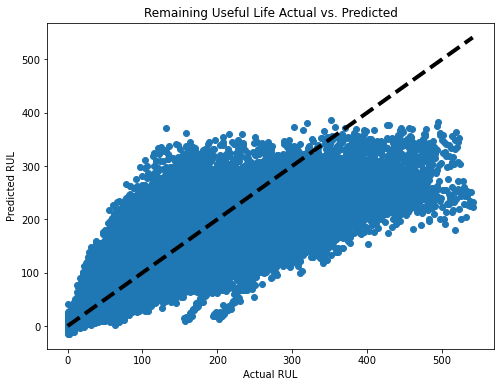

In [234]:
import lightgbm as lgb

regressor = lgb.LGBMRegressor(**best_params)
regressor.fit(X_tr, y_tr, eval_set=(X_te, y_te), verbose=0)
y_pred = regressor.predict(X)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(y, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

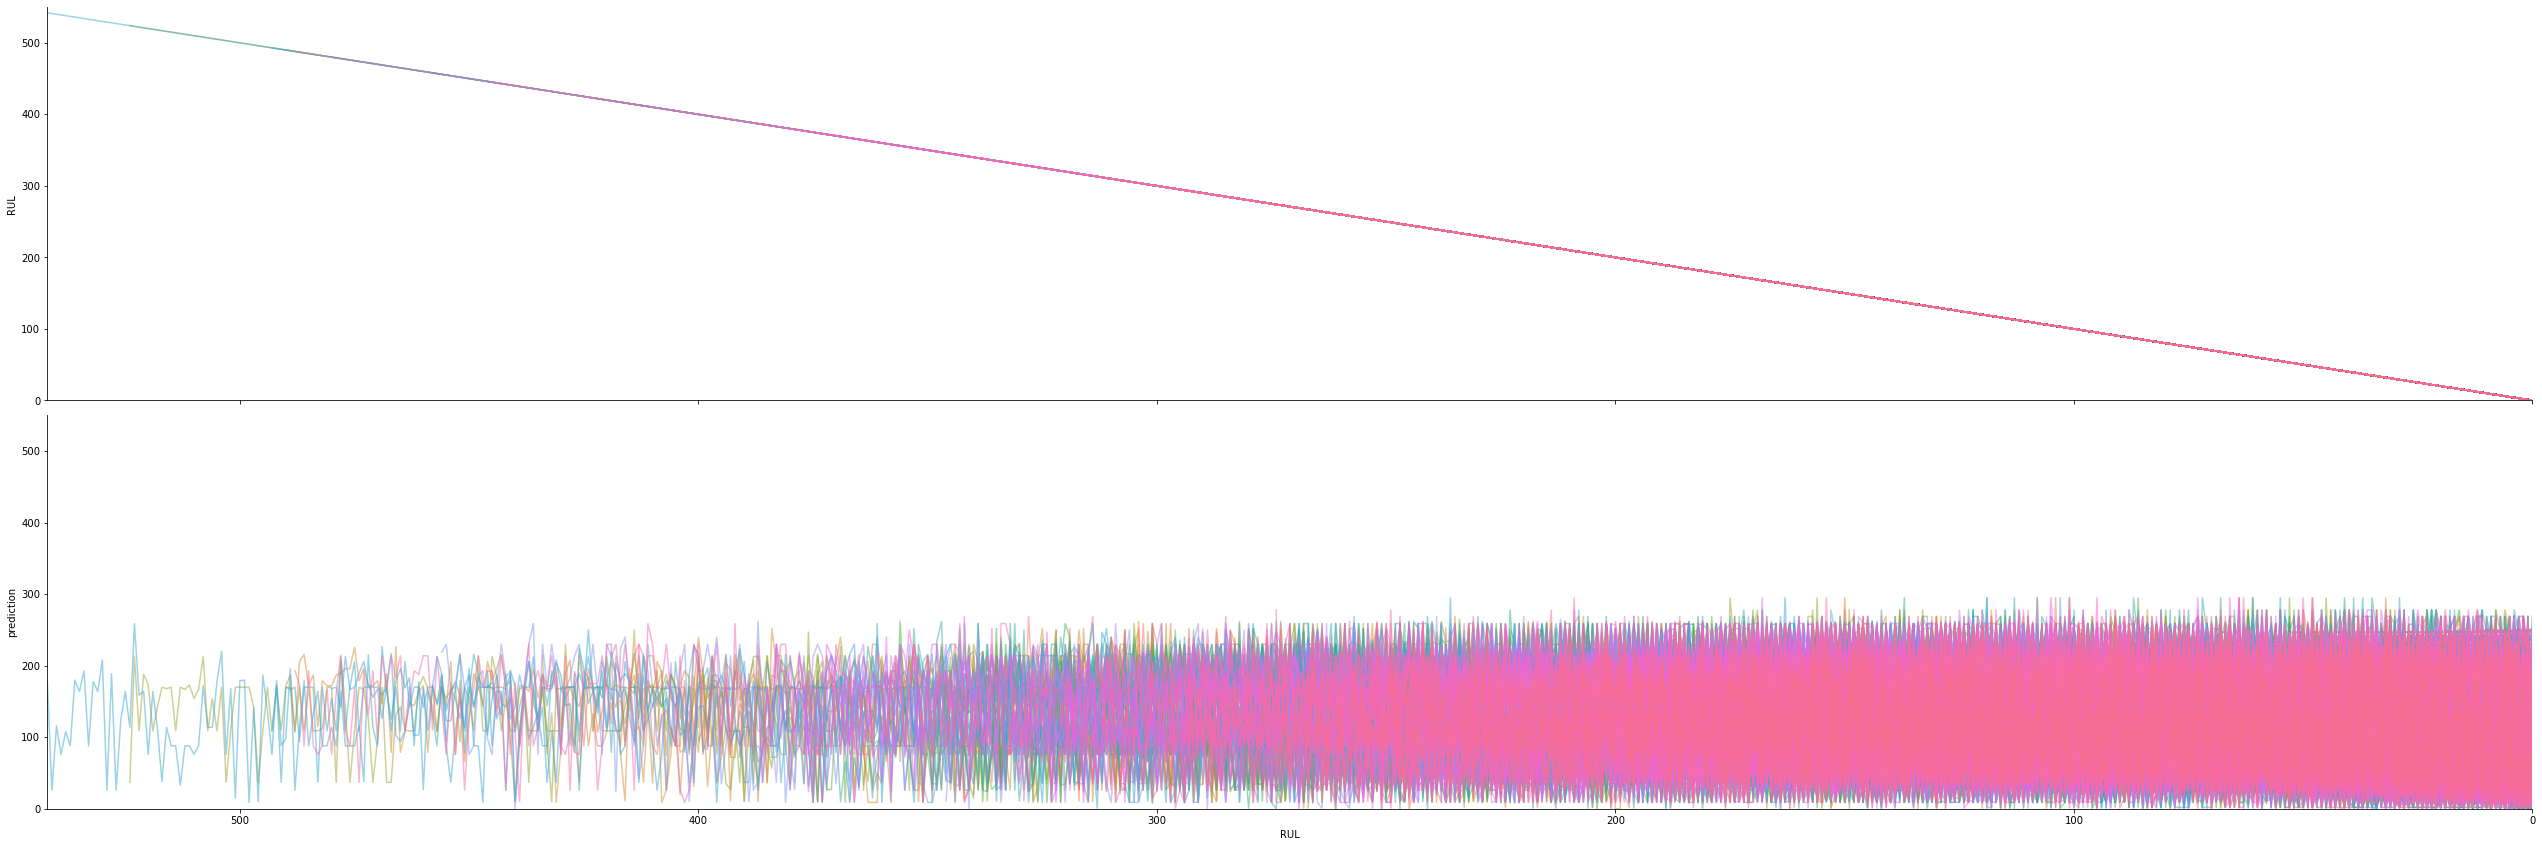

In [146]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

x_tr, x_te, y_tr, y_te = train_test_split(train_tr, train_te, test_size=0.2)
lgb_class = lgb.LGBMClassifier()
lgb_class.fit(train_tr, train_te)
y_pred = lgb_class.predict(train_tr)

result = pd.DataFrame({'engine_no': train['engine_no'],
                       'RUL': train['RUL'],
                      'prediction': y_pred})

import seaborn as sns
g = sns.PairGrid(data=result, x_vars="RUL", y_vars=['RUL', 'prediction'], hue="engine_no", height=6, aspect=6,)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(result['RUL'].max(), result['RUL'].min()))
g = g.set(ylim=(0,550))
